In [10]:
import sys,os

data_path = os.getcwd()

try:
    import localgraphclustering as lgc
except:
    # when the package is not installed, import the local version instead. 
    # the notebook must be placed in the original "notebooks/" folder
    sys.path.append("../")
    import localgraphclustering as lgc

In [11]:
import time
import numpy as np

import matplotlib.pyplot as plt

# Import the graph_tool module for visualization.
from graph_tool.all import * 

import statistics as stat_

# Load graph

In [12]:
# Read graph. This also supports gml format.
#g = lgc.GraphLocal(os.path.join(data_path,'datasets/JohnsHopkins.graphml'),'graphml')
g = lgc.GraphLocal(os.path.join(data_path,'datasets/Bucknell39_reduced.graphml'),'graphml')
# To get a quick look at the list of methods and attributes for the graph object 'g' you can type 'g.' + tab
# and scroll up or down.

vol_G = g.vol_G

## Load graph using GraphTool. We do this to handle some meta-data which LocalGraphClustering is not handling yet.

In [13]:
g_gtool = load_graph('datasets/Bucknell39_reduced.graphml')
remove_self_loops(g_gtool)

n = g_gtool.num_vertices()

## Load coordinates for graph layout

In [14]:
# Load pre-computed coordinates for nodes.
g_v_prop = g_gtool.vertex_properties
xx = g_v_prop.x
yy = g_v_prop.y

pos = g_gtool.new_vertex_property("vector<double>")
for i in range(n):
    pos[i] = [xx[i],yy[i]]

## Load and filter ground truth clusters. This part takes a while to run. The results are saved in results/

In [15]:
g_v_prop = g_gtool.vertex_properties
#feature_list = [g_v_prop.secondMajor,g_v_prop.highSchool,g_v_prop.gender,g_v_prop.dorm,g_v_prop.majorIndex,g_v_prop.year]
feature_list = [g_v_prop.dorm,g_v_prop.majorIndex,g_v_prop.year]

number_feature = 0

ref_nodes = []
info_ref_nodes = []

for kk in feature_list:
    
    feature = kk

    for ff in list(set(feature.a)):
        
        if ff == 0:
            continue

        feature_array = np.zeros(n)
        feature_ff_nodes = []
        for i in range(n):
            feature_array[i] = feature[i]
            if feature_array[i] == ff:
                feature_ff_nodes.append(i)

        g_ff = g_gtool.copy()

        del_list_ff = list(set(range(n)) - set(feature_ff_nodes))

        for v in reversed(sorted(del_list_ff)):
            g_ff.remove_vertex(v)   

        n_ff = g_ff.num_vertices() 

        comp_ff,hist_ff=label_components(g_ff)

        feature_ff_nodes_largest_component = []
        for i in range(n_ff):
            if comp_ff[i] == 0:
                feature_ff_nodes_largest_component.append(feature_ff_nodes[i])    

        vol_ff = sum(g.d[feature_ff_nodes_largest_component])
        
        if vol_ff < 1000:
            continue
            
        #temp = np.zeros(n)
        #temp[feature_ff_nodes_largest_component] = 1
        
        #cut_ff = vol_ff - (g.adjacency_matrix.dot(temp).transpose()).dot(temp)
        #cond_ff = cut_ff/min(vol_ff,vol_G - vol_ff)
        cond_ff = g.compute_conductance(feature_ff_nodes_largest_component,cpp=True)
        
        if cond_ff > 0.47:
            continue
            
        print("Reached")
        eig_ff, lambda_ff = lgc.fiedler_local(g, feature_ff_nodes_largest_component)
        lambda_ff = np.real(lambda_ff)
        gap_ff = lambda_ff/cond_ff
        
        print("Number of feature", number_feature, "Feature value ", ff, " gap ",gap_ff, " volume: ", vol_ff, " size:", len(feature_ff_nodes_largest_component), "conductance: ", cond_ff)
        
        if gap_ff >= 0.5 and vol_ff >= 1000:
            ref_nodes.append(feature_ff_nodes_largest_component)
            info_ref_nodes.append([number_feature,ff])
            np.save('results/ref_nodes_Bucknell39', ref_nodes) 
            np.save('results/info_ref_nodes_Bucknell39', info_ref_nodes) 
        
    number_feature += 1

Reached
Number of feature 2 Feature value  2007  gap  [0.93249827]  volume:  75526.0  size: 702 conductance:  0.4323279400471361
Reached
Number of feature 2 Feature value  2008  gap  [0.92468074]  volume:  80776.0  size: 808 conductance:  0.2897890462513618
Reached
Number of feature 2 Feature value  2009  gap  [0.90690619]  volume:  48186.0  size: 801 conductance:  0.15323953015398664


## If you have generated the ground truth datasets once, you can avoid rerunning the above code and simple run the code below.

In [16]:
ref_nodes = np.load('results/ref_nodes_Bucknell39.npy') 
info_ref_nodes = np.load('results/info_ref_nodes_Bucknell39.npy') 

## Visualize the ground truth clusters

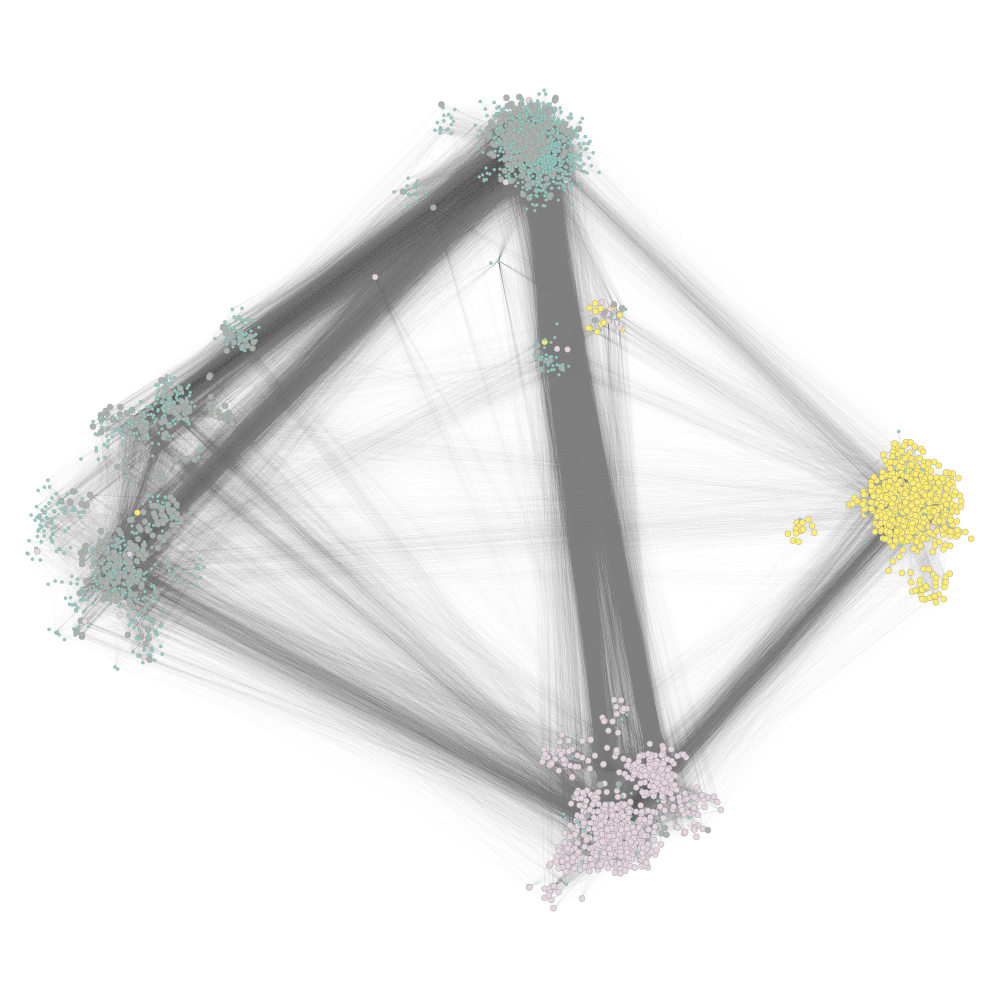

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x14ddafb70, at 0x14a0519e8>

In [17]:
temp = np.zeros(n)
temp = temp + 3

temp2 = np.zeros(n, dtype=int)

counter = 0

for i in ref_nodes:
        
    temp[i] = 6
    
    for j in i:
        temp2[j] = int(info_ref_nodes[counter,1])
    counter += 1

node_size = g_gtool.new_vertex_property("double",temp)

node_colours = g_gtool.new_vertex_property("int",temp2)

c_map = plt.get_cmap('Dark2')

graph_draw(g_gtool, pos, output_size=(1000, 1000),
            vertex_size=node_size, 
            vertex_fill_color=node_colours,
            edge_pen_width=0.1,
            edge_color = [0.0, 0, 0, 0.05]
            )

## Results by spectral algorithm: https://dl.acm.org/citation.cfm?id=1170528 

In [18]:
nodes = {}
external_best_cond_acl = {}
external_best_pre_cond_acl = {}
gap_best_cond_acl = {}
gap_best_pre_acl = {}
vol_best_cond_acl = {}
vol_best_pre_acl = {}
size_clust_best_cond_acl = {}
size_clust_best_pre_acl = {}
f1score_best_cond_acl = {}
f1score_best_pre_acl = {}
true_positives_best_cond_acl = {}
true_positives_best_pre_acl = {}
precision_best_cond_acl = {}
precision_best_pre_acl = {}
recall_best_cond_acl = {}
recall_best_pre_acl = {}
cuts_best_cond_acl = {}
cuts_best_pre_acl = {}
cuts_acl_ALL = {}

ct_outer = 0
for rr in ref_nodes:
    
    how_many = int(len(rr)/2)
    print(how_many)
    
    nodes[ct_outer] = np.random.choice(rr, how_many, replace=False)
    
    eigv, lambda_val = lgc.fiedler_local(g, rr)
    lambda_val = np.real(lambda_val)
    
    step = (2*lambda_val - lambda_val/2)/4
    
    a_list = np.arange(lambda_val/2,2*lambda_val,step)

    ct = 0
    for node in nodes[ct_outer]:
        ref_node = [node]

        max_precision = -1
        min_conduct = 100
        
        ct_inner = 0
        for a in a_list:

            output_pr_clustering = lgc.spectral_clustering(g,ref_node,method="l1reg",alpha=a,rho=2.0e-7,epsilon=1.0e-2,iterations=1000)
            
            S_l1pr = output_pr_clustering[0]
            
            cuts_acl_ALL[ct_outer,node,ct_inner] = S_l1pr
            
            size_clust_acl_ = len(S_l1pr)
            
            cond_val_l1pr = output_pr_clustering[1]
            
            vol_ = sum(g.d[S_l1pr])
            true_positives_acl_ = set(rr).intersection(S_l1pr)
            if len(true_positives_acl_) == 0:
                true_positives_acl_ = set(ref_node)
                vol_ = g.d[ref_node][0,0]
            precision = sum(g.d[np.array(list(true_positives_acl_))])/vol_
            recall = sum(g.d[np.array(list(true_positives_acl_))])/sum(g.d[rr])
            f1_score_ = 2*(precision*recall)/(precision + recall)
            
            if f1_score_ >= max_precision:
            
                max_precision = f1_score_
            
                S_smqi, S_smqi_val = lgc.fiedler_local(g, S_l1pr)
                S_smqi_val = np.real(S_smqi_val)

                external_best_pre_cond_acl[ct_outer,node] = cond_val_l1pr
                gap_best_pre_acl[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S_l1pr])))/cond_val_l1pr
                vol_best_pre_acl[ct_outer,node] = vol_

                size_clust_best_pre_acl[ct_outer,node] = size_clust_acl_
                true_positives_best_pre_acl[ct_outer,node] = true_positives_acl_
                precision_best_pre_acl[ct_outer,node] = precision
                recall_best_pre_acl[ct_outer,node] = recall
                f1score_best_pre_acl[ct_outer,node] = f1_score_
                
                cuts_best_pre_acl[ct_outer,node] = S_l1pr
                
            if cond_val_l1pr <= min_conduct:
            
                min_conduct = cond_val_l1pr
            
                S_smqi, S_smqi_val = lgc.fiedler_local(g, S_l1pr)
                S_smqi_val = np.real(S_smqi_val)

                external_best_cond_acl[ct_outer,node] = cond_val_l1pr
                gap_best_cond_acl[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S_l1pr])))/cond_val_l1pr
                vol_best_cond_acl[ct_outer,node] = vol_

                size_clust_best_cond_acl[ct_outer,node] = size_clust_acl_
                true_positives_best_cond_acl[ct_outer,node] = true_positives_acl_
                precision_best_cond_acl[ct_outer,node] = precision
                recall_best_cond_acl[ct_outer,node] = recall
                f1score_best_cond_acl[ct_outer,node] = f1_score_
                
                cuts_best_cond_acl[ct_outer,node] = S_l1pr

        print('outer:', ct_outer, 'number of node: ',node, ' completed: ', ct/how_many, ' degree: ', g.d[node])
        print('conductance: ', external_best_cond_acl[ct_outer,node], 'f1score: ', f1score_best_pre_acl[ct_outer,node], 'precision: ', precision_best_pre_acl[ct_outer,node], 'recall: ', recall_best_pre_acl[ct_outer,node])
        ct += 1
    ct_outer += 1
    
    np.save('results/size_clust_best_cond_acl_Bucknell39', size_clust_best_cond_acl) 
    np.save('results/external_best_cond_acl_Bucknell39', external_best_cond_acl)
    np.save('results/vol_best_cond_acl_Bucknell39', vol_best_cond_acl) 
    np.save('results/gap_best_cond_acl_Bucknell39', gap_best_cond_acl) 
    np.save('results/cuts_best_cond_acl_Bucknell39', cuts_best_cond_acl) 
    np.save('results/true_positives_best_cond_acl_Bucknell39', true_positives_best_cond_acl)
    np.save('results/f1score_best_cond_acl_Bucknell39', f1score_best_cond_acl) 
    np.save('results/precision_best_cond_acl_Bucknell39', precision_best_cond_acl) 
    np.save('results/recall_best_cond_acl_Bucknell39', recall_best_cond_acl) 

    np.save('results/size_clust_best_pre_acl_Bucknell39', size_clust_best_pre_acl) 
    np.save('results/external_best_pre_cond_acl_Bucknell39', external_best_pre_cond_acl)
    np.save('results/vol_best_pre_acl_Bucknell39', vol_best_pre_acl) 
    np.save('results/gap_best_pre_acl_Bucknell39', gap_best_pre_acl) 
    np.save('results/cuts_best_pre_acl_Bucknell39', cuts_best_pre_acl) 
    np.save('results/true_positives_best_pre_acl_Bucknell39', true_positives_best_pre_acl)
    np.save('results/f1score_best_pre_acl_Bucknell39', f1score_best_pre_acl) 
    np.save('results/precision_best_pre_acl_Bucknell39', precision_best_pre_acl) 
    np.save('results/recall_best_pre_acl_Bucknell39', recall_best_pre_acl) 

    np.save('results/cuts_acl_ALL_Bucknell39', cuts_acl_ALL) 
    
    np.save('results/nodes_Bucknell39', nodes)

351
outer: 0 number of node:  2764  completed:  0.0  degree:  128.0
conductance:  0.23033654725345407 f1score:  0.4702819882561793 precision:  0.34696807505824573 recall:  0.729576569658131
outer: 0 number of node:  2942  completed:  0.002849002849002849  degree:  75.0
conductance:  0.2627988930005611 f1score:  0.5204315024067182 precision:  0.38396151569721315 recall:  0.8074040727696422
outer: 0 number of node:  533  completed:  0.005698005698005698  degree:  13.0
conductance:  0.1770104989717502 f1score:  0.6247676857235417 precision:  0.46070283522977307 recall:  0.9703148584593385
outer: 0 number of node:  3318  completed:  0.008547008547008548  degree:  52.0
conductance:  0.25260426507450656 f1score:  0.4479922758479265 precision:  0.33070106278974426 recall:  0.6942112649948362
outer: 0 number of node:  3815  completed:  0.011396011396011397  degree:  9.0
conductance:  0.2726286852790598 f1score:  0.38864171013603355 precision:  0.28655371350284686 recall:  0.6037258692370839
ou

outer: 0 number of node:  942  completed:  0.1168091168091168  degree:  15.0
conductance:  0.25248478893465853 f1score:  0.4299105277074111 precision:  0.31708605938600903 recall:  0.6673728252522311
outer: 0 number of node:  1780  completed:  0.11965811965811966  degree:  32.0
conductance:  0.26560906515580734 f1score:  0.4898806434872859 precision:  0.486109481533628 recall:  0.4937107750973175
outer: 0 number of node:  1048  completed:  0.1225071225071225  degree:  120.0
conductance:  0.2736504576695078 f1score:  0.5167816445030355 precision:  0.38123084089206694 recall:  0.8019092762757196
outer: 0 number of node:  1380  completed:  0.12535612535612536  degree:  70.0
conductance:  0.22042683613909358 f1score:  0.5592173193272292 precision:  0.4125516216760677 recall:  0.8676879485210391
outer: 0 number of node:  536  completed:  0.1282051282051282  degree:  30.0
conductance:  0.2454118328735719 f1score:  0.5178236220769543 precision:  0.40217295744930254 recall:  0.7268357916479093

outer: 0 number of node:  896  completed:  0.2336182336182336  degree:  28.0
conductance:  0.22937040514852391 f1score:  0.5197281463984513 precision:  0.3832918270319221 recall:  0.8069803776183037
outer: 0 number of node:  2425  completed:  0.23646723646723647  degree:  85.0
conductance:  0.2523809523809524 f1score:  0.4606633695897998 precision:  0.33986261435686266 recall:  0.7146942774673622
outer: 0 number of node:  2756  completed:  0.23931623931623933  degree:  80.0
conductance:  0.23156861336589804 f1score:  0.6323675193772661 precision:  0.6355260166624319 recall:  0.629240261631756
outer: 0 number of node:  734  completed:  0.24216524216524216  degree:  125.0
conductance:  0.30523169662843413 f1score:  0.5077410739806911 precision:  0.37455703612319274 recall:  0.7879008553345868
outer: 0 number of node:  837  completed:  0.245014245014245  degree:  51.0
conductance:  0.3033419023136247 f1score:  0.5567003272198261 precision:  0.4106739345263198 recall:  0.8638746921589916
o

outer: 0 number of node:  1679  completed:  0.3504273504273504  degree:  122.0
conductance:  0.2684205221247858 f1score:  0.6477089830836733 precision:  0.6534476021075043 recall:  0.6420702804332283
outer: 0 number of node:  1409  completed:  0.35327635327635326  degree:  141.0
conductance:  0.2188663450311722 f1score:  0.6612333920539971 precision:  0.6449241613695009 recall:  0.6783888991870349
outer: 0 number of node:  409  completed:  0.3561253561253561  degree:  147.0
conductance:  0.24520011582671317 f1score:  0.475821901734474 precision:  0.3510346955092893 recall:  0.7382623202605725
outer: 0 number of node:  396  completed:  0.358974358974359  degree:  136.0
conductance:  0.17786561264822134 f1score:  0.6422759059122696 precision:  0.6177391346882872 recall:  0.6688425178084368
outer: 0 number of node:  1342  completed:  0.36182336182336183  degree:  180.0
conductance:  0.21084434977889935 f1score:  0.5786244036493672 precision:  0.42689653435422126 recall:  0.897677620951725

outer: 0 number of node:  3268  completed:  0.4672364672364672  degree:  59.0
conductance:  0.2968645456013658 f1score:  0.46483049943464255 precision:  0.3429258557407186 recall:  0.7212085904191934
outer: 0 number of node:  831  completed:  0.4700854700854701  degree:  17.0
conductance:  0.23293181870128682 f1score:  0.5705611282357914 precision:  0.4671410243424829 recall:  0.7327940047136086
outer: 0 number of node:  3702  completed:  0.47293447293447294  degree:  137.0
conductance:  0.25243610726425786 f1score:  0.5509862665266859 precision:  0.40652551765832035 recall:  0.8547122845112941
outer: 0 number of node:  3492  completed:  0.4757834757834758  degree:  42.0
conductance:  0.29620320148167745 f1score:  0.49282794753863346 precision:  0.36356826308102935 recall:  0.7647035457987977
outer: 0 number of node:  789  completed:  0.47863247863247865  degree:  12.0
conductance:  0.2793533481482414 f1score:  0.5645809230664145 precision:  0.41662098730428754 recall:  0.8755130683473

outer: 0 number of node:  2714  completed:  0.584045584045584  degree:  50.0
conductance:  0.30197811447811446 f1score:  0.4764077524999467 precision:  0.35136716170060195 recall:  0.7396128485554644
outer: 0 number of node:  3201  completed:  0.5868945868945868  degree:  70.0
conductance:  0.3506729055539112 f1score:  0.37934166592040114 precision:  0.279779839597421 recall:  0.5889097794137118
outer: 0 number of node:  1562  completed:  0.5897435897435898  degree:  180.0
conductance:  0.23115081238629426 f1score:  0.5172505013440286 precision:  0.381594520409962 recall:  0.8025580594762068
outer: 0 number of node:  3571  completed:  0.5925925925925926  degree:  24.0
conductance:  0.2998740236835475 f1score:  0.4953006154870544 precision:  0.3654635928445452 recall:  0.7682255117443
outer: 0 number of node:  1908  completed:  0.5954415954415955  degree:  129.0
conductance:  0.2565740232523327 f1score:  0.5821868458413093 precision:  0.4293376763021046 recall:  0.9040330482218044
outer

outer: 0 number of node:  815  completed:  0.7008547008547008  degree:  122.0
conductance:  0.3384535965652267 f1score:  0.4575397638064032 precision:  0.33753414999559356 recall:  0.7099541879617615
outer: 0 number of node:  3520  completed:  0.7037037037037037  degree:  124.0
conductance:  0.20817357571383463 f1score:  0.5662791937719953 precision:  0.4177181731791893 recall:  0.8788364271906364
outer: 0 number of node:  2864  completed:  0.7065527065527065  degree:  250.0
conductance:  0.16985438637276243 f1score:  0.6056454571045919 precision:  0.44673059498640894 recall:  0.9400471360855864
outer: 0 number of node:  2126  completed:  0.7094017094017094  degree:  8.0
conductance:  0.20272211051945468 f1score:  0.4360921425074096 precision:  0.27912177573386243 recall:  0.9964912745279771
outer: 0 number of node:  717  completed:  0.7122507122507122  degree:  83.0
conductance:  0.2166950919082812 f1score:  0.5670213946184897 precision:  0.41832250428125317 recall:  0.879736779387230

outer: 0 number of node:  2542  completed:  0.8176638176638177  degree:  102.0
conductance:  0.27043296476336803 f1score:  0.6019589004881131 precision:  0.5866944859918805 recall:  0.6180388210682414
outer: 0 number of node:  2644  completed:  0.8205128205128205  degree:  81.0
conductance:  0.3591091358895107 f1score:  0.5366600820025343 precision:  0.3959032337259296 recall:  0.8327198580621243
outer: 0 number of node:  2737  completed:  0.8233618233618234  degree:  53.0
conductance:  0.2869402323874136 f1score:  0.446675395237953 precision:  0.3294558768944279 recall:  0.6933771151656383
outer: 0 number of node:  336  completed:  0.8262108262108262  degree:  65.0
conductance:  0.26395500602147554 f1score:  0.5255995699988909 precision:  0.38771618457820406 recall:  0.8156793686942245
outer: 0 number of node:  3197  completed:  0.8290598290598291  degree:  73.0
conductance:  0.28146562578695544 f1score:  0.5571029927549218 precision:  0.41099848904558045 recall:  0.8643778301512062
o

outer: 0 number of node:  1693  completed:  0.9373219373219374  degree:  194.0
conductance:  0.23789370264704215 f1score:  0.6702652664235631 precision:  0.6352029021588363 recall:  0.7094245690225882
outer: 0 number of node:  3112  completed:  0.9401709401709402  degree:  77.0
conductance:  0.22292761735727126 f1score:  0.5849423649565284 precision:  0.43150176233635446 recall:  0.907727140322538
outer: 0 number of node:  2175  completed:  0.9430199430199431  degree:  82.0
conductance:  0.2578480845192871 f1score:  0.5034639467637084 precision:  0.3716078184110971 recall:  0.7803537854513677
outer: 0 number of node:  1896  completed:  0.9458689458689459  degree:  31.0
conductance:  0.3034672245818787 f1score:  0.41816291574704517 precision:  0.3082891463322695 recall:  0.649723274104282
outer: 0 number of node:  1464  completed:  0.9487179487179487  degree:  77.0
conductance:  0.2895286010604427 f1score:  0.5136531806214022 precision:  0.3789629443062683 recall:  0.7968778963535736
ou

outer: 1 number of node:  3022  completed:  0.04702970297029703  degree:  57.0
conductance:  0.2800569154830261 f1score:  0.6736085606490602 precision:  0.5080903092575804 recall:  0.9990715063880361
outer: 1 number of node:  2372  completed:  0.04950495049504951  degree:  6.0
conductance:  0.25440875949239344 f1score:  0.7464530507963648 precision:  0.6211908110642288 recall:  0.9349930672476974
outer: 1 number of node:  486  completed:  0.05198019801980198  degree:  91.0
conductance:  0.26466439994962854 f1score:  0.6717984663011823 precision:  0.5066454381835802 recall:  0.9966945627414083
outer: 1 number of node:  917  completed:  0.054455445544554455  degree:  104.0
conductance:  0.3190658783677427 f1score:  0.6110709977921444 precision:  0.46092820309401034 recall:  0.906284044765772
outer: 1 number of node:  664  completed:  0.05693069306930693  degree:  270.0
conductance:  0.21546467090011087 f1score:  0.6727976443699274 precision:  0.5073086357632556 recall:  0.998526790135683

outer: 1 number of node:  681  completed:  0.1485148514851485  degree:  57.0
conductance:  0.2361706547810157 f1score:  0.6699774228684225 precision:  0.5053353226689834 recall:  0.993748143012776
outer: 1 number of node:  1595  completed:  0.15099009900990099  degree:  295.0
conductance:  0.2480642602641419 f1score:  0.6510787464007011 precision:  0.4910735644050512 recall:  0.9657447756759433
outer: 1 number of node:  2412  completed:  0.15346534653465346  degree:  171.0
conductance:  0.26608612428140566 f1score:  0.6702866945194559 precision:  0.5056007858100833 recall:  0.9940824007130831
outer: 1 number of node:  1886  completed:  0.15594059405940594  degree:  102.0
conductance:  0.2959465074987722 f1score:  0.6337092344805135 precision:  0.47800108294611715 recall:  0.9398707536892146
outer: 1 number of node:  399  completed:  0.15841584158415842  degree:  74.0
conductance:  0.26392404266304004 f1score:  0.6379946260785394 precision:  0.4811579609817495 recall:  0.946518767950876

outer: 1 number of node:  406  completed:  0.25  degree:  146.0
conductance:  0.26775054781754526 f1score:  0.6335433267971129 precision:  0.47778672741231104 recall:  0.9399697930078241
outer: 1 number of node:  2271  completed:  0.2524752475247525  degree:  54.0
conductance:  0.25503752959548637 f1score:  0.6592405316778892 precision:  0.49716205842006567 recall:  0.9781123105873032
outer: 1 number of node:  903  completed:  0.25495049504950495  degree:  73.0
conductance:  0.2569841549739275 f1score:  0.6050742181629961 precision:  0.4564387737108598 recall:  0.8972590868574825
outer: 1 number of node:  202  completed:  0.25742574257425743  degree:  187.0
conductance:  0.2587872300232983 f1score:  0.6741527989476541 precision:  0.5086552943178166 recall:  0.9992819649400813
outer: 1 number of node:  1918  completed:  0.2599009900990099  degree:  89.0
conductance:  0.2727112421042025 f1score:  0.6733761056590543 precision:  0.5079634982712691 recall:  0.9985391700505101
outer: 1 numbe

outer: 1 number of node:  1854  completed:  0.35396039603960394  degree:  116.0
conductance:  0.26917602005467167 f1score:  0.6698701905429306 precision:  0.5051333668847509 recall:  0.9940576408834307
outer: 1 number of node:  2690  completed:  0.3564356435643564  degree:  99.0
conductance:  0.26470069313169503 f1score:  0.6646428034542085 precision:  0.5014681789540013 recall:  0.9852307616123601
outer: 1 number of node:  3668  completed:  0.3589108910891089  degree:  138.0
conductance:  0.25766666456807924 f1score:  0.6727681720107006 precision:  0.5074510347085377 recall:  0.9978458948202437
outer: 1 number of node:  1740  completed:  0.3613861386138614  degree:  120.0
conductance:  0.2635835165042796 f1score:  0.668274064031703 precision:  0.5039415158321222 recall:  0.9916435574923245
outer: 1 number of node:  2163  completed:  0.36386138613861385  degree:  284.0
conductance:  0.26660623457722715 f1score:  0.6702861053615544 precision:  0.50555849322657 recall:  0.994243339605823

outer: 1 number of node:  74  completed:  0.45544554455445546  degree:  57.0
conductance:  0.26768013904807486 f1score:  0.6708686396460324 precision:  0.5060644608738365 recall:  0.9948499554323066
outer: 1 number of node:  3205  completed:  0.45792079207920794  degree:  151.0
conductance:  0.2570671378091873 f1score:  0.6721921289330257 precision:  0.5074015648662292 recall:  0.9955060909180945
outer: 1 number of node:  996  completed:  0.4603960396039604  degree:  196.0
conductance:  0.26798489728768904 f1score:  0.6724500701355954 precision:  0.5072940287226001 recall:  0.9970535802713677
outer: 1 number of node:  1973  completed:  0.4628712871287129  degree:  53.0
conductance:  0.2722337678695132 f1score:  0.6713222533707115 precision:  0.5062540896964816 recall:  0.9961127067445776
outer: 1 number of node:  1572  completed:  0.46534653465346537  degree:  78.0
conductance:  0.2388227848101266 f1score:  0.6281444644950978 precision:  0.4729035974105656 recall:  0.9351168663959591
o

outer: 1 number of node:  2237  completed:  0.5594059405940595  degree:  45.0
conductance:  0.2602643127427956 f1score:  0.6400086810265314 precision:  0.4827516732041781 recall:  0.9492175893829851
outer: 1 number of node:  1613  completed:  0.5618811881188119  degree:  59.0
conductance:  0.24935143822528189 f1score:  0.6485775779045131 precision:  0.4900342946811607 recall:  0.9587748836288006
outer: 1 number of node:  2236  completed:  0.5643564356435643  degree:  40.0
conductance:  0.286535842203501 f1score:  0.6738970588235295 precision:  0.5085758966856682 recall:  0.998464890561553
outer: 1 number of node:  2342  completed:  0.5668316831683168  degree:  108.0
conductance:  0.2643364041080795 f1score:  0.6733196213489756 precision:  0.5077807912306425 recall:  0.9989972268990789
outer: 1 number of node:  90  completed:  0.5693069306930693  degree:  112.0
conductance:  0.2799813639568853 f1score:  0.6188342304001334 precision:  0.46671365816204513 recall:  0.918069723680301
outer:

outer: 1 number of node:  2371  completed:  0.6633663366336634  degree:  40.0
conductance:  0.2773505161782027 f1score:  0.6729092131135221 precision:  0.507637169869554 recall:  0.9977468555016341
outer: 1 number of node:  1010  completed:  0.6658415841584159  degree:  80.0
conductance:  0.27206798866855525 f1score:  0.6455860998447749 precision:  0.4869080289030439 recall:  0.9576854511240963
outer: 1 number of node:  128  completed:  0.6683168316831684  degree:  66.0
conductance:  0.25102092261154524 f1score:  0.6439679941200053 precision:  0.485889841189816 recall:  0.9545038130137664
outer: 1 number of node:  2624  completed:  0.6707920792079208  degree:  109.0
conductance:  0.26314463507419444 f1score:  0.6480287875498856 precision:  0.48885823696873504 recall:  0.9608918490640784
outer: 1 number of node:  1190  completed:  0.6732673267326733  degree:  37.0
conductance:  0.286783388289589 f1score:  0.6728139029809372 precision:  0.5071866260252019 recall:  0.9990715063880361
oute

outer: 1 number of node:  1251  completed:  0.7673267326732673  degree:  51.0
conductance:  0.26044315749716734 f1score:  0.6727453304178004 precision:  0.5074090394057661 recall:  0.9979077943943746
outer: 1 number of node:  2972  completed:  0.7698019801980198  degree:  101.0
conductance:  0.2853302442126205 f1score:  0.662810448514897 precision:  0.4999401902579374 recall:  0.9830766564326038
outer: 1 number of node:  2155  completed:  0.7722772277227723  degree:  102.0
conductance:  0.21179226274430787 f1score:  0.6173326769189691 precision:  0.46556541438550125 recall:  0.9159032385857185
outer: 1 number of node:  1796  completed:  0.7747524752475248  degree:  71.0
conductance:  0.2909901626128906 f1score:  0.6735654830980389 precision:  0.5081117507022207 recall:  0.99879914826186
outer: 1 number of node:  3474  completed:  0.7772277227722773  degree:  3.0
conductance:  0.2435896628789071 f1score:  0.40042734507697636 precision:  0.3020277884451943 recall:  0.5939264137862732
out

outer: 1 number of node:  2958  completed:  0.8712871287128713  degree:  94.0
conductance:  0.27531085717883336 f1score:  0.6728489092737813 precision:  0.5075140869455724 recall:  0.9979573140536793
outer: 1 number of node:  1705  completed:  0.8737623762376238  degree:  111.0
conductance:  0.28184457642383437 f1score:  0.6570265700987247 precision:  0.49563859200523996 recall:  0.9742621570763593
outer: 1 number of node:  2680  completed:  0.8762376237623762  degree:  143.0
conductance:  0.2597256237683605 f1score:  0.6641159265486984 precision:  0.5008653622248935 recall:  0.9852431415271863
outer: 1 number of node:  3786  completed:  0.8787128712871287  degree:  82.0
conductance:  0.2908348971649517 f1score:  0.6678938449080452 precision:  0.5038161689693825 recall:  0.9904550856690106
outer: 1 number of node:  2383  completed:  0.8811881188118812  degree:  174.0
conductance:  0.2817249288000605 f1score:  0.672796512501879 precision:  0.5076114625601734 recall:  0.9973506982271962


outer: 1 number of node:  3608  completed:  0.9752475247524752  degree:  70.0
conductance:  0.28056820113715786 f1score:  0.6735112421735008 precision:  0.5082295836353894 recall:  0.9981058730315936
outer: 1 number of node:  3122  completed:  0.9777227722772277  degree:  92.0
conductance:  0.2888734966311945 f1score:  0.6687081754918813 precision:  0.5043041606886657 recall:  0.992151134000198
outer: 1 number of node:  1368  completed:  0.9801980198019802  degree:  90.0
conductance:  0.26967218791118164 f1score:  0.6714901464985958 precision:  0.5064354721968719 recall:  0.9961498464890561
outer: 1 number of node:  1794  completed:  0.9826732673267327  degree:  108.0
conductance:  0.28542642688025793 f1score:  0.6652531053826634 precision:  0.5018135106543751 recall:  0.9865801723284143
outer: 1 number of node:  2783  completed:  0.9851485148514851  degree:  49.0
conductance:  0.2728348737062127 f1score:  0.6739673182421657 precision:  0.5084537563151198 recall:  0.9992448251956026
ou

outer: 2 number of node:  892  completed:  0.085  degree:  26.0
conductance:  0.18012173634470607 f1score:  0.9353714460409661 precision:  0.9189091782796732 recall:  0.9524343170215416
outer: 2 number of node:  507  completed:  0.0875  degree:  105.0
conductance:  0.15357836787564766 f1score:  0.9695063221099658 precision:  0.9575170012953368 recall:  0.9817996928568464
outer: 2 number of node:  84  completed:  0.09  degree:  53.0
conductance:  0.16237635444730683 f1score:  0.9628320728616578 precision:  0.9376020137263771 recall:  0.9894575187813888
outer: 2 number of node:  697  completed:  0.0925  degree:  140.0
conductance:  0.1567736381654021 f1score:  0.9706838399380459 precision:  0.953534463774499 recall:  0.9884613788237248
outer: 2 number of node:  2574  completed:  0.095  degree:  72.0
conductance:  0.1594319507583377 f1score:  0.9673340143003064 precision:  0.95246811763286 recall:  0.9826713153198025
outer: 2 number of node:  3291  completed:  0.0975  degree:  17.0
conduc

outer: 2 number of node:  1834  completed:  0.1975  degree:  84.0
conductance:  0.17707118410737843 f1score:  0.9520833540657 precision:  0.914628783388463 recall:  0.9927364794753663
outer: 2 number of node:  1377  completed:  0.2  degree:  60.0
conductance:  0.14889068172650263 f1score:  0.9755947875539555 precision:  0.9618797902379992 recall:  0.9897065537708049
outer: 2 number of node:  683  completed:  0.2025  degree:  38.0
conductance:  0.1881936959933443 f1score:  0.46749164431206863 precision:  0.3050499806914365 recall:  1.0
outer: 2 number of node:  922  completed:  0.205  degree:  22.0
conductance:  0.21075300008197806 f1score:  0.4654527891813572 precision:  0.3033160439117736 recall:  1.0
outer: 2 number of node:  1914  completed:  0.2075  degree:  41.0
conductance:  0.1800861204506577 f1score:  0.941309505780201 precision:  0.9165732712007708 recall:  0.9674179222180717
outer: 2 number of node:  3087  completed:  0.21  degree:  30.0
conductance:  0.1584452632830144 f1sco

outer: 2 number of node:  2924  completed:  0.31  degree:  131.0
conductance:  0.18103316875973358 f1score:  0.9380369542191361 precision:  0.8892669865000558 recall:  0.9924666915701656
outer: 2 number of node:  1677  completed:  0.3125  degree:  13.0
conductance:  0.18841176955410863 f1score:  0.9287826464567093 precision:  0.9254718536223523 recall:  0.9321172124683518
outer: 2 number of node:  51  completed:  0.315  degree:  37.0
conductance:  0.1561336817929833 f1score:  0.9731898595659311 precision:  0.9508196721311475 recall:  0.9966380276428838
outer: 2 number of node:  76  completed:  0.3175  degree:  16.0
conductance:  0.19109162824679415 f1score:  0.46565969906937643 precision:  0.3034917995616356 recall:  1.0
outer: 2 number of node:  3300  completed:  0.32  degree:  146.0
conductance:  0.1600284495021337 f1score:  0.9680168417643368 precision:  0.9447803066224119 recall:  0.9924251857385963
outer: 2 number of node:  183  completed:  0.3225  degree:  29.0
conductance:  0.17

outer: 2 number of node:  1585  completed:  0.4225  degree:  64.0
conductance:  0.15353879020453376 f1score:  0.9721895888191209 precision:  0.9494204217272619 recall:  0.9960776989166978
outer: 2 number of node:  2059  completed:  0.425  degree:  28.0
conductance:  0.15619446940201656 f1score:  0.9698486837418975 precision:  0.9514625137266647 recall:  0.9889594488025567
outer: 2 number of node:  616  completed:  0.4275  degree:  76.0
conductance:  0.16393475037073654 f1score:  0.9629712133331984 precision:  0.9402273850716757 recall:  0.9868426513925207
outer: 2 number of node:  1355  completed:  0.43  degree:  55.0
conductance:  0.17195851615476665 f1score:  0.9509997355735004 precision:  0.9324690865576386 recall:  0.9702818245963558
outer: 2 number of node:  2879  completed:  0.4325  degree:  20.0
conductance:  0.22480610394842868 f1score:  0.4658014935112013 precision:  0.30361227151579306 recall:  1.0
outer: 2 number of node:  160  completed:  0.435  degree:  52.0
conductance:  

outer: 2 number of node:  2681  completed:  0.535  degree:  119.0
conductance:  0.1663340767695739 f1score:  0.9643907351460222 precision:  0.9367687913291858 recall:  0.993691113601461
outer: 2 number of node:  2868  completed:  0.5375  degree:  19.0
conductance:  0.18968122072820667 f1score:  0.4671630504333663 precision:  0.3047702174490532 recall:  1.0
outer: 2 number of node:  2094  completed:  0.54  degree:  11.0
conductance:  0.1759621077560687 f1score:  0.9497653152059562 precision:  0.9264850996644958 recall:  0.9742456315112273
outer: 2 number of node:  692  completed:  0.5425  degree:  57.0
conductance:  0.17416554232416262 f1score:  0.951966736134183 precision:  0.9244637375100213 recall:  0.9811563524675216
outer: 2 number of node:  17  completed:  0.545  degree:  84.0
conductance:  0.16074350028581003 f1score:  0.9710369089861401 precision:  0.9466619360179764 recall:  0.9967002863902378
outer: 2 number of node:  1407  completed:  0.5475  degree:  67.0
conductance:  0.172

outer: 2 number of node:  2987  completed:  0.6475  degree:  35.0
conductance:  0.16288668219525151 f1score:  0.9553372868791697 precision:  0.9479588083854358 recall:  0.9628315278296601
outer: 2 number of node:  2071  completed:  0.65  degree:  24.0
conductance:  0.15464836077192556 f1score:  0.9687093236581292 precision:  0.9569689974282648 recall:  0.9807412941518283
outer: 2 number of node:  1195  completed:  0.6525  degree:  46.0
conductance:  0.15125933852525614 f1score:  0.9732080406288963 precision:  0.9512514119255693 recall:  0.9962022164114058
outer: 2 number of node:  3372  completed:  0.655  degree:  39.0
conductance:  0.17675467480891657 f1score:  0.9477186021669464 precision:  0.9295336167155601 recall:  0.9666293114182543
outer: 2 number of node:  2786  completed:  0.6575  degree:  64.0
conductance:  0.16796122290867915 f1score:  0.9482060390763766 precision:  0.9279286437950695 recall:  0.969389449217615
outer: 2 number of node:  3382  completed:  0.66  degree:  47.0


outer: 2 number of node:  1999  completed:  0.76  degree:  13.0
conductance:  0.17943155798273488 f1score:  0.4681775122057859 precision:  0.30563431202785757 recall:  1.0
outer: 2 number of node:  2753  completed:  0.7625  degree:  29.0
conductance:  0.2165938706345035 f1score:  0.9095130752783879 precision:  0.8518948112438154 recall:  0.9754908064583074
outer: 2 number of node:  3259  completed:  0.765  degree:  40.0
conductance:  0.19859950162445195 f1score:  0.46623867325266927 precision:  0.3039838501088225 recall:  1.0
outer: 2 number of node:  704  completed:  0.7675  degree:  51.0
conductance:  0.15808383233532936 f1score:  0.9676047453350426 precision:  0.9491217564870259 recall:  0.986821898476736
outer: 2 number of node:  3286  completed:  0.77  degree:  13.0
conductance:  0.16250225781202962 f1score:  0.9612806464448593 precision:  0.9454512613643206 recall:  0.9776491096999128
outer: 2 number of node:  623  completed:  0.7725  degree:  34.0
conductance:  0.159328387971604

outer: 2 number of node:  1462  completed:  0.8725  degree:  104.0
conductance:  0.15696496370468002 f1score:  0.9697734778173885 precision:  0.9445242263883697 recall:  0.9964097455692524
outer: 2 number of node:  471  completed:  0.875  degree:  46.0
conductance:  0.16717013169065528 f1score:  0.958304244447817 precision:  0.9350036525893897 recall:  0.9827958328145104
outer: 2 number of node:  3790  completed:  0.8775  degree:  13.0
conductance:  0.17404009236365123 f1score:  0.9473760077427593 precision:  0.9401066677565033 recall:  0.9547586435894243
outer: 2 number of node:  3692  completed:  0.88  degree:  75.0
conductance:  0.16800216253789269 f1score:  0.9583204136951499 precision:  0.92496765847348 recall:  0.9941684306645083
outer: 2 number of node:  314  completed:  0.8825  degree:  22.0
conductance:  0.17486475559748185 f1score:  0.9573649991510951 precision:  0.9227422366825174 recall:  0.994687253559125
outer: 2 number of node:  2560  completed:  0.885  degree:  158.0
co

outer: 2 number of node:  2408  completed:  0.985  degree:  30.0
conductance:  0.17592272522713487 f1score:  0.4782515917403193 precision:  0.31427770132335003 recall:  1.0
outer: 2 number of node:  2856  completed:  0.9875  degree:  11.0
conductance:  0.17910973652272638 f1score:  0.937222983318559 precision:  0.9106213052499706 recall:  0.9654256423027435
outer: 2 number of node:  3655  completed:  0.99  degree:  132.0
conductance:  0.14523670954664955 f1score:  0.9790338213538744 precision:  0.9628930943827891 recall:  0.9957248993483584
outer: 2 number of node:  563  completed:  0.9925  degree:  70.0
conductance:  0.15830851697438952 f1score:  0.9686878525914201 precision:  0.9476871153464363 recall:  0.9906404349811149
outer: 2 number of node:  1934  completed:  0.995  degree:  133.0
conductance:  0.14861631709067707 f1score:  0.976103801020927 precision:  0.9569343647818805 recall:  0.9960569460009131
outer: 2 number of node:  1817  completed:  0.9975  degree:  11.0
conductance: 

## Improve the results found by the spectral algorithm using MQI

In [19]:
nodes = np.load('results/nodes_Bucknell39.npy')
nodes = nodes[()]

external_cond_acl_flow = {}
gap_acl_flow = {}
vol_acl_flow = {}
size_clust_acl_flow = {}
f1score_acl_flow = {}
true_positives_acl_flow = {}
precision_acl_flow = {}
recall_acl_flow = {}
cuts_acl_flow = {}

cuts_best_pre_acl = np.load('results/cuts_best_pre_acl_Bucknell39.npy')
cuts_best_pre_acl = cuts_best_pre_acl[()]

ct_outer = 0
for rr in ref_nodes:
    
    how_many = int(len(rr)/2)
    print(how_many)

    ct = 0
    for node in nodes[ct_outer]:
        ref_node = [node]

        ref_set = cuts_best_pre_acl[ct_outer,node]

        output_mqi = lgc.flow_clustering(g,ref_set,method="mqi")
        
        S_flowI = output_mqi[0]
        
        cuts_acl_flow[ct_outer,node] = S_flowI

        S_smqi, S_smqi_val = lgc.fiedler_local(g, S_flowI)
        S_smqi_val = np.real(S_smqi_val)

        cond_val_acl_flow = output_mqi[1]

        external_cond_acl_flow[ct_outer,node] = cond_val_acl_flow
        gap_acl_flow[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S_flowI])))/cond_val_acl_flow
        vol_acl_flow[ct_outer,node] = sum(g.d[S_flowI])
        size_clust_acl_flow[ct_outer,node] = len(S_flowI)
            
        true_positives_acl_flow[ct_outer,node] = set(rr).intersection(S_flowI)
        if len(true_positives_acl_flow[ct_outer,node]) == 0:
            true_positives_acl_flow[ct_outer,node] = set(ref_node)
            vol_acl_flow[ct_outer,node] = g.d[ref_node][0]
        precision_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/vol_acl_flow[ct_outer,node]
        recall_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/sum(g.d[rr])
        f1score_acl_flow[ct_outer,node] = 2*(precision_acl_flow[ct_outer,node]*recall_acl_flow[ct_outer,node])/(precision_acl_flow[ct_outer,node] + recall_acl_flow[ct_outer,node])
            

        print('outer:', ct_outer, 'number of node: ',node, ' completed: ', ct/how_many, ' degree: ', g.d[node])
        print('conductance: ', cond_val_acl_flow, 'f1score: ', f1score_acl_flow[ct_outer,node], 'precision: ', precision_acl_flow[ct_outer,node], 'recall: ', recall_acl_flow[ct_outer,node])
        
        ct += 1
    ct_outer += 1

    np.save('results/size_clust_best_acl_flow_mqi_Bucknell39', size_clust_acl_flow) 
    np.save('results/external_cond_best_acl_flow_mqi_Bucknell39', external_cond_acl_flow)
    np.save('results/vol_best_acl_flow_mqi_Bucknell39', vol_acl_flow) 
    np.save('results/gap_best_acl_flow_mqi_Bucknell39', gap_acl_flow) 
    np.save('results/cuts_best_acl_flow_mqi_Bucknell39', cuts_acl_flow) 
    np.save('results/true_positives_best_acl_flow_mqi_Bucknell39', true_positives_acl_flow)
    np.save('results/recall_best_acl_flow_mqi_Bucknell39', recall_acl_flow) 
    np.save('results/precision_best_acl_flow_mqi_Bucknell39', precision_acl_flow) 
    np.save('results/f1score_best_acl_flow_mqi_Bucknell39', f1score_acl_flow) 

351
outer: 0 number of node:  2764  completed:  0.0  degree:  128.0
conductance:  0.23944925266236938 f1score:  0.4710145249707678 precision:  0.35456535271792605 recall:  0.7013611206736753
outer: 0 number of node:  2942  completed:  0.002849002849002849  degree:  75.0
conductance:  0.29564441879680514 f1score:  0.526690641171827 precision:  0.39377286975225256 recall:  0.7950639514869051
outer: 0 number of node:  533  completed:  0.005698005698005698  degree:  13.0
conductance:  0.27526988917643685 f1score:  0.6601644329316364 precision:  0.5003106883625016 recall:  0.9701294918306279
outer: 0 number of node:  3318  completed:  0.008547008547008548  degree:  52.0
conductance:  0.2666073567630803 f1score:  0.4556370516632383 precision:  0.34834994711144424 recall:  0.6584222651802029
outer: 0 number of node:  3815  completed:  0.011396011396011397  degree:  9.0
conductance:  0.2565590552248722 f1score:  0.39385379676458987 precision:  0.29775737936083957 recall:  0.5815348356857242
ou

outer: 0 number of node:  942  completed:  0.1168091168091168  degree:  15.0
conductance:  0.24007944442222845 f1score:  0.4316037735849057 precision:  0.3244291598352461 recall:  0.6445197680269047
outer: 0 number of node:  1780  completed:  0.11965811965811966  degree:  32.0
conductance:  0.530151106398241 f1score:  0.500569268114541 precision:  0.5450590235002417 recall:  0.46279426952307817
outer: 0 number of node:  1048  completed:  0.1225071225071225  degree:  120.0
conductance:  0.3074719371944081 f1score:  0.5412166570020296 precision:  0.41135596721988843 recall:  0.7908932023409158
outer: 0 number of node:  1380  completed:  0.12535612535612536  degree:  70.0
conductance:  0.28471920468760287 f1score:  0.5740669082210574 precision:  0.42975837777338866 recall:  0.8642851468368509
outer: 0 number of node:  536  completed:  0.1282051282051282  degree:  30.0
conductance:  0.32153246270966146 f1score:  0.5326335321404904 precision:  0.44415954164050964 recall:  0.6651219447607446

outer: 0 number of node:  896  completed:  0.2336182336182336  degree:  28.0
conductance:  0.3722537230538729 f1score:  0.5288142656225583 precision:  0.39337147875954176 recall:  0.8065037205730476
outer: 0 number of node:  2425  completed:  0.23646723646723647  degree:  85.0
conductance:  0.27064966362084547 f1score:  0.45561133070414517 precision:  0.3429795494862269 recall:  0.6783888991870349
outer: 0 number of node:  2756  completed:  0.23931623931623933  degree:  80.0
conductance:  0.5025679094641478 f1score:  0.6578253834794713 precision:  0.7052585331858742 recall:  0.6163705214098456
outer: 0 number of node:  734  completed:  0.24216524216524216  degree:  125.0
conductance:  0.3126408402406286 f1score:  0.5131984691088026 precision:  0.3831834303293947 recall:  0.7767523766649895
outer: 0 number of node:  837  completed:  0.245014245014245  degree:  51.0
conductance:  0.32752192203059066 f1score:  0.5666604423329961 precision:  0.4216073355605384 recall:  0.8638746921589916
o

outer: 0 number of node:  1679  completed:  0.3504273504273504  degree:  122.0
conductance:  0.47555688892222303 f1score:  0.6432052661560859 precision:  0.6859521488037201 recall:  0.6054736117363557
outer: 0 number of node:  1409  completed:  0.35327635327635326  degree:  141.0
conductance:  0.4412337301145845 f1score:  0.6809099418060472 precision:  0.698019801980198 recall:  0.66461880676853
outer: 0 number of node:  409  completed:  0.3561253561253561  degree:  147.0
conductance:  0.2691282731189924 f1score:  0.47938827437537546 precision:  0.35970169042094796 recall:  0.718441331462013
outer: 0 number of node:  396  completed:  0.358974358974359  degree:  136.0
conductance:  0.4402880832468315 f1score:  0.6520881224806101 precision:  0.6416131636615278 recall:  0.6629107856896963
outer: 0 number of node:  1342  completed:  0.36182336182336183  degree:  180.0
conductance:  0.2710045135571443 f1score:  0.5942426228931195 precision:  0.44498402134879583 recall:  0.8941688954797024
o

outer: 0 number of node:  3268  completed:  0.4672364672364672  degree:  59.0
conductance:  0.3204764605785593 f1score:  0.4680452594615685 precision:  0.3479477130923529 recall:  0.7147472393612796
outer: 0 number of node:  831  completed:  0.4700854700854701  degree:  17.0
conductance:  0.4396510568117703 f1score:  0.651595205438607 precision:  0.5927802612733822 recall:  0.7233667875963244
outer: 0 number of node:  3702  completed:  0.47293447293447294  degree:  137.0
conductance:  0.27858335242708915 f1score:  0.5589952733692248 precision:  0.41768845536970967 recall:  0.8447951698752747
outer: 0 number of node:  3492  completed:  0.4757834757834758  degree:  42.0
conductance:  0.3057856673241289 f1score:  0.5042130512331632 precision:  0.3772912557527942 recall:  0.7598178110849244
outer: 0 number of node:  789  completed:  0.47863247863247865  degree:  12.0
conductance:  0.27047807764226506 f1score:  0.5960063970756226 precision:  0.4550389327677151 recall:  0.8635171993750497
ou

outer: 0 number of node:  3201  completed:  0.5868945868945868  degree:  70.0
conductance:  0.36001222823120094 f1score:  0.36602743843729596 precision:  0.28362217677072793 recall:  0.515928289595636
outer: 0 number of node:  1562  completed:  0.5897435897435898  degree:  180.0
conductance:  0.2482659914125289 f1score:  0.5206295637500706 precision:  0.38764077688765697 recall:  0.7925217805788735
outer: 0 number of node:  3571  completed:  0.5925925925925926  degree:  24.0
conductance:  0.29097894328206364 f1score:  0.5114968079241726 precision:  0.3850313909749274 recall:  0.7616714773720308
outer: 0 number of node:  1908  completed:  0.5954415954415955  degree:  129.0
conductance:  0.26952297276345033 f1score:  0.5908873817938676 precision:  0.43959636156907334 recall:  0.9009612583745995
outer: 0 number of node:  2559  completed:  0.5982905982905983  degree:  15.0
conductance:  0.266982332155477 f1score:  0.38804567194713996 precision:  0.29758303886925797 recall:  0.5575298572676

outer: 0 number of node:  2864  completed:  0.7065527065527065  degree:  250.0
conductance:  0.31812287704072917 f1score:  0.6077673476900424 precision:  0.44905846558671164 recall:  0.9399809337181898
outer: 0 number of node:  2126  completed:  0.7094017094017094  degree:  8.0
conductance:  0.19696383500064482 f1score:  0.44405306617341206 precision:  0.2856779541995164 recall:  0.9964912745279771
outer: 0 number of node:  717  completed:  0.7122507122507122  degree:  83.0
conductance:  0.2739543094631655 f1score:  0.5781598606338715 precision:  0.4313045970647055 recall:  0.8766517490665466
outer: 0 number of node:  1246  completed:  0.7150997150997151  degree:  94.0
conductance:  0.2980348193088895 f1score:  0.5068804310504214 precision:  0.3796689527829069 recall:  0.7622937796255594
outer: 0 number of node:  48  completed:  0.717948717948718  degree:  152.0
conductance:  0.2604690002600994 f1score:  0.49055156481247525 precision:  0.3720721707347123 recall:  0.7197388978629876
out

outer: 0 number of node:  336  completed:  0.8262108262108262  degree:  65.0
conductance:  0.2931971818193614 f1score:  0.533631154536113 precision:  0.397549013247525 recall:  0.8113629743399624
outer: 0 number of node:  3197  completed:  0.8290598290598291  degree:  73.0
conductance:  0.2786836643937148 f1score:  0.5656222364793397 precision:  0.4204746129751608 recall:  0.863808489791595
outer: 0 number of node:  3699  completed:  0.8319088319088319  degree:  140.0
conductance:  0.4395524389776603 f1score:  0.7008198053531144 precision:  0.6884443933530036 recall:  0.713648280062495
outer: 0 number of node:  2762  completed:  0.8347578347578347  degree:  104.0
conductance:  0.5219394373126984 f1score:  0.6343190950721265 precision:  0.6743003682664639 recall:  0.5988136535762519
outer: 0 number of node:  3267  completed:  0.8376068376068376  degree:  140.0
conductance:  0.42957824332541045 f1score:  0.5939955372236121 precision:  0.6069730805372837 recall:  0.5815613166326827
outer:

outer: 0 number of node:  1896  completed:  0.9458689458689459  degree:  31.0
conductance:  0.3126363757811456 f1score:  0.42600730510215734 precision:  0.33240065905683625 recall:  0.5930010857188253
outer: 0 number of node:  1464  completed:  0.9487179487179487  degree:  77.0
conductance:  0.31571247170540495 f1score:  0.5219253277684525 precision:  0.39698006956329707 recall:  0.7616449964250721
outer: 0 number of node:  3747  completed:  0.9515669515669516  degree:  87.0
conductance:  0.3333333333333333 f1score:  0.0023011915940380624 precision:  1.0 recall:  0.001151921192701851
outer: 0 number of node:  1341  completed:  0.9544159544159544  degree:  118.0
conductance:  0.4405203503348789 f1score:  0.6098089654361933 precision:  0.6015069551777434 recall:  0.6183433519582661
outer: 0 number of node:  2388  completed:  0.9572649572649573  degree:  238.0
conductance:  0.41720931350169405 f1score:  0.5883471907281431 precision:  0.561104836965663 recall:  0.6183698329052247
outer: 0 

outer: 1 number of node:  664  completed:  0.05693069306930693  degree:  270.0
conductance:  0.18805913927865148 f1score:  0.7699179650727173 precision:  0.6289826411777631 recall:  0.9922501733188076
outer: 1 number of node:  3083  completed:  0.0594059405940594  degree:  90.0
conductance:  0.25833392242206354 f1score:  0.8887813614091291 precision:  0.8068933480100583 recall:  0.9891675745270873
outer: 1 number of node:  2067  completed:  0.06188118811881188  degree:  16.0
conductance:  0.21988349199261167 f1score:  0.6802084199197646 precision:  0.5259774967693047 recall:  0.9624145785876993
outer: 1 number of node:  1023  completed:  0.06435643564356436  degree:  131.0
conductance:  0.25814754109151705 f1score:  0.6749322068132689 precision:  0.516900676027041 recall:  0.9721451916410815
outer: 1 number of node:  570  completed:  0.06683168316831684  degree:  429.0
conductance:  0.13913625575592836 f1score:  0.4603255967125327 precision:  0.2994236837301484 recall:  0.9950232742398

outer: 1 number of node:  399  completed:  0.15841584158415842  degree:  74.0
conductance:  0.24952186290970144 f1score:  0.6995582414150969 precision:  0.556025987298343 recall:  0.9429781123105873
outer: 1 number of node:  3541  completed:  0.1608910891089109  degree:  89.0
conductance:  0.25619567533412196 f1score:  0.7327495977019445 precision:  0.5838151987832745 recall:  0.9836956521739131
outer: 1 number of node:  1002  completed:  0.16336633663366337  degree:  68.0
conductance:  0.25759681304428383 f1score:  0.764626445526476 precision:  0.6207306528318202 recall:  0.9953699118550065
outer: 1 number of node:  354  completed:  0.16584158415841585  degree:  115.0
conductance:  0.27213080915310217 f1score:  0.7263334935127342 precision:  0.5794261618306205 recall:  0.9730365455085669
outer: 1 number of node:  3530  completed:  0.16831683168316833  degree:  20.0
conductance:  0.2662218214607755 f1score:  0.9722905014303054 precision:  0.958268710550045 recall:  0.9867287313063287
o

outer: 1 number of node:  2117  completed:  0.2623762376237624  degree:  95.0
conductance:  0.26083872916639306 f1score:  0.6878320045997923 precision:  0.526346550388106 recall:  0.9922625532336338
outer: 1 number of node:  483  completed:  0.26485148514851486  degree:  102.0
conductance:  0.25204151008240755 f1score:  0.7493605065626705 precision:  0.600797925990123 recall:  0.9955308507477468
outer: 1 number of node:  1555  completed:  0.26732673267326734  degree:  41.0
conductance:  0.28476195110422153 f1score:  0.6043546584873996 precision:  0.47185051822295754 recall:  0.8403362384866793
outer: 1 number of node:  1241  completed:  0.2698019801980198  degree:  64.0
conductance:  0.18100035984166968 f1score:  0.005285851165761736 precision:  0.007444224541201871 recall:  0.004097751807467564
outer: 1 number of node:  2191  completed:  0.2722772277227723  degree:  69.0
conductance:  0.277742189809796 f1score:  0.9629519857735626 precision:  0.9605794816201833 recall:  0.965336238486

outer: 1 number of node:  2163  completed:  0.36386138613861385  degree:  284.0
conductance:  0.25744843391902217 f1score:  0.6996978482069849 precision:  0.5408979360046513 recall:  0.9904922254134891
outer: 1 number of node:  2319  completed:  0.36633663366336633  degree:  39.0
conductance:  0.20855299780608402 f1score:  0.7677448603473085 precision:  0.6377091587805757 recall:  0.9643953649598891
outer: 1 number of node:  451  completed:  0.3688118811881188  degree:  87.0
conductance:  0.2648826953185692 f1score:  0.9718875990440689 precision:  0.9550740399899607 recall:  0.9893037535901753
outer: 1 number of node:  782  completed:  0.3712871287128713  degree:  47.0
conductance:  0.26253273383072284 f1score:  0.8826351451604927 precision:  0.7935866396561095 recall:  0.9941938199465188
outer: 1 number of node:  2028  completed:  0.37376237623762376  degree:  51.0
conductance:  0.2815619495008808 f1score:  0.6846060367782405 precision:  0.5355884573441826 recall:  0.9485119342378925


outer: 1 number of node:  1572  completed:  0.46534653465346537  degree:  78.0
conductance:  0.22653104753779293 f1score:  0.6520597563300463 precision:  0.5015663742768016 recall:  0.93157621075567
outer: 1 number of node:  2962  completed:  0.46782178217821785  degree:  40.0
conductance:  0.2360510846454231 f1score:  0.697935859435499 precision:  0.5448310843674871 recall:  0.9707215014360702
outer: 1 number of node:  3594  completed:  0.47029702970297027  degree:  64.0
conductance:  0.1575948164876216 f1score:  0.00516553914339443 precision:  0.00698592262721344 recall:  0.004097751807467564
outer: 1 number of node:  3208  completed:  0.47277227722772275  degree:  183.0
conductance:  0.22203711746517402 f1score:  0.6565692235037844 precision:  0.5001782623633052 recall:  0.9552466079033376
outer: 1 number of node:  2088  completed:  0.4752475247524752  degree:  111.0
conductance:  0.24772981552311815 f1score:  0.6725911269551572 precision:  0.512996643509484 recall:  0.9763296028523

outer: 1 number of node:  90  completed:  0.5693069306930693  degree:  112.0
conductance:  0.2695595440988496 f1score:  0.6390832265438299 precision:  0.49137862164465274 recall:  0.9137491334059622
outer: 1 number of node:  2957  completed:  0.5717821782178217  degree:  79.0
conductance:  0.23847345825888888 f1score:  0.8014461490498962 precision:  0.6748096903392974 recall:  0.9865925522432406
outer: 1 number of node:  3586  completed:  0.5742574257425742  degree:  297.0
conductance:  0.2535262493139271 f1score:  0.6937788524950539 precision:  0.5321809513103165 recall:  0.9963107853817966
outer: 1 number of node:  2325  completed:  0.5767326732673267  degree:  30.0
conductance:  0.28535260671551016 f1score:  0.6273742010982086 precision:  0.4928785607196402 recall:  0.8628181638110329
outer: 1 number of node:  168  completed:  0.5792079207920792  degree:  71.0
conductance:  0.2368593932115989 f1score:  0.7171147021916785 precision:  0.5631476706813124 recall:  0.9869515697732
outer:

outer: 1 number of node:  1190  completed:  0.6732673267326733  degree:  37.0
conductance:  0.26457377675840976 f1score:  0.9717183016390253 precision:  0.9546779434250765 recall:  0.9893780330791324
outer: 1 number of node:  2035  completed:  0.6757425742574258  degree:  32.0
conductance:  0.2319852915572703 f1score:  0.7034456938854645 precision:  0.549581798302122 recall:  0.9769609785084679
outer: 1 number of node:  1550  completed:  0.6782178217821783  degree:  87.0
conductance:  0.26460776928871194 f1score:  0.9721615687323995 precision:  0.9555340339801762 recall:  0.9893780330791324
outer: 1 number of node:  2515  completed:  0.6806930693069307  degree:  101.0
conductance:  0.26322956352942883 f1score:  0.7348083970791179 precision:  0.5823615477104489 recall:  0.9953699118550065
outer: 1 number of node:  1090  completed:  0.6831683168316832  degree:  117.0
conductance:  0.2662713317793693 f1score:  0.9686810331652147 precision:  0.9568473049191415 recall:  0.9808111320194117
o

outer: 1 number of node:  3474  completed:  0.7772277227722773  degree:  3.0
conductance:  0.24992511753291574 f1score:  0.4005120546191594 precision:  0.305585580892599 recall:  0.5809894027929088
outer: 1 number of node:  3081  completed:  0.7797029702970297  degree:  119.0
conductance:  0.15019298540023493 f1score:  0.005153836571998007 precision:  0.006943279073670079 recall:  0.004097751807467564
outer: 1 number of node:  2635  completed:  0.7821782178217822  degree:  27.0
conductance:  0.2619546096064962 f1score:  0.67795152836342 precision:  0.522123301873541 recall:  0.9663637714172526
outer: 1 number of node:  2343  completed:  0.7846534653465347  degree:  123.0
conductance:  0.26468373943906026 f1score:  0.9719014696850848 precision:  0.955031608130878 recall:  0.9893780330791324
outer: 1 number of node:  1364  completed:  0.7871287128712872  degree:  153.0
conductance:  0.2501343993383417 f1score:  0.7138834530208177 precision:  0.555662002894755 recall:  0.9980811132019412


outer: 1 number of node:  2383  completed:  0.8811881188118812  degree:  174.0
conductance:  0.26556558007784187 f1score:  0.9363959048373377 precision:  0.8899619712498188 recall:  0.9879419629592948
outer: 1 number of node:  415  completed:  0.8836633663366337  degree:  13.0
conductance:  0.26069117647058826 f1score:  0.6809702181053252 precision:  0.5427132352941176 recall:  0.9137491334059622
outer: 1 number of node:  3023  completed:  0.8861386138613861  degree:  19.0
conductance:  0.27657481525200733 f1score:  0.962893962480645 precision:  0.9596321024997848 recall:  0.9661780726948599
outer: 1 number of node:  2280  completed:  0.8886138613861386  degree:  84.0
conductance:  0.27238313876813364 f1score:  0.9694346767649444 precision:  0.962829091974796 recall:  0.9761315242151134
outer: 1 number of node:  1319  completed:  0.8910891089108911  degree:  131.0
conductance:  0.26173885417769777 f1score:  0.9122290332522859 precision:  0.8462776659959759 recall:  0.9893285134198276
o

outer: 1 number of node:  2783  completed:  0.9851485148514851  degree:  49.0
conductance:  0.2646327467482785 f1score:  0.9720965309200604 precision:  0.9554083779648049 recall:  0.9893780330791324
outer: 1 number of node:  431  completed:  0.9876237623762376  degree:  124.0
conductance:  0.26785916193663645 f1score:  0.7518869559921101 precision:  0.6048483752063499 recall:  0.9933767455679905
outer: 1 number of node:  2650  completed:  0.9900990099009901  degree:  23.0
conductance:  0.2689711894337067 f1score:  0.9698753166028363 precision:  0.9587193691187499 recall:  0.981293948697633
outer: 1 number of node:  3216  completed:  0.9925742574257426  degree:  105.0
conductance:  0.26760523722370827 f1score:  0.5690821949774721 precision:  0.44633253554835983 recall:  0.7849608794691493
outer: 1 number of node:  2304  completed:  0.995049504950495  degree:  125.0
conductance:  0.24093668935586704 f1score:  0.7232658276828658 precision:  0.5681064766711197 recall:  0.9950232742398732
o

outer: 2 number of node:  2574  completed:  0.095  degree:  72.0
conductance:  0.14369841993945176 f1score:  0.977284985271543 precision:  0.9768796914527433 recall:  0.9776906155314822
outer: 2 number of node:  3291  completed:  0.0975  degree:  17.0
conductance:  0.1507742114118975 f1score:  0.9678673912357967 precision:  0.9805967924005878 recall:  0.955464242726103
outer: 2 number of node:  2892  completed:  0.1  degree:  3.0
conductance:  0.1379331393574379 f1score:  0.9866129678526296 precision:  0.9769670580096446 recall:  0.9964512514008218
outer: 2 number of node:  2127  completed:  0.1025  degree:  20.0
conductance:  0.15065520762423418 f1score:  0.9668676597264534 precision:  0.9789823008849557 recall:  0.9550491844104096
outer: 2 number of node:  3723  completed:  0.105  degree:  42.0
conductance:  0.13782370771202473 f1score:  0.9867170726195 precision:  0.9769717435970462 recall:  0.9966587805586685
outer: 2 number of node:  3328  completed:  0.1075  degree:  27.0
conduct

outer: 2 number of node:  922  completed:  0.205  degree:  22.0
conductance:  0.13782370771202473 f1score:  0.9867170726195 precision:  0.9769717435970462 recall:  0.9966587805586685
outer: 2 number of node:  1914  completed:  0.2075  degree:  41.0
conductance:  0.1445271435179345 f1score:  0.9736600242302711 precision:  0.980047096421513 recall:  0.9673556634707177
outer: 2 number of node:  3087  completed:  0.21  degree:  30.0
conductance:  0.14049654550300347 f1score:  0.9840454606396254 precision:  0.9780839330012095 recall:  0.9900801062549288
outer: 2 number of node:  149  completed:  0.2125  degree:  28.0
conductance:  0.13920058972888852 f1score:  0.9846632722475315 precision:  0.9781104103530183 recall:  0.9913045282862242
outer: 2 number of node:  388  completed:  0.215  degree:  56.0
conductance:  0.14149595045259647 f1score:  0.9785513616619843 precision:  0.9776290987426725 recall:  0.9794753662889636
outer: 2 number of node:  577  completed:  0.2175  degree:  31.0
conduct

outer: 2 number of node:  76  completed:  0.3175  degree:  16.0
conductance:  0.13782370771202473 f1score:  0.9867170726195 precision:  0.9769717435970462 recall:  0.9966587805586685
outer: 2 number of node:  3300  completed:  0.32  degree:  146.0
conductance:  0.13926171069028212 f1score:  0.9846093661529592 precision:  0.9769156912014055 recall:  0.9924251857385963
outer: 2 number of node:  183  completed:  0.3225  degree:  29.0
conductance:  0.14944193575871176 f1score:  0.9697058885361701 precision:  0.9824912669336286 recall:  0.9572489934835845
outer: 2 number of node:  1517  completed:  0.325  degree:  191.0
conductance:  0.13820243047059783 f1score:  0.9855805821248586 precision:  0.9769594649702308 recall:  0.9943552069065704
outer: 2 number of node:  2656  completed:  0.3275  degree:  24.0
conductance:  0.14369758417824507 f1score:  0.9751352476071578 precision:  0.9776985021070639 recall:  0.9725853982484539
outer: 2 number of node:  491  completed:  0.33  degree:  62.0
cond

outer: 2 number of node:  1355  completed:  0.43  degree:  55.0
conductance:  0.14386067613054296 f1score:  0.9731193434495975 precision:  0.9767305722230353 recall:  0.9695347196281078
outer: 2 number of node:  2879  completed:  0.4325  degree:  20.0
conductance:  0.13782370771202473 f1score:  0.9867170726195 precision:  0.9769717435970462 recall:  0.9966587805586685
outer: 2 number of node:  160  completed:  0.435  degree:  52.0
conductance:  0.1431845169892294 f1score:  0.9756204060839823 precision:  0.9775004687402346 recall:  0.9737475615323953
outer: 2 number of node:  3722  completed:  0.4375  degree:  115.0
conductance:  0.13968930606222077 f1score:  0.9829655599092597 precision:  0.976841414928065 recall:  0.9891669779604034
outer: 2 number of node:  234  completed:  0.44  degree:  43.0
conductance:  0.14177935356200527 f1score:  0.9803511965087178 precision:  0.9770572229551451 recall:  0.9836674552774665
outer: 2 number of node:  371  completed:  0.4425  degree:  85.0
conduc

outer: 2 number of node:  17  completed:  0.545  degree:  84.0
conductance:  0.13827965756216878 f1score:  0.9857474857577689 precision:  0.9769669792091317 recall:  0.994687253559125
outer: 2 number of node:  1407  completed:  0.5475  degree:  67.0
conductance:  0.14725402356064377 f1score:  0.9776560652268624 precision:  0.9773519163763066 recall:  0.9779604034366829
outer: 2 number of node:  2475  completed:  0.55  degree:  186.0
conductance:  0.14535150227111723 f1score:  0.9758993553753378 precision:  0.9778513980914281 recall:  0.973955090690242
outer: 2 number of node:  2985  completed:  0.5525  degree:  18.0
conductance:  0.13782370771202473 f1score:  0.9867170726195 precision:  0.9769717435970462 recall:  0.9966587805586685
outer: 2 number of node:  3391  completed:  0.555  degree:  198.0
conductance:  0.13782370771202473 f1score:  0.9867170726195 precision:  0.9769717435970462 recall:  0.9966587805586685
outer: 2 number of node:  2891  completed:  0.5575  degree:  160.0
condu

outer: 2 number of node:  3372  completed:  0.655  degree:  39.0
conductance:  0.1473227450815183 f1score:  0.9692870583315911 precision:  0.9765555883220289 recall:  0.9621259286929814
outer: 2 number of node:  2786  completed:  0.6575  degree:  64.0
conductance:  0.14550281139608287 f1score:  0.9728722130234205 precision:  0.9763800923893732 recall:  0.969389449217615
outer: 2 number of node:  3382  completed:  0.66  degree:  47.0
conductance:  0.13782370771202473 f1score:  0.9867170726195 precision:  0.9769717435970462 recall:  0.9966587805586685
outer: 2 number of node:  3620  completed:  0.6625  degree:  33.0
conductance:  0.13819080089010474 f1score:  0.984943757782832 precision:  0.9769307719004553 recall:  0.9930892790437056
outer: 2 number of node:  633  completed:  0.665  degree:  49.0
conductance:  0.1386221379493139 f1score:  0.985611880740078 precision:  0.9769608742634616 recall:  0.9944174656539244
outer: 2 number of node:  138  completed:  0.6675  degree:  78.0
conducta

outer: 2 number of node:  3286  completed:  0.77  degree:  13.0
conductance:  0.14448217671201483 f1score:  0.9795498258564225 precision:  0.9814579470405633 recall:  0.9776491096999128
outer: 2 number of node:  623  completed:  0.7725  degree:  34.0
conductance:  0.14092525227613703 f1score:  0.9827865720805841 precision:  0.9780298826479232 recall:  0.9875897563607687
outer: 2 number of node:  2931  completed:  0.775  degree:  59.0
conductance:  0.14457679724855296 f1score:  0.9722332325023468 precision:  0.9773508933814278 recall:  0.9671688872286556
outer: 2 number of node:  1823  completed:  0.7775  degree:  22.0
conductance:  0.14071911683078758 f1score:  0.9813795453841307 precision:  0.9767695249059474 recall:  0.9860332876769186
outer: 2 number of node:  1820  completed:  0.78  degree:  18.0
conductance:  0.14860720137809336 f1score:  0.9719380298158433 precision:  0.9779000882315869 recall:  0.9660482297762836
outer: 2 number of node:  948  completed:  0.7825  degree:  27.0
c

outer: 2 number of node:  3692  completed:  0.88  degree:  75.0
conductance:  0.13982808022922635 f1score:  0.9836572347134349 precision:  0.97687269750307 recall:  0.9905366704021915
outer: 2 number of node:  314  completed:  0.8825  degree:  22.0
conductance:  0.13950349678949736 f1score:  0.98535349373764 precision:  0.97813995337614 recall:  0.9926742207280123
outer: 2 number of node:  2560  completed:  0.885  degree:  158.0
conductance:  0.13830805252977704 f1score:  0.9863207983473962 precision:  0.9769927720655605 recall:  0.9958286639272818
outer: 2 number of node:  1425  completed:  0.8875  degree:  94.0
conductance:  0.13896859883577928 f1score:  0.9829026336956298 precision:  0.9768385668607035 recall:  0.9890424604656954
outer: 2 number of node:  1308  completed:  0.89  degree:  113.0
conductance:  0.1385061342805234 f1score:  0.9849855412511707 precision:  0.9769326556025067 recall:  0.9931722907068443
outer: 2 number of node:  716  completed:  0.8925  degree:  101.0
condu

outer: 2 number of node:  563  completed:  0.9925  degree:  70.0
conductance:  0.14085143068270453 f1score:  0.9825187814744489 precision:  0.9771542345744899 recall:  0.9879425559291081
outer: 2 number of node:  1934  completed:  0.995  degree:  133.0
conductance:  0.13817530431950495 f1score:  0.9864353830976652 precision:  0.9769979237063876 recall:  0.9960569460009131
outer: 2 number of node:  1817  completed:  0.9975  degree:  11.0
conductance:  0.13782370771202473 f1score:  0.9867170726195 precision:  0.9769717435970462 recall:  0.9966587805586685


## Improve the results found by the spectral algorithm using FlowImprove (SimpleLocal with delta=0)

In [20]:
nodes = np.load('results/nodes_Bucknell39.npy')
nodes = nodes[()]

external_cond_acl_flow = {}
gap_acl_flow = {}
vol_acl_flow = {}
size_clust_acl_flow = {}
f1score_acl_flow = {}
true_positives_acl_flow = {}
precision_acl_flow = {}
recall_acl_flow = {}
cuts_acl_flow = {}

cuts_best_pre_acl = np.load('results/cuts_best_pre_acl_Bucknell39.npy')
cuts_best_pre_acl = cuts_best_pre_acl[()]

ct_outer = 0
for rr in ref_nodes:
    
    how_many = int(len(rr)/2)
    print(how_many)

    ct = 0
    for node in nodes[ct_outer]:
        ref_node = [node]

        ref_set = cuts_best_pre_acl[ct_outer,node]

        output_mqi = lgc.flow_clustering(g,ref_set,method="sl",delta=0)
        
        S_flowI = output_mqi[0]
        
        cuts_acl_flow[ct_outer,node] = S_flowI

        S_smqi, S_smqi_val = lgc.fiedler_local(g, S_flowI)
        S_smqi_val = np.real(S_smqi_val)

        cond_val_acl_flow = output_mqi[1]

        external_cond_acl_flow[ct_outer,node] = cond_val_acl_flow
        gap_acl_flow[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S_flowI])))/cond_val_acl_flow
        vol_acl_flow[ct_outer,node] = sum(g.d[S_flowI])
        size_clust_acl_flow[ct_outer,node] = len(S_flowI)
            
        true_positives_acl_flow[ct_outer,node] = set(rr).intersection(S_flowI)
        if len(true_positives_acl_flow[ct_outer,node]) == 0:
            true_positives_acl_flow[ct_outer,node] = set(ref_node)
            vol_acl_flow[ct_outer,node] = g.d[ref_node][0]
        precision_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/vol_acl_flow[ct_outer,node]
        recall_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/sum(g.d[rr])
        f1score_acl_flow[ct_outer,node] = 2*(precision_acl_flow[ct_outer,node]*recall_acl_flow[ct_outer,node])/(precision_acl_flow[ct_outer,node] + recall_acl_flow[ct_outer,node])
            

        print('outer:', ct_outer, 'number of node: ',node, ' completed: ', ct/how_many, ' degree: ', g.d[node])
        print('conductance: ', cond_val_acl_flow, 'f1score: ', f1score_acl_flow[ct_outer,node], 'precision: ', precision_acl_flow[ct_outer,node], 'recall: ', recall_acl_flow[ct_outer,node])
        
        ct += 1
    ct_outer += 1

    np.save('results/size_clust_best_acl_flow_flowImprove_Bucknell39', size_clust_acl_flow) 
    np.save('results/external_cond_best_acl_flow_flowImprove_Bucknell39', external_cond_acl_flow)
    np.save('results/vol_best_acl_flow_flowImprove_Bucknell39', vol_acl_flow) 
    np.save('results/gap_best_acl_flow_flowImprove_Bucknell39', gap_acl_flow) 
    np.save('results/cuts_best_acl_flow_flowImprove_Bucknell39', cuts_acl_flow) 
    np.save('results/true_positives_best_acl_flow_flowImprove_Bucknell39', true_positives_acl_flow)
    np.save('results/recall_best_acl_flow_flowImprove_Bucknell39', recall_acl_flow) 
    np.save('results/precision_best_acl_flow_flowImprove_Bucknell39', precision_acl_flow) 
    np.save('results/f1score_best_acl_flow_flowImprove_Bucknell39', f1score_acl_flow) 

351
outer: 0 number of node:  2764  completed:  0.0  degree:  128.0
conductance:  0.14109275314902667 f1score:  0.4383704856714719 precision:  0.28076571113971327 recall:  0.9993379763260334
outer: 0 number of node:  2942  completed:  0.002849002849002849  degree:  75.0
conductance:  0.14016249540685094 f1score:  0.4384749002225023 precision:  0.28085138051648434 recall:  0.9993379763260334
outer: 0 number of node:  533  completed:  0.005698005698005698  degree:  13.0
conductance:  0.1391406853379944 f1score:  0.4387501816596426 precision:  0.2810772966289792 recall:  0.9993379763260334
outer: 0 number of node:  3318  completed:  0.008547008547008548  degree:  52.0
conductance:  0.15210355987055016 f1score:  0.43630898186285133 precision:  0.27907664661359444 recall:  0.9993379763260334
outer: 0 number of node:  3815  completed:  0.011396011396011397  degree:  9.0
conductance:  0.14570350763844023 f1score:  0.43719860631214325 precision:  0.27980500101948136 recall:  0.9993379763260334

outer: 0 number of node:  1780  completed:  0.11965811965811966  degree:  32.0
conductance:  0.4187357652242094 f1score:  0.48209141940657574 precision:  0.4676224968574593 recall:  0.497484310038927
outer: 0 number of node:  1048  completed:  0.1225071225071225  degree:  120.0
conductance:  0.14814583723300265 f1score:  0.43751647734021687 precision:  0.28003115207031465 recall:  0.9997749119508513
outer: 0 number of node:  1380  completed:  0.12535612535612536  degree:  70.0
conductance:  0.13896402350979237 f1score:  0.438710652433584 precision:  0.2810448511478096 recall:  0.9993379763260334
outer: 0 number of node:  536  completed:  0.1282051282051282  degree:  30.0
conductance:  0.13891597594669267 f1score:  0.43877823898054813 precision:  0.28110032699942644 recall:  0.9993379763260334
outer: 0 number of node:  3331  completed:  0.13105413105413105  degree:  32.0
conductance:  0.15061863479505092 f1score:  0.43690994076268047 precision:  0.27951680594518175 recall:  1.0
outer: 0

outer: 0 number of node:  2756  completed:  0.23931623931623933  degree:  80.0
conductance:  0.14039892095152456 f1score:  0.4384061338289963 precision:  0.28079495822079364 recall:  0.9993379763260334
outer: 0 number of node:  734  completed:  0.24216524216524216  degree:  125.0
conductance:  0.15332293562083008 f1score:  0.4351000322684737 precision:  0.2780543669585583 recall:  0.9997749119508513
outer: 0 number of node:  837  completed:  0.245014245014245  degree:  51.0
conductance:  0.1420435922648312 f1score:  0.4381597742396265 precision:  0.28061061321631775 recall:  0.9991128882768848
outer: 0 number of node:  3390  completed:  0.24786324786324787  degree:  50.0
conductance:  0.1472653095035931 f1score:  0.4375864218109084 precision:  0.2801227736148071 recall:  0.9993379763260334
outer: 0 number of node:  2165  completed:  0.25071225071225073  degree:  100.0
conductance:  0.14049519299463167 f1score:  0.43877174585561535 precision:  0.2810426628462984 recall:  1.0
outer: 0 nu

outer: 0 number of node:  396  completed:  0.358974358974359  degree:  136.0
conductance:  0.13856318440424967 f1score:  0.438832931934587 precision:  0.2810928701425823 recall:  1.0
outer: 0 number of node:  1342  completed:  0.36182336182336183  degree:  180.0
conductance:  0.13913909843232142 f1score:  0.43901404070671457 precision:  0.28124150514811297 recall:  1.0
outer: 0 number of node:  1993  completed:  0.3646723646723647  degree:  27.0
conductance:  0.14178399901481878 f1score:  0.4381389138826808 precision:  0.28057575352039377 recall:  0.9993379763260334
outer: 0 number of node:  3187  completed:  0.36752136752136755  degree:  163.0
conductance:  0.2803709735923131 f1score:  0.4746424589018596 precision:  0.36480018207292875 recall:  0.6791303657018775
outer: 0 number of node:  580  completed:  0.37037037037037035  degree:  14.0
conductance:  0.1413172671011107 f1score:  0.43823558443217375 precision:  0.28065504521656354 recall:  0.9993379763260334
outer: 0 number of node:

outer: 0 number of node:  789  completed:  0.47863247863247865  degree:  12.0
conductance:  0.13983706720977596 f1score:  0.43862014458727533 precision:  0.28097056874613774 recall:  0.9993379763260334
outer: 0 number of node:  2360  completed:  0.48148148148148145  degree:  95.0
conductance:  0.1426342264654553 f1score:  0.4384075322089585 precision:  0.28074388244783866 recall:  1.0
outer: 0 number of node:  3601  completed:  0.4843304843304843  degree:  86.0
conductance:  0.13946539282447404 f1score:  0.4389330837622837 precision:  0.28119286041462627 recall:  0.9997749119508513
outer: 0 number of node:  3588  completed:  0.48717948717948717  degree:  66.0
conductance:  0.13922345159841587 f1score:  0.4384749002225023 precision:  0.28085138051648434 recall:  0.9993379763260334
outer: 0 number of node:  130  completed:  0.49002849002849  degree:  63.0
conductance:  0.1387869894839814 f1score:  0.43857936452595125 precision:  0.28093710218940066 recall:  0.9993379763260334
outer: 0 nu

outer: 0 number of node:  2559  completed:  0.5982905982905983  degree:  15.0
conductance:  0.23813412405705528 f1score:  0.38856507724797157 precision:  0.2924986111018146 recall:  0.5785954505733125
outer: 0 number of node:  466  completed:  0.6011396011396012  degree:  50.0
conductance:  0.22682897223811754 f1score:  0.4463575330097174 precision:  0.28799455503985666 recall:  0.9916452612345418
outer: 0 number of node:  1580  completed:  0.603988603988604  degree:  137.0
conductance:  0.2808775579042051 f1score:  0.372859569388973 precision:  0.28537497189116257 recall:  0.5376956279956572
outer: 0 number of node:  2391  completed:  0.6068376068376068  degree:  31.0
conductance:  0.14239402519594566 f1score:  0.43806057228443546 precision:  0.28052924294020554 recall:  0.9991128882768848
outer: 0 number of node:  32  completed:  0.6096866096866097  degree:  98.0
conductance:  0.1435211846976553 f1score:  0.43800923884027027 precision:  0.28046940610763044 recall:  0.9993379763260334

outer: 0 number of node:  48  completed:  0.717948717948718  degree:  152.0
conductance:  0.23261689093669827 f1score:  0.4797168860974605 precision:  0.35842190690612075 recall:  0.7251012896221168
outer: 0 number of node:  2018  completed:  0.7207977207977208  degree:  129.0
conductance:  0.1392935623016196 f1score:  0.43868132890056505 precision:  0.28102078353401994 recall:  0.9993379763260334
outer: 0 number of node:  744  completed:  0.7236467236467237  degree:  88.0
conductance:  0.14137175839695437 f1score:  0.43860102498584475 precision:  0.28090259568786285 recall:  1.0
outer: 0 number of node:  1543  completed:  0.7264957264957265  degree:  276.0
conductance:  0.13972625061104774 f1score:  0.4389056125710434 precision:  0.28115251461117524 recall:  1.0
outer: 0 number of node:  970  completed:  0.7293447293447294  degree:  128.0
conductance:  0.13964791896417922 f1score:  0.43873988486316606 precision:  0.28101652031552316 recall:  1.0
outer: 0 number of node:  2897  complet

outer: 0 number of node:  3267  completed:  0.8376068376068376  degree:  140.0
conductance:  0.32081735899766806 f1score:  0.5077802297289651 precision:  0.44336192245365796 recall:  0.5941000450176098
outer: 0 number of node:  642  completed:  0.8404558404558404  degree:  70.0
conductance:  0.27540734801408895 f1score:  0.47270108266344496 precision:  0.3641433521376822 recall:  0.6734766835262029
outer: 0 number of node:  3028  completed:  0.8433048433048433  degree:  98.0
conductance:  0.14048397376590802 f1score:  0.43832356875683737 precision:  0.28067502331959554 recall:  1.0
outer: 0 number of node:  1381  completed:  0.8461538461538461  degree:  145.0
conductance:  0.14532415612249103 f1score:  0.43808125873882436 precision:  0.2804940564635958 recall:  0.9997749119508513
outer: 0 number of node:  55  completed:  0.8490028490028491  degree:  49.0
conductance:  0.14073193721568789 f1score:  0.4379329365655393 precision:  0.28046213800181463 recall:  0.9986362312316288
outer: 0 n

outer: 0 number of node:  2388  completed:  0.9572649572649573  degree:  238.0
conductance:  0.13820442270457556 f1score:  0.4388660815196391 precision:  0.28112007325216537 recall:  1.0
outer: 0 number of node:  313  completed:  0.9601139601139601  degree:  84.0
conductance:  0.138013838013838 f1score:  0.4386711303296601 precision:  0.2810124131563075 recall:  0.9993379763260334
outer: 0 number of node:  1361  completed:  0.9629629629629629  degree:  198.0
conductance:  0.3642605796222834 f1score:  0.5334768795862698 precision:  0.5322429721786576 recall:  0.5347165214628075
outer: 0 number of node:  732  completed:  0.9658119658119658  degree:  158.0
conductance:  0.13861386138613863 f1score:  0.438859880685188 precision:  0.28116734590482717 recall:  0.9993379763260334
outer: 0 number of node:  2423  completed:  0.9686609686609686  degree:  109.0
conductance:  0.1379499806678741 f1score:  0.4386724051250905 precision:  0.2810134594262524 recall:  0.9993379763260334
outer: 0 number 

outer: 1 number of node:  1023  completed:  0.06435643564356436  degree:  131.0
conductance:  0.22163691640829597 f1score:  0.6067359892778351 precision:  0.43593988379264453 recall:  0.9975735366940676
outer: 1 number of node:  570  completed:  0.06683168316831684  degree:  429.0
conductance:  0.1395140247879974 f1score:  0.46000812714983147 precision:  0.29915509733129864 recall:  0.9950232742398732
outer: 1 number of node:  2231  completed:  0.06930693069306931  degree:  137.0
conductance:  0.15440660825145608 f1score:  0.7420540780510814 precision:  0.5922623221891679 recall:  0.9932653263345548
outer: 1 number of node:  3418  completed:  0.07178217821782178  degree:  184.0
conductance:  0.1416571053925586 f1score:  0.4600879626187466 precision:  0.29914323325325937 recall:  0.9959022481925325
outer: 1 number of node:  2220  completed:  0.07425742574257425  degree:  9.0
conductance:  0.263422131147541 f1score:  0.798813518211586 precision:  0.6748719262295082 recall:  0.97852084777

outer: 1 number of node:  354  completed:  0.16584158415841585  degree:  115.0
conductance:  0.14352072662422496 f1score:  0.4593195709705692 precision:  0.2984938943165753 recall:  0.9959022481925325
outer: 1 number of node:  3530  completed:  0.16831683168316833  degree:  20.0
conductance:  0.26531786364943905 f1score:  0.9717309753483389 precision:  0.9562637836801228 recall:  0.9877067445775973
outer: 1 number of node:  766  completed:  0.1707920792079208  degree:  92.0
conductance:  0.14826484990419417 f1score:  0.4576823731552177 precision:  0.2971125293622302 recall:  0.9959022481925325
outer: 1 number of node:  1859  completed:  0.17326732673267325  degree:  253.0
conductance:  0.21710977194848163 f1score:  0.594401911937457 precision:  0.42303478857957555 recall:  0.9991457858769932
outer: 1 number of node:  265  completed:  0.17574257425742573  degree:  18.0
conductance:  0.2673221934004947 f1score:  0.9660701083336899 precision:  0.9537793328105206 recall:  0.978681786669307

outer: 1 number of node:  1555  completed:  0.26732673267326734  degree:  41.0
conductance:  0.24656877357145635 f1score:  0.6058087403336537 precision:  0.461456213792299 recall:  0.8815861146875309
outer: 1 number of node:  1241  completed:  0.2698019801980198  degree:  64.0
conductance:  0.14194338878159202 f1score:  0.005134608970828905 precision:  0.006873922704712063 recall:  0.004097751807467564
outer: 1 number of node:  2191  completed:  0.2722772277227723  degree:  69.0
conductance:  0.14517237787730444 f1score:  0.4590338861673567 precision:  0.2982526388379103 recall:  0.9959022481925325
outer: 1 number of node:  2790  completed:  0.2747524752475248  degree:  102.0
conductance:  0.14553251434608772 f1score:  0.45938252182131223 precision:  0.29854706722829416 recall:  0.9959022481925325
outer: 1 number of node:  757  completed:  0.27722772277227725  degree:  145.0
conductance:  0.22042851011851705 f1score:  0.6867300231235278 precision:  0.526493017728038 recall:  0.98717440

outer: 1 number of node:  451  completed:  0.3688118811881188  degree:  87.0
conductance:  0.14742272365054734 f1score:  0.4586164827145854 precision:  0.2979003110650274 recall:  0.9959022481925325
outer: 1 number of node:  782  completed:  0.3712871287128713  degree:  47.0
conductance:  0.1595156435920767 f1score:  0.6783422223903367 precision:  0.5134992396138893 recall:  0.9990591264732098
outer: 1 number of node:  2028  completed:  0.37376237623762376  degree:  51.0
conductance:  0.14504930884223255 f1score:  0.45897888680004223 precision:  0.2982062032228289 recall:  0.9959022481925325
outer: 1 number of node:  3819  completed:  0.37623762376237624  degree:  49.0
conductance:  0.1401686023963585 f1score:  0.4603288594636507 precision:  0.299346940294342 recall:  0.9959022481925325
outer: 1 number of node:  420  completed:  0.3787128712871287  degree:  56.0
conductance:  0.160821657700164 f1score:  0.7224264371371899 precision:  0.5710679248539946 recall:  0.9829528572843419
outer

outer: 1 number of node:  3594  completed:  0.47029702970297027  degree:  64.0
conductance:  0.13802862785820455 f1score:  0.005096659455381133 precision:  0.006739559790686783 recall:  0.004097751807467564
outer: 1 number of node:  3208  completed:  0.47277227722772275  degree:  183.0
conductance:  0.13854489164086686 f1score:  0.4604671928930814 precision:  0.29946394669247667 recall:  0.9959022481925325
outer: 1 number of node:  2088  completed:  0.4752475247524752  degree:  111.0
conductance:  0.1409456575274996 f1score:  0.4599827317067592 precision:  0.29905426806147256 recall:  0.9959022481925325
outer: 1 number of node:  1889  completed:  0.4777227722772277  degree:  62.0
conductance:  0.15241811010118334 f1score:  0.4572635240753267 precision:  0.2967596042467482 recall:  0.9959022481925325
outer: 1 number of node:  2026  completed:  0.4801980198019802  degree:  47.0
conductance:  0.22713322949277487 f1score:  0.6003883697398964 precision:  0.4291480536056158 recall:  0.999021

outer: 1 number of node:  2957  completed:  0.5717821782178217  degree:  79.0
conductance:  0.18889000839630563 f1score:  0.6469332243707612 precision:  0.4782085981131293 recall:  0.9996286025552145
outer: 1 number of node:  3586  completed:  0.5742574257425742  degree:  297.0
conductance:  0.2281236128755759 f1score:  0.6028091817380786 precision:  0.4315567197690581 recall:  0.9993933841735169
outer: 1 number of node:  2325  completed:  0.5767326732673267  degree:  30.0
conductance:  0.2664620612172197 f1score:  0.6317850653589006 precision:  0.4906968459704601 recall:  0.8867485391700505
outer: 1 number of node:  168  completed:  0.5792079207920792  degree:  71.0
conductance:  0.22690544688700154 f1score:  0.7097890034060247 precision:  0.5521976131154762 recall:  0.9932529464197286
outer: 1 number of node:  3013  completed:  0.5816831683168316  degree:  66.0
conductance:  0.14725173403742586 f1score:  0.4586622422537139 precision:  0.29793892705690633 recall:  0.9959022481925325
o

outer: 1 number of node:  1190  completed:  0.6732673267326733  degree:  37.0
conductance:  0.1501056189269117 f1score:  0.45816460778785867 precision:  0.2975191023203864 recall:  0.9959022481925325
outer: 1 number of node:  2035  completed:  0.6757425742574258  degree:  32.0
conductance:  0.13895020848663234 f1score:  0.46024063299177875 precision:  0.29927232684280625 recall:  0.9959022481925325
outer: 1 number of node:  1550  completed:  0.6782178217821783  degree:  87.0
conductance:  0.1446798815219868 f1score:  0.45939301530738985 precision:  0.2985559312220956 recall:  0.9959022481925325
outer: 1 number of node:  2515  completed:  0.6806930693069307  degree:  101.0
conductance:  0.15392049481347853 f1score:  0.45715308618823147 precision:  0.2966665806175621 recall:  0.9959022481925325
outer: 1 number of node:  1090  completed:  0.6831683168316832  degree:  117.0
conductance:  0.14364037347733785 f1score:  0.4597054159463977 precision:  0.2988198760071171 recall:  0.995902248192

outer: 1 number of node:  1796  completed:  0.7747524752475248  degree:  71.0
conductance:  0.1683422404999134 f1score:  0.6652214231252706 precision:  0.4986006338850481 recall:  0.9990962662176884
outer: 1 number of node:  3474  completed:  0.7772277227722773  degree:  3.0
conductance:  0.14002205071664828 f1score:  0.46005424520204624 precision:  0.2991650170419873 recall:  0.9953451520253541
outer: 1 number of node:  3081  completed:  0.7797029702970297  degree:  119.0
conductance:  0.13869509176095096 f1score:  0.0051059366154273325 precision:  0.006772101397385273 recall:  0.004097751807467564
outer: 1 number of node:  2635  completed:  0.7821782178217822  degree:  27.0
conductance:  0.14823668789269923 f1score:  0.4580719920964147 precision:  0.2974409980144718 recall:  0.9959022481925325
outer: 1 number of node:  2343  completed:  0.7846534653465347  degree:  123.0
conductance:  0.2646131805157593 f1score:  0.9714348227743472 precision:  0.9541308500477554 recall:  0.9893780330

outer: 1 number of node:  2680  completed:  0.8762376237623762  degree:  143.0
conductance:  0.14420734268671764 f1score:  0.4582632733905212 precision:  0.29765210244563406 recall:  0.9953451520253541
outer: 1 number of node:  3786  completed:  0.8787128712871287  degree:  82.0
conductance:  0.26587644921266657 f1score:  0.9163357192334335 precision:  0.8584205744938571 recall:  0.982630979498861
outer: 1 number of node:  2383  completed:  0.8811881188118812  degree:  174.0
conductance:  0.26430789707187224 f1score:  0.9350634155473395 precision:  0.8864019520851819 recall:  0.9893780330791324
outer: 1 number of node:  415  completed:  0.8836633663366337  degree:  13.0
conductance:  0.17269349076873844 f1score:  0.6499443722211581 precision:  0.4844445794477689 recall:  0.9871991680697236
outer: 1 number of node:  3023  completed:  0.8861386138613861  degree:  19.0
conductance:  0.15282208328016672 f1score:  0.45749402526459537 precision:  0.2970033689934393 recall:  0.995345152025354

outer: 1 number of node:  3122  completed:  0.9777227722772277  degree:  92.0
conductance:  0.2657777565564084 f1score:  0.9668123173036604 precision:  0.9495183412316618 recall:  0.9847479449341389
outer: 1 number of node:  1368  completed:  0.9801980198019802  degree:  90.0
conductance:  0.24027676004734796 f1score:  0.7200409512177599 precision:  0.564920241249084 recall:  0.9925968109339408
outer: 1 number of node:  1794  completed:  0.9826732673267327  degree:  108.0
conductance:  0.14845225213756816 f1score:  0.45789469190509124 precision:  0.2972915042148171 recall:  0.9959022481925325
outer: 1 number of node:  2783  completed:  0.9851485148514851  degree:  49.0
conductance:  0.25446970882613784 f1score:  0.7481961508580786 precision:  0.5993024347709437 recall:  0.9955308507477468
outer: 1 number of node:  431  completed:  0.9876237623762376  degree:  124.0
conductance:  0.19503276045418683 f1score:  0.6385674211761169 precision:  0.46925353693355276 recall:  0.9990343666435575

outer: 2 number of node:  507  completed:  0.0875  degree:  105.0
conductance:  0.1378333774780465 f1score:  0.9859664634459787 precision:  0.9769768342128319 recall:  0.9951230647906031
outer: 2 number of node:  84  completed:  0.09  degree:  53.0
conductance:  0.1378293154307802 f1score:  0.9867373460309633 precision:  0.9770114942528736 recall:  0.9966587805586685
outer: 2 number of node:  697  completed:  0.0925  degree:  140.0
conductance:  0.1378293154307802 f1score:  0.9867373460309633 precision:  0.9770114942528736 recall:  0.9966587805586685
outer: 2 number of node:  2574  completed:  0.095  degree:  72.0
conductance:  0.13782776113929465 f1score:  0.9859461904615037 precision:  0.9769370250392193 recall:  0.9951230647906031
outer: 2 number of node:  3291  completed:  0.0975  degree:  17.0
conductance:  0.138826809915322 f1score:  0.9827452840891511 precision:  0.9768314436265967 recall:  0.9887311667289254
outer: 2 number of node:  2892  completed:  0.1  degree:  3.0
conducta

outer: 2 number of node:  1834  completed:  0.1975  degree:  84.0
conductance:  0.1378333774780465 f1score:  0.9859664634459787 precision:  0.9769768342128319 recall:  0.9951230647906031
outer: 2 number of node:  1377  completed:  0.2  degree:  60.0
conductance:  0.1378333774780465 f1score:  0.9859664634459787 precision:  0.9769768342128319 recall:  0.9951230647906031
outer: 2 number of node:  683  completed:  0.2025  degree:  38.0
conductance:  0.13782370771202473 f1score:  0.9867170726195 precision:  0.9769717435970462 recall:  0.9966587805586685
outer: 2 number of node:  922  completed:  0.205  degree:  22.0
conductance:  0.13782370771202473 f1score:  0.9867170726195 precision:  0.9769717435970462 recall:  0.9966587805586685
outer: 2 number of node:  1914  completed:  0.2075  degree:  41.0
conductance:  0.13974313899861435 f1score:  0.9783196428386455 precision:  0.9766301987467169 recall:  0.980014942099365
outer: 2 number of node:  3087  completed:  0.21  degree:  30.0
conductance

outer: 2 number of node:  2924  completed:  0.31  degree:  131.0
conductance:  0.13792962857259347 f1score:  0.9856849033319621 precision:  0.9769641619439801 recall:  0.994562736064417
outer: 2 number of node:  1677  completed:  0.3125  degree:  13.0
conductance:  0.13951521402784942 f1score:  0.9796091495018674 precision:  0.976689014956163 recall:  0.9825467978250945
outer: 2 number of node:  51  completed:  0.315  degree:  37.0
conductance:  0.1378293154307802 f1score:  0.9867373460309633 precision:  0.9770114942528736 recall:  0.9966587805586685
outer: 2 number of node:  76  completed:  0.3175  degree:  16.0
conductance:  0.13782370771202473 f1score:  0.9867170726195 precision:  0.9769717435970462 recall:  0.9966587805586685
outer: 2 number of node:  3300  completed:  0.32  degree:  146.0
conductance:  0.1378293154307802 f1score:  0.9867373460309633 precision:  0.9770114942528736 recall:  0.9966587805586685
outer: 2 number of node:  183  completed:  0.3225  degree:  29.0
conductan

outer: 2 number of node:  1585  completed:  0.4225  degree:  64.0
conductance:  0.13782776113929465 f1score:  0.9859461904615037 precision:  0.9769370250392193 recall:  0.9951230647906031
outer: 2 number of node:  2059  completed:  0.425  degree:  28.0
conductance:  0.13801759147772494 f1score:  0.9851317563048555 precision:  0.9769392461378339 recall:  0.9934628315278297
outer: 2 number of node:  616  completed:  0.4275  degree:  76.0
conductance:  0.1380539989811513 f1score:  0.9859039080412498 precision:  0.9769740193581253 recall:  0.9949985472958951
outer: 2 number of node:  1355  completed:  0.43  degree:  55.0
conductance:  0.1395420855957223 f1score:  0.9792078490628525 precision:  0.9766707269236328 recall:  0.9817581870252771
outer: 2 number of node:  2879  completed:  0.4325  degree:  20.0
conductance:  0.13782370771202473 f1score:  0.9867170726195 precision:  0.9769717435970462 recall:  0.9966587805586685
outer: 2 number of node:  160  completed:  0.435  degree:  52.0
condu

outer: 2 number of node:  2681  completed:  0.535  degree:  119.0
conductance:  0.1378293154307802 f1score:  0.9867373460309633 precision:  0.9770114942528736 recall:  0.9966587805586685
outer: 2 number of node:  2868  completed:  0.5375  degree:  19.0
conductance:  0.13782370771202473 f1score:  0.9867170726195 precision:  0.9769717435970462 recall:  0.9966587805586685
outer: 2 number of node:  2094  completed:  0.54  degree:  11.0
conductance:  0.13782776113929465 f1score:  0.9859461904615037 precision:  0.9769370250392193 recall:  0.9951230647906031
outer: 2 number of node:  692  completed:  0.5425  degree:  57.0
conductance:  0.13915099187994656 f1score:  0.9814005845235513 precision:  0.9767704800082229 recall:  0.9860747935084879
outer: 2 number of node:  17  completed:  0.545  degree:  84.0
conductance:  0.1378293154307802 f1score:  0.9867373460309633 precision:  0.9770114942528736 recall:  0.9966587805586685
outer: 2 number of node:  1407  completed:  0.5475  degree:  67.0
condu

outer: 2 number of node:  2987  completed:  0.6475  degree:  35.0
conductance:  0.1392352965386673 f1score:  0.9808638148377764 precision:  0.9767461003416059 recall:  0.9850163948034699
outer: 2 number of node:  2071  completed:  0.65  degree:  24.0
conductance:  0.1378333774780465 f1score:  0.9859664634459787 precision:  0.9769768342128319 recall:  0.9951230647906031
outer: 2 number of node:  1195  completed:  0.6525  degree:  46.0
conductance:  0.13782776113929465 f1score:  0.9859461904615037 precision:  0.9769370250392193 recall:  0.9951230647906031
outer: 2 number of node:  3372  completed:  0.655  degree:  39.0
conductance:  0.1378333774780465 f1score:  0.9859664634459787 precision:  0.9769768342128319 recall:  0.9951230647906031
outer: 2 number of node:  2786  completed:  0.6575  degree:  64.0
conductance:  0.13930092373526448 f1score:  0.9810006921988159 precision:  0.9767523196247454 recall:  0.9852861827086705
outer: 2 number of node:  3382  completed:  0.66  degree:  47.0
co

outer: 2 number of node:  1999  completed:  0.76  degree:  13.0
conductance:  0.13782370771202473 f1score:  0.9867170726195 precision:  0.9769717435970462 recall:  0.9966587805586685
outer: 2 number of node:  2753  completed:  0.7625  degree:  29.0
conductance:  0.13924881089060193 f1score:  0.9838080897671253 precision:  0.9778579629325898 recall:  0.9898310712655128
outer: 2 number of node:  3259  completed:  0.765  degree:  40.0
conductance:  0.13782370771202473 f1score:  0.9867170726195 precision:  0.9769717435970462 recall:  0.9966587805586685
outer: 2 number of node:  704  completed:  0.7675  degree:  51.0
conductance:  0.13782370771202473 f1score:  0.9867170726195 precision:  0.9769717435970462 recall:  0.9966587805586685
outer: 2 number of node:  3286  completed:  0.77  degree:  13.0
conductance:  0.13801195845152336 f1score:  0.9851114838098962 precision:  0.9768993735077445 recall:  0.9934628315278297
outer: 2 number of node:  623  completed:  0.7725  degree:  34.0
conductanc

outer: 2 number of node:  1462  completed:  0.8725  degree:  104.0
conductance:  0.1378293154307802 f1score:  0.9867373460309633 precision:  0.9770114942528736 recall:  0.9966587805586685
outer: 2 number of node:  471  completed:  0.875  degree:  46.0
conductance:  0.13782776113929465 f1score:  0.9859461904615037 precision:  0.9769370250392193 recall:  0.9951230647906031
outer: 2 number of node:  3790  completed:  0.8775  degree:  13.0
conductance:  0.13951521402784942 f1score:  0.9796091495018674 precision:  0.976689014956163 recall:  0.9825467978250945
outer: 2 number of node:  3692  completed:  0.88  degree:  75.0
conductance:  0.1378293154307802 f1score:  0.9867373460309633 precision:  0.9770114942528736 recall:  0.9966587805586685
outer: 2 number of node:  314  completed:  0.8825  degree:  22.0
conductance:  0.1378293154307802 f1score:  0.9867373460309633 precision:  0.9770114942528736 recall:  0.9966587805586685
outer: 2 number of node:  2560  completed:  0.885  degree:  158.0
co

outer: 2 number of node:  2154  completed:  0.9825  degree:  43.0
conductance:  0.13782776113929465 f1score:  0.9859461904615037 precision:  0.9769370250392193 recall:  0.9951230647906031
outer: 2 number of node:  2408  completed:  0.985  degree:  30.0
conductance:  0.13782370771202473 f1score:  0.9867170726195 precision:  0.9769717435970462 recall:  0.9966587805586685
outer: 2 number of node:  2856  completed:  0.9875  degree:  11.0
conductance:  0.13974313899861435 f1score:  0.9783196428386455 precision:  0.9766301987467169 recall:  0.980014942099365
outer: 2 number of node:  3655  completed:  0.99  degree:  132.0
conductance:  0.13782776113929465 f1score:  0.9859461904615037 precision:  0.9769370250392193 recall:  0.9951230647906031
outer: 2 number of node:  563  completed:  0.9925  degree:  70.0
conductance:  0.1378293154307802 f1score:  0.9867373460309633 precision:  0.9770114942528736 recall:  0.9966587805586685
outer: 2 number of node:  1934  completed:  0.995  degree:  133.0
co

## Improve the results found by the spectral algorithm using Local FlowImprove (or SimpleLocal since they solve the same optimization problem using a different solver for the subproblem).

In [21]:
nodes = np.load('results/nodes_Bucknell39.npy')
nodes = nodes[()]

external_cond_acl_flow = {}
gap_acl_flow = {}
vol_acl_flow = {}
size_clust_acl_flow = {}
f1score_acl_flow = {}
true_positives_acl_flow = {}
precision_acl_flow = {}
recall_acl_flow = {}
cuts_acl_flow = {}

cuts_best_pre_acl = np.load('results/cuts_best_pre_acl_Bucknell39.npy')
cuts_best_pre_acl = cuts_best_pre_acl[()]

ct_outer = 0
for rr in ref_nodes:

    how_many = int(len(rr)/2)
    print(how_many)    
    
    ct = 0
    for node in nodes[ct_outer]:
        ref_node = [node]

        ref_set = cuts_best_pre_acl[ct_outer,node]
        
        vol_ref_set = sum(g.d[ref_set])
        dec = (1 - min(vol_ref_set/(vol_G - vol_ref_set),1))/3
        delta = vol_ref_set/(vol_G - vol_ref_set) + dec
        
        output_mqi = lgc.flow_clustering(g,ref_set,method="sl",delta=delta)
        
        S_flowI = output_mqi[0]
        
        cuts_acl_flow[ct_outer,node] = S_flowI

        S_smqi, S_smqi_val = lgc.fiedler_local(g, S_flowI)
        S_smqi_val = np.real(S_smqi_val)

        cond_val_acl_flow = output_mqi[1]

        external_cond_acl_flow[ct_outer,node] = cond_val_acl_flow
        gap_acl_flow[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S_flowI])))/cond_val_acl_flow
        vol_acl_flow[ct_outer,node] = sum(g.d[S_flowI])
        size_clust_acl_flow[ct_outer,node] = len(S_flowI)
            
        true_positives_acl_flow[ct_outer,node] = set(rr).intersection(S_flowI)
        if len(true_positives_acl_flow[ct_outer,node]) == 0:
            true_positives_acl_flow[ct_outer,node] = set(ref_node)
            vol_acl_flow[ct_outer,node] = g.d[ref_node][0]
        precision_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/vol_acl_flow[ct_outer,node]
        recall_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/sum(g.d[rr])
        f1score_acl_flow[ct_outer,node] = 2*(precision_acl_flow[ct_outer,node]*recall_acl_flow[ct_outer,node])/(precision_acl_flow[ct_outer,node] + recall_acl_flow[ct_outer,node])
            

        print('outer:', ct_outer, 'number of node: ',node, ' completed: ', ct/how_many, ' degree: ', g.d[node])
        print('conductance: ', cond_val_acl_flow, 'f1score: ', f1score_acl_flow[ct_outer,node], 'precision: ', precision_acl_flow[ct_outer,node], 'recall: ', recall_acl_flow[ct_outer,node])
        
        ct += 1
    ct_outer += 1

    np.save('results/size_clust_best_acl_flow_localflowImprove_parameter1_Bucknell39', size_clust_acl_flow) 
    np.save('results/external_cond_best_acl_flow_localflowImprove_parameter1_Bucknell39', external_cond_acl_flow)
    np.save('results/vol_best_acl_flow_localflowImprove_parameter1_Bucknell39', vol_acl_flow) 
    np.save('results/gap_best_acl_flow_localflowImprove_parameter1_Bucknell39', gap_acl_flow) 
    np.save('results/cuts_best_acl_flow_localflowImprove_parameter1_Bucknell39', cuts_acl_flow) 
    np.save('results/true_positives_best_acl_flow_localflowImprove_parameter1_Bucknell39', true_positives_acl_flow)
    np.save('results/recall_best_acl_flow_localflowImprove_parameter1_Bucknell39', recall_acl_flow) 
    np.save('results/precision_best_acl_flow_localflowImprove_parameter1_Bucknell39', precision_acl_flow) 
    np.save('results/f1score_best_acl_flow_localflowImprove_parameter1_Bucknell39', f1score_acl_flow) 

351
outer: 0 number of node:  2764  completed:  0.0  degree:  128.0
conductance:  0.238097141714971 f1score:  0.471854832990568 precision:  0.3546472116729962 recall:  0.7047771628313428
outer: 0 number of node:  2942  completed:  0.002849002849002849  degree:  75.0
conductance:  0.28475945362488897 f1score:  0.5265059034985792 precision:  0.3921479647073315 recall:  0.8009162407647697
outer: 0 number of node:  533  completed:  0.005698005698005698  degree:  13.0
conductance:  0.27398859625305455 f1score:  0.6576828841442073 precision:  0.49742736899266904 recall:  0.9702751370389006
outer: 0 number of node:  3318  completed:  0.008547008547008548  degree:  52.0
conductance:  0.26584635479993607 f1score:  0.45588389419243125 precision:  0.3475533075335756 recall:  0.6623282048566057
outer: 0 number of node:  3815  completed:  0.011396011396011397  degree:  9.0
conductance:  0.2563221262602049 f1score:  0.39572125553960563 precision:  0.2987690001418047 recall:  0.5858247490930276
outer

outer: 0 number of node:  942  completed:  0.1168091168091168  degree:  15.0
conductance:  0.2395211573140625 f1score:  0.4311507716835322 precision:  0.32391751342502945 recall:  0.6445197680269047
outer: 0 number of node:  1780  completed:  0.11965811965811966  degree:  32.0
conductance:  0.5297746577319901 f1score:  0.5006756900174759 precision:  0.537630487304554 recall:  0.4684744326457114
outer: 0 number of node:  1048  completed:  0.1225071225071225  degree:  120.0
conductance:  0.3042655976976051 f1score:  0.5414407051354414 precision:  0.4108267379312708 recall:  0.793819346979848
outer: 0 number of node:  1380  completed:  0.12535612535612536  degree:  70.0
conductance:  0.267208020827277 f1score:  0.568427816588009 precision:  0.422882872407088 recall:  0.8667346344305272
outer: 0 number of node:  536  completed:  0.1282051282051282  degree:  30.0
conductance:  0.31965267055170926 f1score:  0.5210727187378819 precision:  0.42388471053112187 recall:  0.6760850568016312
outer:

outer: 0 number of node:  2425  completed:  0.23646723646723647  degree:  85.0
conductance:  0.2633604076245757 f1score:  0.46164785820571236 precision:  0.34529242204376975 recall:  0.696276778857612
outer: 0 number of node:  2756  completed:  0.23931623931623933  degree:  80.0
conductance:  0.5008994962820821 f1score:  0.6612247767700205 precision:  0.7049502278723915 recall:  0.6226067844186108
outer: 0 number of node:  734  completed:  0.24216524216524216  degree:  125.0
conductance:  0.31157196562485745 f1score:  0.5131676047666248 precision:  0.38284370255989264 recall:  0.778010221645526
outer: 0 number of node:  837  completed:  0.245014245014245  degree:  51.0
conductance:  0.3255651994480197 f1score:  0.5676657820332692 precision:  0.4220650253420859 recall:  0.8666287106426925
outer: 0 number of node:  3390  completed:  0.24786324786324787  degree:  50.0
conductance:  0.4858374217331201 f1score:  0.5984247749678526 precision:  0.6054807144986853 recall:  0.5915313931626195
o

outer: 0 number of node:  1409  completed:  0.35327635327635326  degree:  141.0
conductance:  0.4404773388085822 f1score:  0.6785644349910531 precision:  0.6923893122407639 recall:  0.6652808304424966
outer: 0 number of node:  409  completed:  0.3561253561253561  degree:  147.0
conductance:  0.26499132419790067 f1score:  0.47845634244397767 precision:  0.3584326817135204 recall:  0.7193284431851283
outer: 0 number of node:  396  completed:  0.358974358974359  degree:  136.0
conductance:  0.440142286825673 f1score:  0.6524811619099676 precision:  0.6415190910021497 recall:  0.6638243783597702
outer: 0 number of node:  1342  completed:  0.36182336182336183  degree:  180.0
conductance:  0.2646691390485908 f1score:  0.592482980539807 precision:  0.44258252719293084 recall:  0.8959298784524534
outer: 0 number of node:  1993  completed:  0.3646723646723647  degree:  27.0
conductance:  0.28177426259249444 f1score:  0.5014975504833923 precision:  0.37942937127559095 recall:  0.739361279559357


outer: 0 number of node:  831  completed:  0.4700854700854701  degree:  17.0
conductance:  0.43943618637386306 f1score:  0.6136510482810863 precision:  0.5296329057938965 recall:  0.7293514816089823
outer: 0 number of node:  3702  completed:  0.47293447293447294  degree:  137.0
conductance:  0.26825228396180023 f1score:  0.5558453073252145 precision:  0.41373353347653924 recall:  0.8466620766358605
outer: 0 number of node:  3492  completed:  0.4757834757834758  degree:  42.0
conductance:  0.3052143836063434 f1score:  0.5018185315357849 precision:  0.3745806956862233 recall:  0.7599634562931971
outer: 0 number of node:  789  completed:  0.47863247863247865  degree:  12.0
conductance:  0.2700563262106009 f1score:  0.5976761765091952 precision:  0.45406215827733953 recall:  0.8741625400524323
outer: 0 number of node:  2360  completed:  0.48148148148148145  degree:  95.0
conductance:  0.27480014472866787 f1score:  0.4760300350889837 precision:  0.3607362046954895 recall:  0.699639859121362

outer: 0 number of node:  1562  completed:  0.5897435897435898  degree:  180.0
conductance:  0.24041785034083404 f1score:  0.5172227574557063 precision:  0.3838631277213818 recall:  0.7925747424727908
outer: 0 number of node:  3571  completed:  0.5925925925925926  degree:  24.0
conductance:  0.2888000799280647 f1score:  0.5132743362831859 precision:  0.3857395011156626 recall:  0.7667955406085322
outer: 0 number of node:  1908  completed:  0.5954415954415955  degree:  129.0
conductance:  0.2591425893215832 f1score:  0.5880170606894 precision:  0.4356049253607616 recall:  0.9044832243201016
outer: 0 number of node:  2559  completed:  0.5982905982905983  degree:  15.0
conductance:  0.2625269887558534 f1score:  0.3882701280605744 precision:  0.296918374786193 recall:  0.5608134946905702
outer: 0 number of node:  466  completed:  0.6011396011396012  degree:  50.0
conductance:  0.22682897223811754 f1score:  0.4463575330097174 precision:  0.28799455503985666 recall:  0.9916452612345418
outer

outer: 0 number of node:  2126  completed:  0.7094017094017094  degree:  8.0
conductance:  0.19890341940503092 f1score:  0.4436695690107468 precision:  0.28536058239174944 recall:  0.9964912745279771
outer: 0 number of node:  717  completed:  0.7122507122507122  degree:  83.0
conductance:  0.26367153552507067 f1score:  0.5742613712657071 precision:  0.4267321569965431 recall:  0.8776977464714139
outer: 0 number of node:  1246  completed:  0.7150997150997151  degree:  94.0
conductance:  0.28752144781737876 f1score:  0.5083804986779136 precision:  0.3794388011404041 recall:  0.7700659375579271
outer: 0 number of node:  48  completed:  0.717948717948718  degree:  152.0
conductance:  0.24632498739707612 f1score:  0.4873005470327818 precision:  0.3673399428667451 recall:  0.7236051161189524
outer: 0 number of node:  2018  completed:  0.7207977207977208  degree:  129.0
conductance:  0.2241026144927098 f1score:  0.5577908548937337 precision:  0.4381070437865171 recall:  0.7674443238090194
out

outer: 0 number of node:  3197  completed:  0.8290598290598291  degree:  73.0
conductance:  0.27440008195251875 f1score:  0.5633237525570316 precision:  0.4178618075652419 recall:  0.8641395016285782
outer: 0 number of node:  3699  completed:  0.8319088319088319  degree:  140.0
conductance:  0.43766402527581727 f1score:  0.7016231658226204 precision:  0.6883583458608301 recall:  0.7154092630352461
outer: 0 number of node:  2762  completed:  0.8347578347578347  degree:  104.0
conductance:  0.5214498466280396 f1score:  0.6351068813850875 precision:  0.6729546700650534 recall:  0.6012896221168869
outer: 0 number of node:  3267  completed:  0.8376068376068376  degree:  140.0
conductance:  0.428925341543198 f1score:  0.5590945184587656 precision:  0.5334568020011545 recall:  0.5873209225961921
outer: 0 number of node:  642  completed:  0.8404558404558404  degree:  70.0
conductance:  0.29319414216680806 f1score:  0.4690175343841646 precision:  0.36517761628979306 recall:  0.6553769562799566


outer: 0 number of node:  1464  completed:  0.9487179487179487  degree:  77.0
conductance:  0.31394913859359164 f1score:  0.5246390747372536 precision:  0.39706992593197166 recall:  0.77297884172338
outer: 0 number of node:  3747  completed:  0.9515669515669516  degree:  87.0
conductance:  0.3333333333333333 f1score:  0.0023011915940380624 precision:  1.0 recall:  0.001151921192701851
outer: 0 number of node:  1341  completed:  0.9544159544159544  degree:  118.0
conductance:  0.4394555372581309 f1score:  0.6097589622456835 precision:  0.6011218608480856 recall:  0.6186478828482906
outer: 0 number of node:  2388  completed:  0.9572649572649573  degree:  238.0
conductance:  0.416662663912772 f1score:  0.5881915844888603 precision:  0.5608218454296556 recall:  0.6183698329052247
outer: 0 number of node:  313  completed:  0.9601139601139601  degree:  84.0
conductance:  0.3333333333333333 f1score:  0.0022219283163602698 precision:  1.0 recall:  0.001112199772263856
outer: 0 number of node: 

outer: 1 number of node:  3083  completed:  0.0594059405940594  degree:  90.0
conductance:  0.25833392242206354 f1score:  0.8887813614091291 precision:  0.8068933480100583 recall:  0.9891675745270873
outer: 1 number of node:  2067  completed:  0.06188118811881188  degree:  16.0
conductance:  0.21959600587529815 f1score:  0.6783772699110798 precision:  0.5237909148486033 recall:  0.9624145785876993
outer: 1 number of node:  1023  completed:  0.06435643564356436  degree:  131.0
conductance:  0.2556798583858855 f1score:  0.6703066547798305 precision:  0.511340192767007 recall:  0.9727022878082598
outer: 1 number of node:  570  completed:  0.06683168316831684  degree:  429.0
conductance:  0.1400867776170785 f1score:  0.46005420550583703 precision:  0.29919407374318313 recall:  0.9950232742398732
outer: 1 number of node:  2231  completed:  0.06930693069306931  degree:  137.0
conductance:  0.1558147451932328 f1score:  0.7404607731428732 precision:  0.5915542990778704 recall:  0.9895513518866

outer: 1 number of node:  3541  completed:  0.1608910891089109  degree:  89.0
conductance:  0.2515242905417681 f1score:  0.7294041148268392 precision:  0.5787871080265978 recall:  0.9859859364167575
outer: 1 number of node:  1002  completed:  0.16336633663366337  degree:  68.0
conductance:  0.25728910446503145 f1score:  0.7610978847874137 precision:  0.6160931166333341 recall:  0.9953699118550065
outer: 1 number of node:  354  completed:  0.16584158415841585  degree:  115.0
conductance:  0.27138996659313847 f1score:  0.709877573106667 precision:  0.558291781628354 recall:  0.9744602357135783
outer: 1 number of node:  3530  completed:  0.16831683168316833  degree:  20.0
conductance:  0.2656752218757496 f1score:  0.9716245522551719 precision:  0.9564523866634684 recall:  0.987285827473507
outer: 1 number of node:  766  completed:  0.1707920792079208  degree:  92.0
conductance:  0.24132549481215984 f1score:  0.6842044009569171 precision:  0.5248414551081544 recall:  0.9825443200950778
out

outer: 1 number of node:  483  completed:  0.26485148514851486  degree:  102.0
conductance:  0.24991702132367585 f1score:  0.7433684765175432 precision:  0.5931315783650619 recall:  0.9955308507477468
outer: 1 number of node:  1555  completed:  0.26732673267326734  degree:  41.0
conductance:  0.2840984513274336 f1score:  0.6027788621925685 precision:  0.469704092920354 recall:  0.8410666534614242
outer: 1 number of node:  1241  completed:  0.2698019801980198  degree:  64.0
conductance:  0.172916620356992 f1score:  0.005263869341539244 precision:  0.007357681107875608 recall:  0.004097751807467564
outer: 1 number of node:  2191  completed:  0.2722772277227723  degree:  69.0
conductance:  0.27733499834722886 f1score:  0.9604141403571406 precision:  0.9550935958178769 recall:  0.9657942953352481
outer: 1 number of node:  2790  completed:  0.2747524752475248  degree:  102.0
conductance:  0.2688443781025445 f1score:  0.6935425757636414 precision:  0.5412434477731107 recall:  0.9651134000198

outer: 1 number of node:  2319  completed:  0.36633663366336633  degree:  39.0
conductance:  0.17211403379411513 f1score:  0.7455382486940343 precision:  0.6064778522031372 recall:  0.9673417846885214
outer: 1 number of node:  451  completed:  0.3688118811881188  degree:  87.0
conductance:  0.26478960102471655 f1score:  0.9681632059700046 precision:  0.9478390815503582 recall:  0.9893780330791324
outer: 1 number of node:  782  completed:  0.3712871287128713  degree:  47.0
conductance:  0.26196966105712255 f1score:  0.8829216840994989 precision:  0.7936319823022833 recall:  0.9948499554323066
outer: 1 number of node:  2028  completed:  0.37376237623762376  degree:  51.0
conductance:  0.2811534070340564 f1score:  0.6832902593351752 precision:  0.5337640277352343 recall:  0.9491928295533326
outer: 1 number of node:  3819  completed:  0.37623762376237624  degree:  49.0
conductance:  0.22720790634431068 f1score:  0.5774873564509093 precision:  0.44344509667363113 recall:  0.827671585619491


outer: 1 number of node:  2962  completed:  0.46782178217821785  degree:  40.0
conductance:  0.23234737438348785 f1score:  0.6990094971224872 precision:  0.5445201221281241 recall:  0.9758839259185896
outer: 1 number of node:  3594  completed:  0.47029702970297027  degree:  64.0
conductance:  0.1437032741731729 f1score:  0.005129277949528525 precision:  0.006854847060285377 recall:  0.004097751807467564
outer: 1 number of node:  3208  completed:  0.47277227722772275  degree:  183.0
conductance:  0.21805724018684353 f1score:  0.6556503740902228 precision:  0.4986709334434437 recall:  0.956868376745568
outer: 1 number of node:  2088  completed:  0.4752475247524752  degree:  111.0
conductance:  0.24388588274083126 f1score:  0.6712336330316531 precision:  0.5108770841010324 recall:  0.9783103892245222
outer: 1 number of node:  1889  completed:  0.4777227722772277  degree:  62.0
conductance:  0.23185024679649155 f1score:  0.6541755650965471 precision:  0.5099930080096365 recall:  0.91201594

outer: 1 number of node:  2957  completed:  0.5717821782178217  degree:  79.0
conductance:  0.1701970058374617 f1score:  0.7038946338552795 precision:  0.5451400922849008 recall:  0.9931043874418144
outer: 1 number of node:  3586  completed:  0.5742574257425742  degree:  297.0
conductance:  0.2523275622994335 f1score:  0.6932245868177864 precision:  0.5314831689182943 recall:  0.996471724274537
outer: 1 number of node:  2325  completed:  0.5767326732673267  degree:  30.0
conductance:  0.28467369669249987 f1score:  0.6273386857507619 precision:  0.4925041290814382 recall:  0.8638333168267802
outer: 1 number of node:  168  completed:  0.5792079207920792  degree:  71.0
conductance:  0.23674021091759007 f1score:  0.7155666855157927 precision:  0.5612407248356166 recall:  0.9869515697732
outer: 1 number of node:  3013  completed:  0.5816831683168316  degree:  66.0
conductance:  0.2284129669916472 f1score:  0.6587232486461072 precision:  0.5079969381999839 recall:  0.9366272160047538
outer: 

outer: 1 number of node:  2035  completed:  0.6757425742574258  degree:  32.0
conductance:  0.23116454826520097 f1score:  0.697356909944063 precision:  0.5421848162143593 recall:  0.9769609785084679
outer: 1 number of node:  1550  completed:  0.6782178217821783  degree:  87.0
conductance:  0.26460776928871194 f1score:  0.9721615687323995 precision:  0.9555340339801762 recall:  0.9893780330791324
outer: 1 number of node:  2515  completed:  0.6806930693069307  degree:  101.0
conductance:  0.2624564678849675 f1score:  0.730791079844211 precision:  0.5773309876853481 recall:  0.9953699118550065
outer: 1 number of node:  1090  completed:  0.6831683168316832  degree:  117.0
conductance:  0.26581607450512645 f1score:  0.9679503226948839 precision:  0.9549764460669149 recall:  0.9812815687828068
outer: 1 number of node:  5  completed:  0.6856435643564357  degree:  104.0
conductance:  0.2616248348745046 f1score:  0.6848253049410792 precision:  0.5250990752972259 recall:  0.9842032286817867
oute

outer: 1 number of node:  3081  completed:  0.7797029702970297  degree:  119.0
conductance:  0.1447521623419827 f1score:  0.005136880004966168 precision:  0.006882069194943446 recall:  0.004097751807467564
outer: 1 number of node:  2635  completed:  0.7821782178217822  degree:  27.0
conductance:  0.261474381224468 f1score:  0.6774333443197391 precision:  0.5213467545990975 recall:  0.966920867584431
outer: 1 number of node:  2343  completed:  0.7846534653465347  degree:  123.0
conductance:  0.26468373943906026 f1score:  0.9719014696850848 precision:  0.955031608130878 recall:  0.9893780330791324
outer: 1 number of node:  1364  completed:  0.7871287128712872  degree:  153.0
conductance:  0.24944941805363316 f1score:  0.7089461350076285 precision:  0.5497023789231095 recall:  0.9980811132019412
outer: 1 number of node:  524  completed:  0.7896039603960396  degree:  69.0
conductance:  0.25339129628034274 f1score:  0.6633027879332001 precision:  0.5091815163584071 recall:  0.95122313558482

outer: 1 number of node:  2383  completed:  0.8811881188118812  degree:  174.0
conductance:  0.26482994405470206 f1score:  0.9350477572806443 precision:  0.8867218719474291 recall:  0.9889447360602159
outer: 1 number of node:  415  completed:  0.8836633663366337  degree:  13.0
conductance:  0.2599891245241979 f1score:  0.6749763375567556 precision:  0.5351386623164763 recall:  0.9137491334059622
outer: 1 number of node:  3023  completed:  0.8861386138613861  degree:  19.0
conductance:  0.2759305513250076 f1score:  0.9592203916463516 precision:  0.9516296070667073 recall:  0.9669332474992572
outer: 1 number of node:  2280  completed:  0.8886138613861386  degree:  84.0
conductance:  0.27238313876813364 f1score:  0.9694346767649444 precision:  0.962829091974796 recall:  0.9761315242151134
outer: 1 number of node:  1319  completed:  0.8910891089108911  degree:  131.0
conductance:  0.26156191766898185 f1score:  0.9123293612747112 precision:  0.8462963747247162 recall:  0.9895389719718728
ou

outer: 1 number of node:  2783  completed:  0.9851485148514851  degree:  49.0
conductance:  0.2646327467482785 f1score:  0.9720965309200604 precision:  0.9554083779648049 recall:  0.9893780330791324
outer: 1 number of node:  431  completed:  0.9876237623762376  degree:  124.0
conductance:  0.2653072288748382 f1score:  0.7032500208025856 precision:  0.5441071827922012 recall:  0.9939709814796475
outer: 1 number of node:  2650  completed:  0.9900990099009901  degree:  23.0
conductance:  0.2689558412656176 f1score:  0.9698693830106144 precision:  0.9587077734370275 recall:  0.981293948697633
outer: 1 number of node:  3216  completed:  0.9925742574257426  degree:  105.0
conductance:  0.2674573841678495 f1score:  0.5684240723641155 precision:  0.4455234053317219 recall:  0.7849608794691493
outer: 1 number of node:  2304  completed:  0.995049504950495  degree:  125.0
conductance:  0.23887001859073817 f1score:  0.7180802115626871 precision:  0.5617338309500846 recall:  0.9950232742398732
oute

outer: 2 number of node:  2574  completed:  0.095  degree:  72.0
conductance:  0.13782776113929465 f1score:  0.9859461904615037 precision:  0.9769370250392193 recall:  0.9951230647906031
outer: 2 number of node:  3291  completed:  0.0975  degree:  17.0
conductance:  0.14185668431364376 f1score:  0.9753754003577222 precision:  0.9774896827712701 recall:  0.973270244469348
outer: 2 number of node:  2892  completed:  0.1  degree:  3.0
conductance:  0.13782370771202473 f1score:  0.9867170726195 precision:  0.9769717435970462 recall:  0.9966587805586685
outer: 2 number of node:  2127  completed:  0.1025  degree:  20.0
conductance:  0.14067120200161287 f1score:  0.9784043004961315 precision:  0.9766340646388619 recall:  0.9801809654256423
outer: 2 number of node:  3723  completed:  0.105  degree:  42.0
conductance:  0.13782370771202473 f1score:  0.9867170726195 precision:  0.9769717435970462 recall:  0.9966587805586685
outer: 2 number of node:  3328  completed:  0.1075  degree:  27.0
conduct

outer: 2 number of node:  922  completed:  0.205  degree:  22.0
conductance:  0.13782370771202473 f1score:  0.9867170726195 precision:  0.9769717435970462 recall:  0.9966587805586685
outer: 2 number of node:  1914  completed:  0.2075  degree:  41.0
conductance:  0.14190275371093342 f1score:  0.974532965603372 precision:  0.9774525564208021 recall:  0.9716307641223592
outer: 2 number of node:  3087  completed:  0.21  degree:  30.0
conductance:  0.1379254193128155 f1score:  0.9864562139055019 precision:  0.9769988601205015 recall:  0.9960984518324825
outer: 2 number of node:  149  completed:  0.2125  degree:  28.0
conductance:  0.13804919838453067 f1score:  0.9853927498662716 precision:  0.9769510055888712 recall:  0.9939816544224463
outer: 2 number of node:  388  completed:  0.215  degree:  56.0
conductance:  0.14004367351983849 f1score:  0.9813497642874864 precision:  0.9777512257426558 recall:  0.9849748889719006
outer: 2 number of node:  577  completed:  0.2175  degree:  31.0
conduct

outer: 2 number of node:  76  completed:  0.3175  degree:  16.0
conductance:  0.13782370771202473 f1score:  0.9867170726195 precision:  0.9769717435970462 recall:  0.9966587805586685
outer: 2 number of node:  3300  completed:  0.32  degree:  146.0
conductance:  0.1380448065173116 f1score:  0.9861645046563741 precision:  0.9769857433808554 recall:  0.9955173701905118
outer: 2 number of node:  183  completed:  0.3225  degree:  29.0
conductance:  0.14239089501652788 f1score:  0.9734539089848309 precision:  0.9774049123394284 recall:  0.9695347196281078
outer: 2 number of node:  1517  completed:  0.325  degree:  191.0
conductance:  0.1378333774780465 f1score:  0.9859664634459787 precision:  0.9769768342128319 recall:  0.9951230647906031
outer: 2 number of node:  2656  completed:  0.3275  degree:  24.0
conductance:  0.1394749324589082 f1score:  0.9797569175071116 precision:  0.9766957454267978 recall:  0.9828373386460798
outer: 2 number of node:  491  completed:  0.33  degree:  62.0
conduct

outer: 2 number of node:  1355  completed:  0.43  degree:  55.0
conductance:  0.1402891107153212 f1score:  0.9776100837548718 precision:  0.9765977716108188 recall:  0.9786244967417922
outer: 2 number of node:  2879  completed:  0.4325  degree:  20.0
conductance:  0.13782370771202473 f1score:  0.9867170726195 precision:  0.9769717435970462 recall:  0.9966587805586685
outer: 2 number of node:  160  completed:  0.435  degree:  52.0
conductance:  0.13967448480722816 f1score:  0.9806647838366283 precision:  0.9777213936505972 recall:  0.9836259494458971
outer: 2 number of node:  3722  completed:  0.4375  degree:  115.0
conductance:  0.1383213468453743 f1score:  0.9845361886131988 precision:  0.9769123896698267 recall:  0.9922799153281036
outer: 2 number of node:  234  completed:  0.44  degree:  43.0
conductance:  0.1384093648491287 f1score:  0.9845884593606836 precision:  0.9769147480030236 recall:  0.9923836799070269
outer: 2 number of node:  371  completed:  0.4425  degree:  85.0
conduct

outer: 2 number of node:  692  completed:  0.5425  degree:  57.0
conductance:  0.13950327443469665 f1score:  0.981518233688911 precision:  0.977758556777462 recall:  0.9853069356244553
outer: 2 number of node:  17  completed:  0.545  degree:  84.0
conductance:  0.1380448065173116 f1score:  0.9861645046563741 precision:  0.9769857433808554 recall:  0.9955173701905118
outer: 2 number of node:  1407  completed:  0.5475  degree:  67.0
conductance:  0.13835347925514538 f1score:  0.984870628434985 precision:  0.9769274746814767 recall:  0.992944008633213
outer: 2 number of node:  2475  completed:  0.55  degree:  186.0
conductance:  0.1389656938044035 f1score:  0.9843213656183318 precision:  0.9778801843317972 recall:  0.9908479641389615
outer: 2 number of node:  2985  completed:  0.5525  degree:  18.0
conductance:  0.13782370771202473 f1score:  0.9867170726195 precision:  0.9769717435970462 recall:  0.9966587805586685
outer: 2 number of node:  3391  completed:  0.555  degree:  198.0
conducta

outer: 2 number of node:  3372  completed:  0.655  degree:  39.0
conductance:  0.13958941868597524 f1score:  0.9810743801652893 precision:  0.9767556670917843 recall:  0.9854314531191632
outer: 2 number of node:  2786  completed:  0.6575  degree:  64.0
conductance:  0.13950375785030372 f1score:  0.980558340482269 precision:  0.9767322145578091 recall:  0.9844145602457145
outer: 2 number of node:  3382  completed:  0.66  degree:  47.0
conductance:  0.13782370771202473 f1score:  0.9867170726195 precision:  0.9769717435970462 recall:  0.9966587805586685
outer: 2 number of node:  3620  completed:  0.6625  degree:  33.0
conductance:  0.1379619809088684 f1score:  0.9854136235521633 precision:  0.9769519458268744 recall:  0.9940231602540157
outer: 2 number of node:  633  completed:  0.665  degree:  49.0
conductance:  0.13794858224601542 f1score:  0.9864457986086135 precision:  0.9769983919229751 recall:  0.9960776989166978
outer: 2 number of node:  138  completed:  0.6675  degree:  78.0
condu

outer: 2 number of node:  704  completed:  0.7675  degree:  51.0
conductance:  0.13800476510477122 f1score:  0.9872241579558653 precision:  0.9779664813570367 recall:  0.9966587805586685
outer: 2 number of node:  3286  completed:  0.77  degree:  13.0
conductance:  0.139712839922656 f1score:  0.9820661157024793 precision:  0.9777430369852306 recall:  0.9864275930768273
outer: 2 number of node:  623  completed:  0.7725  degree:  34.0
conductance:  0.13848414350434676 f1score:  0.9851421986253446 precision:  0.9769397167462552 recall:  0.9934835844436143
outer: 2 number of node:  2931  completed:  0.775  degree:  59.0
conductance:  0.14089446923316384 f1score:  0.9775762418154841 precision:  0.977586385804711 recall:  0.9775660980367742
outer: 2 number of node:  1823  completed:  0.7775  degree:  22.0
conductance:  0.1381921342122987 f1score:  0.9850899848738977 precision:  0.9769373635120517 recall:  0.993379819864691
outer: 2 number of node:  1820  completed:  0.78  degree:  18.0
conduc

outer: 2 number of node:  3692  completed:  0.88  degree:  75.0
conductance:  0.1379254193128155 f1score:  0.9864562139055019 precision:  0.9769988601205015 recall:  0.9960984518324825
outer: 2 number of node:  314  completed:  0.8825  degree:  22.0
conductance:  0.13809048501762033 f1score:  0.9860707053054679 precision:  0.9769815241082886 recall:  0.9953305939484498
outer: 2 number of node:  2560  completed:  0.885  degree:  158.0
conductance:  0.1378293154307802 f1score:  0.9867373460309633 precision:  0.9770114942528736 recall:  0.9966587805586685
outer: 2 number of node:  1425  completed:  0.8875  degree:  94.0
conductance:  0.138789889803777 f1score:  0.9832591126505031 precision:  0.9768546966531482 recall:  0.9897480596023741
outer: 2 number of node:  1308  completed:  0.89  degree:  113.0
conductance:  0.13806114748414203 f1score:  0.985424060073034 precision:  0.9769524159171102 recall:  0.9940439131698003
outer: 2 number of node:  716  completed:  0.8925  degree:  101.0
con

outer: 2 number of node:  563  completed:  0.9925  degree:  70.0
conductance:  0.1379254193128155 f1score:  0.9864562139055019 precision:  0.9769988601205015 recall:  0.9960984518324825
outer: 2 number of node:  1934  completed:  0.995  degree:  133.0
conductance:  0.1378293154307802 f1score:  0.9867373460309633 precision:  0.9770114942528736 recall:  0.9966587805586685
outer: 2 number of node:  1817  completed:  0.9975  degree:  11.0
conductance:  0.13782370771202473 f1score:  0.9867170726195 precision:  0.9769717435970462 recall:  0.9966587805586685


## Improve the results found by the spectral algorithm using Local FlowImprove. Again, we use the SimpleLocal algorithm to solve the Local FlowImprove problem. This time we set a larger delta parameter. This will produce worse quality solutions, but the running time decreases.

In [22]:
nodes = np.load('results/nodes_Bucknell39.npy')
nodes = nodes[()]

external_cond_acl_flow = {}
gap_acl_flow = {}
vol_acl_flow = {}
size_clust_acl_flow = {}
f1score_acl_flow = {}
true_positives_acl_flow = {}
precision_acl_flow = {}
recall_acl_flow = {}
cuts_acl_flow = {}

cuts_best_pre_acl = np.load('results/cuts_best_pre_acl_Bucknell39.npy')
cuts_best_pre_acl = cuts_best_pre_acl[()]

ct_outer = 0
for rr in ref_nodes:
    
    how_many = int(len(rr)/2)
    print(how_many)

    ct = 0
    for node in nodes[ct_outer]:
        ref_node = [node]

        ref_set = cuts_best_pre_acl[ct_outer,node]

        vol_ref_set = sum(g.d[ref_set])
        dec = (1 - min(vol_ref_set/(vol_G - vol_ref_set),1))/3
        delta = vol_ref_set/(vol_G - vol_ref_set) + 2*dec
        
        output_mqi = lgc.flow_clustering(g,ref_set,method="sl",delta=delta)
        
        S_flowI = output_mqi[0]
        
        cuts_acl_flow[ct_outer,node] = S_flowI

        S_smqi, S_smqi_val = lgc.fiedler_local(g, S_flowI)
        S_smqi_val = np.real(S_smqi_val)

        cond_val_acl_flow = output_mqi[1]

        external_cond_acl_flow[ct_outer,node] = cond_val_acl_flow
        gap_acl_flow[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S_flowI])))/cond_val_acl_flow
        vol_acl_flow[ct_outer,node] = sum(g.d[S_flowI])
        size_clust_acl_flow[ct_outer,node] = len(S_flowI)
            
        true_positives_acl_flow[ct_outer,node] = set(rr).intersection(S_flowI)
        if len(true_positives_acl_flow[ct_outer,node]) == 0:
            true_positives_acl_flow[ct_outer,node] = set(ref_node)
            vol_acl_flow[ct_outer,node] = g.d[ref_node][0]
        precision_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/vol_acl_flow[ct_outer,node]
        recall_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/sum(g.d[rr])
        f1score_acl_flow[ct_outer,node] = 2*(precision_acl_flow[ct_outer,node]*recall_acl_flow[ct_outer,node])/(precision_acl_flow[ct_outer,node] + recall_acl_flow[ct_outer,node])
            

        print('outer:', ct_outer, 'number of node: ',node, ' completed: ', ct/how_many, ' degree: ', g.d[node])
        print('conductance: ', cond_val_acl_flow, 'f1score: ', f1score_acl_flow[ct_outer,node], 'precision: ', precision_acl_flow[ct_outer,node], 'recall: ', recall_acl_flow[ct_outer,node])
        
        ct += 1
    ct_outer += 1

    np.save('results/size_clust_best_acl_flow_localflowImprove_parameter2_Bucknell39', size_clust_acl_flow) 
    np.save('results/external_cond_best_acl_flow_localflowImprove_parameter2_Bucknell39', external_cond_acl_flow)
    np.save('results/vol_best_acl_flow_localflowImprove_parameter2_Bucknell39', vol_acl_flow) 
    np.save('results/gap_best_acl_flow_localflowImprove_parameter2_Bucknell39', gap_acl_flow) 
    np.save('results/cuts_best_acl_flow_localflowImprove_parameter2_Bucknell39', cuts_acl_flow) 
    np.save('results/true_positives_best_acl_flow_localflowImprove_parameter2_Bucknell39', true_positives_acl_flow)
    np.save('results/recall_best_acl_flow_localflowImprove_parameter2_Bucknell39', recall_acl_flow) 
    np.save('results/precision_best_acl_flow_localflowImprove_parameter2_Bucknell39', precision_acl_flow) 
    np.save('results/f1score_best_acl_flow_localflowImprove_parameter2_Bucknell39', f1score_acl_flow) 

351
outer: 0 number of node:  2764  completed:  0.0  degree:  128.0
conductance:  0.238097141714971 f1score:  0.471854832990568 precision:  0.3546472116729962 recall:  0.7047771628313428
outer: 0 number of node:  2942  completed:  0.002849002849002849  degree:  75.0
conductance:  0.28475945362488897 f1score:  0.5265059034985792 precision:  0.3921479647073315 recall:  0.8009162407647697
outer: 0 number of node:  533  completed:  0.005698005698005698  degree:  13.0
conductance:  0.27398859625305455 f1score:  0.6576828841442073 precision:  0.49742736899266904 recall:  0.9702751370389006
outer: 0 number of node:  3318  completed:  0.008547008547008548  degree:  52.0
conductance:  0.26584635479993607 f1score:  0.45588389419243125 precision:  0.3475533075335756 recall:  0.6623282048566057
outer: 0 number of node:  3815  completed:  0.011396011396011397  degree:  9.0
conductance:  0.2563221262602049 f1score:  0.39572125553960563 precision:  0.2987690001418047 recall:  0.5858247490930276
outer

outer: 0 number of node:  942  completed:  0.1168091168091168  degree:  15.0
conductance:  0.2395211573140625 f1score:  0.4311507716835322 precision:  0.32391751342502945 recall:  0.6445197680269047
outer: 0 number of node:  1780  completed:  0.11965811965811966  degree:  32.0
conductance:  0.5298372513562387 f1score:  0.5006898601175946 precision:  0.5376631665324357 recall:  0.4684744326457114
outer: 0 number of node:  1048  completed:  0.1225071225071225  degree:  120.0
conductance:  0.3042655976976051 f1score:  0.5414407051354414 precision:  0.4108267379312708 recall:  0.793819346979848
outer: 0 number of node:  1380  completed:  0.12535612535612536  degree:  70.0
conductance:  0.267208020827277 f1score:  0.568427816588009 precision:  0.422882872407088 recall:  0.8667346344305272
outer: 0 number of node:  536  completed:  0.1282051282051282  degree:  30.0
conductance:  0.3197452863867695 f1score:  0.5209746141089424 precision:  0.42382253069763964 recall:  0.6759129306463999
outer:

outer: 0 number of node:  896  completed:  0.2336182336182336  degree:  28.0
conductance:  0.37163697392202427 f1score:  0.5288874617046944 precision:  0.39336431706687325 recall:  0.806874453830469
outer: 0 number of node:  2425  completed:  0.23646723646723647  degree:  85.0
conductance:  0.2633604076245757 f1score:  0.46164785820571236 precision:  0.34529242204376975 recall:  0.696276778857612
outer: 0 number of node:  2756  completed:  0.23931623931623933  degree:  80.0
conductance:  0.5010195513973852 f1score:  0.6611494705460478 precision:  0.7049148374715125 recall:  0.6225008606307761
outer: 0 number of node:  734  completed:  0.24216524216524216  degree:  125.0
conductance:  0.31157196562485745 f1score:  0.5131676047666248 precision:  0.38284370255989264 recall:  0.778010221645526
outer: 0 number of node:  837  completed:  0.245014245014245  degree:  51.0
conductance:  0.3255651994480197 f1score:  0.5676657820332692 precision:  0.4220650253420859 recall:  0.8666287106426925
ou

outer: 0 number of node:  1679  completed:  0.3504273504273504  degree:  122.0
conductance:  0.47550569843069396 f1score:  0.6466940699485138 precision:  0.6876454442389164 recall:  0.6103461059767498
outer: 0 number of node:  1409  completed:  0.35327635327635326  degree:  141.0
conductance:  0.4407167470709855 f1score:  0.6786515032820984 precision:  0.6925706409372846 recall:  0.6652808304424966
outer: 0 number of node:  409  completed:  0.3561253561253561  degree:  147.0
conductance:  0.26499132419790067 f1score:  0.47845634244397767 precision:  0.3584326817135204 recall:  0.7193284431851283
outer: 0 number of node:  396  completed:  0.358974358974359  degree:  136.0
conductance:  0.44023853398853396 f1score:  0.6524630702153966 precision:  0.641533579033579 recall:  0.6637714164658528
outer: 0 number of node:  1342  completed:  0.36182336182336183  degree:  180.0
conductance:  0.2646691390485908 f1score:  0.592482980539807 precision:  0.44258252719293084 recall:  0.895929878452453

outer: 0 number of node:  3268  completed:  0.4672364672364672  degree:  59.0
conductance:  0.32009842443605635 f1score:  0.4678383859393688 precision:  0.3477191038738518 recall:  0.7147472393612796
outer: 0 number of node:  831  completed:  0.4700854700854701  degree:  17.0
conductance:  0.4390161907757041 f1score:  0.6514048611235311 precision:  0.5924652706234479 recall:  0.7233667875963244
outer: 0 number of node:  3702  completed:  0.47293447293447294  degree:  137.0
conductance:  0.26825228396180023 f1score:  0.5558453073252145 precision:  0.41373353347653924 recall:  0.8466620766358605
outer: 0 number of node:  3492  completed:  0.4757834757834758  degree:  42.0
conductance:  0.3052143836063434 f1score:  0.5018185315357849 precision:  0.3745806956862233 recall:  0.7599634562931971
outer: 0 number of node:  789  completed:  0.47863247863247865  degree:  12.0
conductance:  0.2700563262106009 f1score:  0.5976761765091952 precision:  0.45406215827733953 recall:  0.8741625400524323


outer: 0 number of node:  2714  completed:  0.584045584045584  degree:  50.0
conductance:  0.31354013060880553 f1score:  0.4911049553708833 precision:  0.3676400884769328 recall:  0.7394274819267537
outer: 0 number of node:  3201  completed:  0.5868945868945868  degree:  70.0
conductance:  0.3594675944305296 f1score:  0.3705568817239462 precision:  0.28628348286788746 recall:  0.5251436591372507
outer: 0 number of node:  1562  completed:  0.5897435897435898  degree:  180.0
conductance:  0.24041785034083404 f1score:  0.5172227574557063 precision:  0.3838631277213818 recall:  0.7925747424727908
outer: 0 number of node:  3571  completed:  0.5925925925925926  degree:  24.0
conductance:  0.2888000799280647 f1score:  0.5132743362831859 precision:  0.3857395011156626 recall:  0.7667955406085322
outer: 0 number of node:  1908  completed:  0.5954415954415955  degree:  129.0
conductance:  0.2591425893215832 f1score:  0.5880170606894 precision:  0.4356049253607616 recall:  0.9044832243201016
oute

outer: 0 number of node:  3520  completed:  0.7037037037037037  degree:  124.0
conductance:  0.26364065643334433 f1score:  0.5696009455977125 precision:  0.4239389881818711 recall:  0.8677541508884358
outer: 0 number of node:  2864  completed:  0.7065527065527065  degree:  250.0
conductance:  0.31755274421662905 f1score:  0.6078007659556259 precision:  0.44901339706263554 recall:  0.9403384265021317
outer: 0 number of node:  2126  completed:  0.7094017094017094  degree:  8.0
conductance:  0.19890341940503092 f1score:  0.4436695690107468 precision:  0.28536058239174944 recall:  0.9964912745279771
outer: 0 number of node:  717  completed:  0.7122507122507122  degree:  83.0
conductance:  0.26367153552507067 f1score:  0.5742613712657071 precision:  0.4267321569965431 recall:  0.8776977464714139
outer: 0 number of node:  1246  completed:  0.7150997150997151  degree:  94.0
conductance:  0.28752144781737876 f1score:  0.5083804986779136 precision:  0.3794388011404041 recall:  0.770065937557927

outer: 0 number of node:  2737  completed:  0.8233618233618234  degree:  53.0
conductance:  0.3840427796448361 f1score:  0.454194913967721 precision:  0.33773471717829795 recall:  0.693244710430845
outer: 0 number of node:  336  completed:  0.8262108262108262  degree:  65.0
conductance:  0.2809946986964427 f1score:  0.5334593507513572 precision:  0.3957090173380797 recall:  0.8183274633900909
outer: 0 number of node:  3197  completed:  0.8290598290598291  degree:  73.0
conductance:  0.27440008195251875 f1score:  0.5633237525570316 precision:  0.4178618075652419 recall:  0.8641395016285782
outer: 0 number of node:  3699  completed:  0.8319088319088319  degree:  140.0
conductance:  0.43796197175918844 f1score:  0.7014039508032781 precision:  0.6882550848753632 recall:  0.7150650107247836
outer: 0 number of node:  2762  completed:  0.8347578347578347  degree:  104.0
conductance:  0.5214498466280396 f1score:  0.6351068813850875 precision:  0.6729546700650534 recall:  0.6012896221168869
out

outer: 0 number of node:  2175  completed:  0.9430199430199431  degree:  82.0
conductance:  0.26825970548862116 f1score:  0.4970345802619528 precision:  0.37414993306559574 recall:  0.740115986547679
outer: 0 number of node:  1896  completed:  0.9458689458689459  degree:  31.0
conductance:  0.31221853739603966 f1score:  0.42609824404577945 precision:  0.3324282015327888 recall:  0.5932658951884119
outer: 0 number of node:  1464  completed:  0.9487179487179487  degree:  77.0
conductance:  0.31394913859359164 f1score:  0.5246390747372536 precision:  0.39706992593197166 recall:  0.77297884172338
outer: 0 number of node:  3747  completed:  0.9515669515669516  degree:  87.0
conductance:  0.3333333333333333 f1score:  0.0023011915940380624 precision:  1.0 recall:  0.001151921192701851
outer: 0 number of node:  1341  completed:  0.9544159544159544  degree:  118.0
conductance:  0.4403492505022408 f1score:  0.6097611928605935 precision:  0.6014140009272138 recall:  0.6183433519582661
outer: 0 nu

outer: 1 number of node:  917  completed:  0.054455445544554455  degree:  104.0
conductance:  0.30761701370350597 f1score:  0.6759850115010758 precision:  0.5404431393486385 recall:  0.9022729523620877
outer: 1 number of node:  664  completed:  0.05693069306930693  degree:  270.0
conductance:  0.15415403455846116 f1score:  0.7475663036694085 precision:  0.5992398333308443 recall:  0.9934757848865999
outer: 1 number of node:  3083  completed:  0.0594059405940594  degree:  90.0
conductance:  0.25833392242206354 f1score:  0.8887813614091291 precision:  0.8068933480100583 recall:  0.9891675745270873
outer: 1 number of node:  2067  completed:  0.06188118811881188  degree:  16.0
conductance:  0.21959600587529815 f1score:  0.6783772699110798 precision:  0.5237909148486033 recall:  0.9624145785876993
outer: 1 number of node:  1023  completed:  0.06435643564356436  degree:  131.0
conductance:  0.2556798583858855 f1score:  0.6703066547798305 precision:  0.511340192767007 recall:  0.9727022878082

outer: 1 number of node:  1886  completed:  0.15594059405940594  degree:  102.0
conductance:  0.2817451596208517 f1score:  0.6817233093959763 precision:  0.536060913273734 recall:  0.9360824997524017
outer: 1 number of node:  399  completed:  0.15841584158415842  degree:  74.0
conductance:  0.24727212169921295 f1score:  0.6985704952783857 precision:  0.5535692305464446 recall:  0.9464940081212241
outer: 1 number of node:  3541  completed:  0.1608910891089109  degree:  89.0
conductance:  0.2515242905417681 f1score:  0.7294041148268392 precision:  0.5787871080265978 recall:  0.9859859364167575
outer: 1 number of node:  1002  completed:  0.16336633663366337  degree:  68.0
conductance:  0.25728910446503145 f1score:  0.7610978847874137 precision:  0.6160931166333341 recall:  0.9953699118550065
outer: 1 number of node:  354  completed:  0.16584158415841585  degree:  115.0
conductance:  0.27138996659313847 f1score:  0.709877573106667 precision:  0.558291781628354 recall:  0.9744602357135783
o

outer: 1 number of node:  1918  completed:  0.2599009900990099  degree:  89.0
conductance:  0.2576593073502993 f1score:  0.7145861025041456 precision:  0.5574768850878471 recall:  0.9949985144102208
outer: 1 number of node:  2117  completed:  0.2623762376237624  degree:  95.0
conductance:  0.2598455092956271 f1score:  0.6873972321183885 precision:  0.525438596491228 recall:  0.9936862434386451
outer: 1 number of node:  483  completed:  0.26485148514851486  degree:  102.0
conductance:  0.24991702132367585 f1score:  0.7433684765175432 precision:  0.5931315783650619 recall:  0.9955308507477468
outer: 1 number of node:  1555  completed:  0.26732673267326734  degree:  41.0
conductance:  0.2840984513274336 f1score:  0.6027788621925685 precision:  0.469704092920354 recall:  0.8410666534614242
outer: 1 number of node:  1241  completed:  0.2698019801980198  degree:  64.0
conductance:  0.172916620356992 f1score:  0.005263869341539244 precision:  0.007357681107875608 recall:  0.004097751807467564

outer: 1 number of node:  1740  completed:  0.3613861386138614  degree:  120.0
conductance:  0.2535290721211598 f1score:  0.6911640808285051 precision:  0.5308441235225018 recall:  0.990219867287313
outer: 1 number of node:  2163  completed:  0.36386138613861385  degree:  284.0
conductance:  0.25666765747020837 f1score:  0.7000489501931784 precision:  0.5410260221039263 recall:  0.9914702386847578
outer: 1 number of node:  2319  completed:  0.36633663366336633  degree:  39.0
conductance:  0.17211403379411513 f1score:  0.7455382486940343 precision:  0.6064778522031372 recall:  0.9673417846885214
outer: 1 number of node:  451  completed:  0.3688118811881188  degree:  87.0
conductance:  0.26478960102471655 f1score:  0.9681632059700046 precision:  0.9478390815503582 recall:  0.9893780330791324
outer: 1 number of node:  782  completed:  0.3712871287128713  degree:  47.0
conductance:  0.26196966105712255 f1score:  0.8829216840994989 precision:  0.7936319823022833 recall:  0.9948499554323066


outer: 1 number of node:  1973  completed:  0.4628712871287129  degree:  53.0
conductance:  0.2522904867732454 f1score:  0.7278381593164628 precision:  0.5746576815542332 recall:  0.9923615925522432
outer: 1 number of node:  1572  completed:  0.46534653465346537  degree:  78.0
conductance:  0.22493601317434178 f1score:  0.6509985817681773 precision:  0.49938823965132967 recall:  0.9347949886104784
outer: 1 number of node:  2962  completed:  0.46782178217821785  degree:  40.0
conductance:  0.23234737438348785 f1score:  0.6990094971224872 precision:  0.5445201221281241 recall:  0.9758839259185896
outer: 1 number of node:  3594  completed:  0.47029702970297027  degree:  64.0
conductance:  0.1437032741731729 f1score:  0.005129277949528525 precision:  0.006854847060285377 recall:  0.004097751807467564
outer: 1 number of node:  3208  completed:  0.47277227722772275  degree:  183.0
conductance:  0.21805724018684353 f1score:  0.6556503740902228 precision:  0.4986709334434437 recall:  0.9568683

outer: 1 number of node:  2342  completed:  0.5668316831683168  degree:  108.0
conductance:  0.2535256028284273 f1score:  0.6937889859973945 precision:  0.5324156834703849 recall:  0.9955308507477468
outer: 1 number of node:  90  completed:  0.5693069306930693  degree:  112.0
conductance:  0.2679927955710042 f1score:  0.6399785503310428 precision:  0.49177538663990483 recall:  0.9160394176488066
outer: 1 number of node:  2957  completed:  0.5717821782178217  degree:  79.0
conductance:  0.1701970058374617 f1score:  0.7038946338552795 precision:  0.5451400922849008 recall:  0.9931043874418144
outer: 1 number of node:  3586  completed:  0.5742574257425742  degree:  297.0
conductance:  0.2523275622994335 f1score:  0.6932245868177864 precision:  0.5314831689182943 recall:  0.996471724274537
outer: 1 number of node:  2325  completed:  0.5767326732673267  degree:  30.0
conductance:  0.28467369669249987 f1score:  0.6273386857507619 precision:  0.4925041290814382 recall:  0.8638333168267802
out

outer: 1 number of node:  2624  completed:  0.6707920792079208  degree:  109.0
conductance:  0.24858958890813623 f1score:  0.6786944055303159 precision:  0.5241067396418196 recall:  0.9626250371397445
outer: 1 number of node:  1190  completed:  0.6732673267326733  degree:  37.0
conductance:  0.26457377675840976 f1score:  0.9717183016390253 precision:  0.9546779434250765 recall:  0.9893780330791324
outer: 1 number of node:  2035  completed:  0.6757425742574258  degree:  32.0
conductance:  0.23116454826520097 f1score:  0.697356909944063 precision:  0.5421848162143593 recall:  0.9769609785084679
outer: 1 number of node:  1550  completed:  0.6782178217821783  degree:  87.0
conductance:  0.26460776928871194 f1score:  0.9721615687323995 precision:  0.9555340339801762 recall:  0.9893780330791324
outer: 1 number of node:  2515  completed:  0.6806930693069307  degree:  101.0
conductance:  0.2624564678849675 f1score:  0.730791079844211 precision:  0.5773309876853481 recall:  0.9953699118550065
o

outer: 1 number of node:  1796  completed:  0.7747524752475248  degree:  71.0
conductance:  0.2606877840880331 f1score:  0.8899346725552332 precision:  0.8088296332290623 recall:  0.9891180548677825
outer: 1 number of node:  3474  completed:  0.7772277227722773  degree:  3.0
conductance:  0.24459296989127766 f1score:  0.4013555176191811 precision:  0.30545680193399094 recall:  0.5850252550262455
outer: 1 number of node:  3081  completed:  0.7797029702970297  degree:  119.0
conductance:  0.1447521623419827 f1score:  0.005136880004966168 precision:  0.006882069194943446 recall:  0.004097751807467564
outer: 1 number of node:  2635  completed:  0.7821782178217822  degree:  27.0
conductance:  0.261474381224468 f1score:  0.6774333443197391 precision:  0.5213467545990975 recall:  0.966920867584431
outer: 1 number of node:  2343  completed:  0.7846534653465347  degree:  123.0
conductance:  0.26468373943906026 f1score:  0.9719014696850848 precision:  0.955031608130878 recall:  0.989378033079132

outer: 1 number of node:  2680  completed:  0.8762376237623762  degree:  143.0
conductance:  0.250660012772317 f1score:  0.685176668801334 precision:  0.5247776365946633 recall:  0.9867906308804596
outer: 1 number of node:  3786  completed:  0.8787128712871287  degree:  82.0
conductance:  0.26758022625270317 f1score:  0.9177242660462854 precision:  0.8616511448473718 recall:  0.9816034465682876
outer: 1 number of node:  2383  completed:  0.8811881188118812  degree:  174.0
conductance:  0.26482994405470206 f1score:  0.9350477572806443 precision:  0.8867218719474291 recall:  0.9889447360602159
outer: 1 number of node:  415  completed:  0.8836633663366337  degree:  13.0
conductance:  0.2599891245241979 f1score:  0.6749763375567556 precision:  0.5351386623164763 recall:  0.9137491334059622
outer: 1 number of node:  3023  completed:  0.8861386138613861  degree:  19.0
conductance:  0.2759305513250076 f1score:  0.9592203916463516 precision:  0.9516296070667073 recall:  0.9669332474992572
oute

outer: 1 number of node:  1368  completed:  0.9801980198019802  degree:  90.0
conductance:  0.2528976420188899 f1score:  0.7329666762674127 precision:  0.5810651144921969 recall:  0.9923987322967218
outer: 1 number of node:  1794  completed:  0.9826732673267327  degree:  108.0
conductance:  0.2703892702312139 f1score:  0.9323421040200293 precision:  0.8912910946531792 recall:  0.9773571357829058
outer: 1 number of node:  2783  completed:  0.9851485148514851  degree:  49.0
conductance:  0.2646327467482785 f1score:  0.9720965309200604 precision:  0.9554083779648049 recall:  0.9893780330791324
outer: 1 number of node:  431  completed:  0.9876237623762376  degree:  124.0
conductance:  0.265528297666095 f1score:  0.7033732374932654 precision:  0.5442547162776825 recall:  0.9939709814796475
outer: 1 number of node:  2650  completed:  0.9900990099009901  degree:  23.0
conductance:  0.2689558412656176 f1score:  0.9698693830106144 precision:  0.9587077734370275 recall:  0.981293948697633
outer:

outer: 2 number of node:  84  completed:  0.09  degree:  53.0
conductance:  0.13876692466354892 f1score:  0.9847765895031549 precision:  0.9769232340147447 recall:  0.992757232391151
outer: 2 number of node:  697  completed:  0.0925  degree:  140.0
conductance:  0.13837247227658186 f1score:  0.9857057649986631 precision:  0.9769651011089368 recall:  0.9946042418959864
outer: 2 number of node:  2574  completed:  0.095  degree:  72.0
conductance:  0.13854387971890833 f1score:  0.9845786406967407 precision:  0.9768753064226181 recall:  0.9924044328228117
outer: 2 number of node:  3291  completed:  0.0975  degree:  17.0
conductance:  0.14286311914323963 f1score:  0.973560847552972 precision:  0.9774096385542169 recall:  0.9697422487859544
outer: 2 number of node:  2892  completed:  0.1  degree:  3.0
conductance:  0.13782370771202473 f1score:  0.9867170726195 precision:  0.9769717435970462 recall:  0.9966587805586685
outer: 2 number of node:  2127  completed:  0.1025  degree:  20.0
conducta

outer: 2 number of node:  1377  completed:  0.2  degree:  60.0
conductance:  0.13866285013289717 f1score:  0.984180604762297 precision:  0.9768963402167246 recall:  0.9915743161914249
outer: 2 number of node:  683  completed:  0.2025  degree:  38.0
conductance:  0.13782370771202473 f1score:  0.9867170726195 precision:  0.9769717435970462 recall:  0.9966587805586685
outer: 2 number of node:  922  completed:  0.205  degree:  22.0
conductance:  0.13782370771202473 f1score:  0.9867170726195 precision:  0.9769717435970462 recall:  0.9966587805586685
outer: 2 number of node:  1914  completed:  0.2075  degree:  41.0
conductance:  0.14223011808966454 f1score:  0.9739563266028678 precision:  0.9774271083707806 recall:  0.9705101066699872
outer: 2 number of node:  3087  completed:  0.21  degree:  30.0
conductance:  0.13864680069394836 f1score:  0.985069097868925 precision:  0.9769364220838861 recall:  0.9933383140331217
outer: 2 number of node:  149  completed:  0.2125  degree:  28.0
conductance

outer: 2 number of node:  1677  completed:  0.3125  degree:  13.0
conductance:  0.14720249141443228 f1score:  0.9637834369444708 precision:  0.9771975853757385 recall:  0.9507325779271988
outer: 2 number of node:  51  completed:  0.315  degree:  37.0
conductance:  0.1380517999674214 f1score:  0.9862895434644083 precision:  0.9769913666720964 recall:  0.9957664051799278
outer: 2 number of node:  76  completed:  0.3175  degree:  16.0
conductance:  0.13782370771202473 f1score:  0.9867170726195 precision:  0.9769717435970462 recall:  0.9966587805586685
outer: 2 number of node:  3300  completed:  0.32  degree:  146.0
conductance:  0.13809048501762033 f1score:  0.9860707053054679 precision:  0.9769815241082886 recall:  0.9953305939484498
outer: 2 number of node:  183  completed:  0.3225  degree:  29.0
conductance:  0.14378865003575786 f1score:  0.971983118836704 precision:  0.9785663203062556 recall:  0.9654879010500975
outer: 2 number of node:  1517  completed:  0.325  degree:  191.0
conduc

outer: 2 number of node:  2059  completed:  0.425  degree:  28.0
conductance:  0.13836092376864909 f1score:  0.9843898018864038 precision:  0.9769057837727365 recall:  0.9919893745071182
outer: 2 number of node:  616  completed:  0.4275  degree:  76.0
conductance:  0.13866999611109973 f1score:  0.9836258153602011 precision:  0.9768712774013959 recall:  0.9904744116548375
outer: 2 number of node:  1355  completed:  0.43  degree:  55.0
conductance:  0.1410237773855259 f1score:  0.9762198856146397 precision:  0.9765341086076212 recall:  0.9759058647740008
outer: 2 number of node:  2879  completed:  0.4325  degree:  20.0
conductance:  0.13782370771202473 f1score:  0.9867170726195 precision:  0.9769717435970462 recall:  0.9966587805586685
outer: 2 number of node:  160  completed:  0.435  degree:  52.0
conductance:  0.1404831958891053 f1score:  0.978392501658925 precision:  0.9776221457875761 recall:  0.9791640725521936
outer: 2 number of node:  3722  completed:  0.4375  degree:  115.0
condu

outer: 2 number of node:  2868  completed:  0.5375  degree:  19.0
conductance:  0.13782370771202473 f1score:  0.9867170726195 precision:  0.9769717435970462 recall:  0.9966587805586685
outer: 2 number of node:  2094  completed:  0.54  degree:  11.0
conductance:  0.13973682589863076 f1score:  0.9833331613329341 precision:  0.9780140824831154 recall:  0.9887104138131407
outer: 2 number of node:  692  completed:  0.5425  degree:  57.0
conductance:  0.13968345560959525 f1score:  0.9811601695791541 precision:  0.9777429725496661 recall:  0.9846013364877765
outer: 2 number of node:  17  completed:  0.545  degree:  84.0
conductance:  0.13809048501762033 f1score:  0.9860707053054679 precision:  0.9769815241082886 recall:  0.9953305939484498
outer: 2 number of node:  1407  completed:  0.5475  degree:  67.0
conductance:  0.13857785042909684 f1score:  0.9844943681403537 precision:  0.9769105026563139 recall:  0.9921969036649649
outer: 2 number of node:  2475  completed:  0.55  degree:  186.0
cond

outer: 2 number of node:  2071  completed:  0.65  degree:  24.0
conductance:  0.13857157453765198 f1score:  0.9844420877050276 precision:  0.9769081434556044 recall:  0.9920931390860416
outer: 2 number of node:  1195  completed:  0.6525  degree:  46.0
conductance:  0.1378734156579859 f1score:  0.9858523545136747 precision:  0.9769327953702571 recall:  0.9949362885485411
outer: 2 number of node:  3372  completed:  0.655  degree:  39.0
conductance:  0.1405917697342611 f1score:  0.9791444569796206 precision:  0.9766678367161529 recall:  0.9816336695305691
outer: 2 number of node:  2786  completed:  0.6575  degree:  64.0
conductance:  0.13968391337495623 f1score:  0.9801999648458906 precision:  0.9767159135397993 recall:  0.9837089611090358
outer: 2 number of node:  3382  completed:  0.66  degree:  47.0
conductance:  0.13782370771202473 f1score:  0.9867170726195 precision:  0.9769717435970462 recall:  0.9966587805586685
outer: 2 number of node:  3620  completed:  0.6625  degree:  33.0
cond

outer: 2 number of node:  2753  completed:  0.7625  degree:  29.0
conductance:  0.14254194246700805 f1score:  0.9760568649457537 precision:  0.9775196702884975 recall:  0.9745984310795667
outer: 2 number of node:  3259  completed:  0.765  degree:  40.0
conductance:  0.13782370771202473 f1score:  0.9867170726195 precision:  0.9769717435970462 recall:  0.9966587805586685
outer: 2 number of node:  704  completed:  0.7675  degree:  51.0
conductance:  0.13845086799534892 f1score:  0.9863281450924317 precision:  0.9779278268497175 recall:  0.9948740298011871
outer: 2 number of node:  3286  completed:  0.77  degree:  13.0
conductance:  0.14007373385784608 f1score:  0.9826853699128583 precision:  0.9789714332790971 recall:  0.9864275930768273
outer: 2 number of node:  623  completed:  0.7725  degree:  34.0
conductance:  0.13852999408078706 f1score:  0.9850482100042189 precision:  0.9769354805788582 recall:  0.9932968082015523
outer: 2 number of node:  2931  completed:  0.775  degree:  59.0
con

outer: 2 number of node:  471  completed:  0.875  degree:  46.0
conductance:  0.1385527391659853 f1score:  0.9852738244804646 precision:  0.9778822567457073 recall:  0.9927779853069356
outer: 2 number of node:  3790  completed:  0.8775  degree:  13.0
conductance:  0.14469494063310628 f1score:  0.9706389966842045 precision:  0.9785098171541852 recall:  0.9628937865770141
outer: 2 number of node:  3692  completed:  0.88  degree:  75.0
conductance:  0.13841761827079935 f1score:  0.9855388476333491 precision:  0.976957585644372 recall:  0.9942721952434317
outer: 2 number of node:  314  completed:  0.8825  degree:  22.0
conductance:  0.13862356110702914 f1score:  0.986334917988928 precision:  0.9781818923993796 recall:  0.994624994811771
outer: 2 number of node:  2560  completed:  0.885  degree:  158.0
conductance:  0.1378293154307802 f1score:  0.9867373460309633 precision:  0.9770114942528736 recall:  0.9966587805586685
outer: 2 number of node:  1425  completed:  0.8875  degree:  94.0
cond

outer: 2 number of node:  2856  completed:  0.9875  degree:  11.0
conductance:  0.14228976358201467 f1score:  0.9738922155688623 precision:  0.9774242772633207 recall:  0.9703855891752792
outer: 2 number of node:  3655  completed:  0.99  degree:  132.0
conductance:  0.13799922529612035 f1score:  0.9856124726184476 precision:  0.976921979164543 recall:  0.9944589714854937
outer: 2 number of node:  563  completed:  0.9925  degree:  70.0
conductance:  0.13837119203947637 f1score:  0.9855597153083474 precision:  0.9769585253456221 recall:  0.994313701075001
outer: 2 number of node:  1934  completed:  0.995  degree:  133.0
conductance:  0.1378749033492044 f1score:  0.986643652652776 precision:  0.977007284417857 recall:  0.9964720043166064
outer: 2 number of node:  1817  completed:  0.9975  degree:  11.0
conductance:  0.13782370771202473 f1score:  0.9867170726195 precision:  0.9769717435970462 recall:  0.9966587805586685


## Improve the results found by the spectral algorithm using Local FlowImprove. Again, we use the SimpleLocal algorithm to solve the Local FlowImprove problem. This time we set an even larger delta parameter. This will produce evem worse quality solutions, but the running time decreases even more.

In [23]:
nodes = np.load('results/nodes_Bucknell39.npy')
nodes = nodes[()]

external_cond_acl_flow = {}
gap_acl_flow = {}
vol_acl_flow = {}
size_clust_acl_flow = {}
f1score_acl_flow = {}
true_positives_acl_flow = {}
precision_acl_flow = {}
recall_acl_flow = {}
cuts_acl_flow = {}

cuts_best_pre_acl = np.load('results/cuts_best_pre_acl_Bucknell39.npy')
cuts_best_pre_acl = cuts_best_pre_acl[()]

ct_outer = 0
for rr in ref_nodes:
    
    how_many = int(len(rr)/2)
    print(how_many)

    ct = 0
    for node in nodes[ct_outer]:
        ref_node = [node]

        ref_set = cuts_best_pre_acl[ct_outer,node]

        vol_ref_set = sum(g.d[ref_set])
        dec = (1 - min(vol_ref_set/(vol_G - vol_ref_set),1))/3
        delta = vol_ref_set/(vol_G - vol_ref_set) + 3*dec
        
        output_mqi = lgc.flow_clustering(g,ref_set,method="sl",delta=delta)
        
        S_flowI = output_mqi[0]
        
        cuts_acl_flow[ct_outer,node] = S_flowI

        S_smqi, S_smqi_val = lgc.fiedler_local(g, S_flowI)
        S_smqi_val = np.real(S_smqi_val)

        cond_val_acl_flow = output_mqi[1]

        external_cond_acl_flow[ct_outer,node] = cond_val_acl_flow
        gap_acl_flow[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S_flowI])))/cond_val_acl_flow
        vol_acl_flow[ct_outer,node] = sum(g.d[S_flowI])
        size_clust_acl_flow[ct_outer,node] = len(S_flowI)
            
        true_positives_acl_flow[ct_outer,node] = set(rr).intersection(S_flowI)
        if len(true_positives_acl_flow[ct_outer,node]) == 0:
            true_positives_acl_flow[ct_outer,node] = set(ref_node)
            vol_acl_flow[ct_outer,node] = g.d[ref_node][0]
        precision_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/vol_acl_flow[ct_outer,node]
        recall_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/sum(g.d[rr])
        f1score_acl_flow[ct_outer,node] = 2*(precision_acl_flow[ct_outer,node]*recall_acl_flow[ct_outer,node])/(precision_acl_flow[ct_outer,node] + recall_acl_flow[ct_outer,node])
            

        print('outer:', ct_outer, 'number of node: ',node, ' completed: ', ct/how_many, ' degree: ', g.d[node])
        print('conductance: ', cond_val_acl_flow, 'f1score: ', f1score_acl_flow[ct_outer,node], 'precision: ', precision_acl_flow[ct_outer,node], 'recall: ', recall_acl_flow[ct_outer,node])
        
        ct += 1
    ct_outer += 1

    np.save('results/size_clust_best_acl_flow_localflowImprove_parameter3_Bucknell39', size_clust_acl_flow) 
    np.save('results/external_cond_best_acl_flow_localflowImprove_parameter3_Bucknell39', external_cond_acl_flow)
    np.save('results/vol_best_acl_flow_localflowImprove_parameter3_Bucknell39', vol_acl_flow) 
    np.save('results/gap_best_acl_flow_localflowImprove_parameter3_Bucknell39', gap_acl_flow) 
    np.save('results/cuts_best_acl_flow_localflowImprove_parameter3_Bucknell39', cuts_acl_flow) 
    np.save('results/true_positives_best_acl_flow_localflowImprove_parameter3_Bucknell39', true_positives_acl_flow)
    np.save('results/recall_best_acl_flow_localflowImprove_parameter3_Bucknell39', recall_acl_flow) 
    np.save('results/precision_best_acl_flow_localflowImprove_parameter3_Bucknell39', precision_acl_flow) 
    np.save('results/f1score_best_acl_flow_localflowImprove_parameter3_Bucknell39', f1score_acl_flow) 

351
outer: 0 number of node:  2764  completed:  0.0  degree:  128.0
conductance:  0.238097141714971 f1score:  0.471854832990568 precision:  0.3546472116729962 recall:  0.7047771628313428
outer: 0 number of node:  2942  completed:  0.002849002849002849  degree:  75.0
conductance:  0.28475945362488897 f1score:  0.5265059034985792 precision:  0.3921479647073315 recall:  0.8009162407647697
outer: 0 number of node:  533  completed:  0.005698005698005698  degree:  13.0
conductance:  0.27398859625305455 f1score:  0.6576828841442073 precision:  0.49742736899266904 recall:  0.9702751370389006
outer: 0 number of node:  3318  completed:  0.008547008547008548  degree:  52.0
conductance:  0.26584635479993607 f1score:  0.45588389419243125 precision:  0.3475533075335756 recall:  0.6623282048566057
outer: 0 number of node:  3815  completed:  0.011396011396011397  degree:  9.0
conductance:  0.2563221262602049 f1score:  0.39572125553960563 precision:  0.2987690001418047 recall:  0.5858247490930276
outer

outer: 0 number of node:  942  completed:  0.1168091168091168  degree:  15.0
conductance:  0.2395211573140625 f1score:  0.4311507716835322 precision:  0.32391751342502945 recall:  0.6445197680269047
outer: 0 number of node:  1780  completed:  0.11965811965811966  degree:  32.0
conductance:  0.5298372513562387 f1score:  0.5006898601175946 precision:  0.5376631665324357 recall:  0.4684744326457114
outer: 0 number of node:  1048  completed:  0.1225071225071225  degree:  120.0
conductance:  0.3042655976976051 f1score:  0.5414407051354414 precision:  0.4108267379312708 recall:  0.793819346979848
outer: 0 number of node:  1380  completed:  0.12535612535612536  degree:  70.0
conductance:  0.267208020827277 f1score:  0.568427816588009 precision:  0.422882872407088 recall:  0.8667346344305272
outer: 0 number of node:  536  completed:  0.1282051282051282  degree:  30.0
conductance:  0.3197452863867695 f1score:  0.5209746141089424 precision:  0.42382253069763964 recall:  0.6759129306463999
outer:

outer: 0 number of node:  2425  completed:  0.23646723646723647  degree:  85.0
conductance:  0.2633604076245757 f1score:  0.46164785820571236 precision:  0.34529242204376975 recall:  0.696276778857612
outer: 0 number of node:  2756  completed:  0.23931623931623933  degree:  80.0
conductance:  0.5018155628244756 f1score:  0.6607630194412402 precision:  0.7047834828796927 recall:  0.6219182797976855
outer: 0 number of node:  734  completed:  0.24216524216524216  degree:  125.0
conductance:  0.31157196562485745 f1score:  0.5131676047666248 precision:  0.38284370255989264 recall:  0.778010221645526
outer: 0 number of node:  837  completed:  0.245014245014245  degree:  51.0
conductance:  0.3255651994480197 f1score:  0.5676657820332692 precision:  0.4220650253420859 recall:  0.8666287106426925
outer: 0 number of node:  3390  completed:  0.24786324786324787  degree:  50.0
conductance:  0.4858553618681289 f1score:  0.5970303681805965 precision:  0.6060370461303435 recall:  0.5882874771601833
o

outer: 0 number of node:  1409  completed:  0.35327635327635326  degree:  141.0
conductance:  0.4411075259921127 f1score:  0.6784015994812493 precision:  0.6924519456165026 recall:  0.6649100971850753
outer: 0 number of node:  409  completed:  0.3561253561253561  degree:  147.0
conductance:  0.26499132419790067 f1score:  0.47845634244397767 precision:  0.3584326817135204 recall:  0.7193284431851283
outer: 0 number of node:  396  completed:  0.358974358974359  degree:  136.0
conductance:  0.44023853398853396 f1score:  0.6524630702153966 precision:  0.641533579033579 recall:  0.6637714164658528
outer: 0 number of node:  1342  completed:  0.36182336182336183  degree:  180.0
conductance:  0.2646691390485908 f1score:  0.592482980539807 precision:  0.44258252719293084 recall:  0.8959298784524534
outer: 0 number of node:  1993  completed:  0.3646723646723647  degree:  27.0
conductance:  0.28177426259249444 f1score:  0.5014975504833923 precision:  0.37942937127559095 recall:  0.739361279559357

outer: 0 number of node:  831  completed:  0.4700854700854701  degree:  17.0
conductance:  0.4390161907757041 f1score:  0.6514048611235311 precision:  0.5924652706234479 recall:  0.7233667875963244
outer: 0 number of node:  3702  completed:  0.47293447293447294  degree:  137.0
conductance:  0.26825228396180023 f1score:  0.5558453073252145 precision:  0.41373353347653924 recall:  0.8466620766358605
outer: 0 number of node:  3492  completed:  0.4757834757834758  degree:  42.0
conductance:  0.3052143836063434 f1score:  0.5018185315357849 precision:  0.3745806956862233 recall:  0.7599634562931971
outer: 0 number of node:  789  completed:  0.47863247863247865  degree:  12.0
conductance:  0.2700563262106009 f1score:  0.5976761765091952 precision:  0.45406215827733953 recall:  0.8741625400524323
outer: 0 number of node:  2360  completed:  0.48148148148148145  degree:  95.0
conductance:  0.27700815857197614 f1score:  0.4766232008302125 precision:  0.3615027651535892 recall:  0.6993220877578582

outer: 0 number of node:  1562  completed:  0.5897435897435898  degree:  180.0
conductance:  0.24041785034083404 f1score:  0.5172227574557063 precision:  0.3838631277213818 recall:  0.7925747424727908
outer: 0 number of node:  3571  completed:  0.5925925925925926  degree:  24.0
conductance:  0.2888000799280647 f1score:  0.5132743362831859 precision:  0.3857395011156626 recall:  0.7667955406085322
outer: 0 number of node:  1908  completed:  0.5954415954415955  degree:  129.0
conductance:  0.2591425893215832 f1score:  0.5880170606894 precision:  0.4356049253607616 recall:  0.9044832243201016
outer: 0 number of node:  2559  completed:  0.5982905982905983  degree:  15.0
conductance:  0.2625269887558534 f1score:  0.3882701280605744 precision:  0.296918374786193 recall:  0.5608134946905702
outer: 0 number of node:  466  completed:  0.6011396011396012  degree:  50.0
conductance:  0.22682897223811754 f1score:  0.4463575330097174 precision:  0.28799455503985666 recall:  0.9916452612345418
outer

outer: 0 number of node:  2126  completed:  0.7094017094017094  degree:  8.0
conductance:  0.19890341940503092 f1score:  0.4436695690107468 precision:  0.28536058239174944 recall:  0.9964912745279771
outer: 0 number of node:  717  completed:  0.7122507122507122  degree:  83.0
conductance:  0.26367153552507067 f1score:  0.5742613712657071 precision:  0.4267321569965431 recall:  0.8776977464714139
outer: 0 number of node:  1246  completed:  0.7150997150997151  degree:  94.0
conductance:  0.28752144781737876 f1score:  0.5083804986779136 precision:  0.3794388011404041 recall:  0.7700659375579271
outer: 0 number of node:  48  completed:  0.717948717948718  degree:  152.0
conductance:  0.24632498739707612 f1score:  0.4873005470327818 precision:  0.3673399428667451 recall:  0.7236051161189524
outer: 0 number of node:  2018  completed:  0.7207977207977208  degree:  129.0
conductance:  0.2241026144927098 f1score:  0.5577908548937337 precision:  0.4381070437865171 recall:  0.7674443238090194
out

outer: 0 number of node:  3197  completed:  0.8290598290598291  degree:  73.0
conductance:  0.27440008195251875 f1score:  0.5633237525570316 precision:  0.4178618075652419 recall:  0.8641395016285782
outer: 0 number of node:  3699  completed:  0.8319088319088319  degree:  140.0
conductance:  0.43921703734895173 f1score:  0.7005685694791904 precision:  0.6878612716763006 recall:  0.7137542038503297
outer: 0 number of node:  2762  completed:  0.8347578347578347  degree:  104.0
conductance:  0.5218274262166289 f1score:  0.6348968787372279 precision:  0.6728480158906628 recall:  0.6009983317003416
outer: 0 number of node:  3267  completed:  0.8376068376068376  degree:  140.0
conductance:  0.4293655472801434 f1score:  0.5592390173792998 precision:  0.5337199648662632 recall:  0.5873209225961921
outer: 0 number of node:  642  completed:  0.8404558404558404  degree:  70.0
conductance:  0.29319414216680806 f1score:  0.4690175343841646 precision:  0.36517761628979306 recall:  0.6553769562799566

outer: 0 number of node:  1464  completed:  0.9487179487179487  degree:  77.0
conductance:  0.31394913859359164 f1score:  0.5246390747372536 precision:  0.39706992593197166 recall:  0.77297884172338
outer: 0 number of node:  3747  completed:  0.9515669515669516  degree:  87.0
conductance:  0.3333333333333333 f1score:  0.0023011915940380624 precision:  1.0 recall:  0.001151921192701851
outer: 0 number of node:  1341  completed:  0.9544159544159544  degree:  118.0
conductance:  0.44044613878728556 f1score:  0.6097930404126134 precision:  0.6014759672350729 recall:  0.6183433519582661
outer: 0 number of node:  2388  completed:  0.9572649572649573  degree:  238.0
conductance:  0.4167947732513451 f1score:  0.5882360350147994 precision:  0.5609026710222905 recall:  0.6183698329052247
outer: 0 number of node:  313  completed:  0.9601139601139601  degree:  84.0
conductance:  0.3333333333333333 f1score:  0.0022219283163602698 precision:  1.0 recall:  0.001112199772263856
outer: 0 number of node

outer: 1 number of node:  3083  completed:  0.0594059405940594  degree:  90.0
conductance:  0.25833392242206354 f1score:  0.8887813614091291 precision:  0.8068933480100583 recall:  0.9891675745270873
outer: 1 number of node:  2067  completed:  0.06188118811881188  degree:  16.0
conductance:  0.21959600587529815 f1score:  0.6783772699110798 precision:  0.5237909148486033 recall:  0.9624145785876993
outer: 1 number of node:  1023  completed:  0.06435643564356436  degree:  131.0
conductance:  0.2556798583858855 f1score:  0.6703066547798305 precision:  0.511340192767007 recall:  0.9727022878082598
outer: 1 number of node:  570  completed:  0.06683168316831684  degree:  429.0
conductance:  0.1400867776170785 f1score:  0.46005420550583703 precision:  0.29919407374318313 recall:  0.9950232742398732
outer: 1 number of node:  2231  completed:  0.06930693069306931  degree:  137.0
conductance:  0.1558147451932328 f1score:  0.7404607731428732 precision:  0.5915542990778704 recall:  0.9895513518866

outer: 1 number of node:  3541  completed:  0.1608910891089109  degree:  89.0
conductance:  0.2515242905417681 f1score:  0.7294041148268392 precision:  0.5787871080265978 recall:  0.9859859364167575
outer: 1 number of node:  1002  completed:  0.16336633663366337  degree:  68.0
conductance:  0.25728910446503145 f1score:  0.7610978847874137 precision:  0.6160931166333341 recall:  0.9953699118550065
outer: 1 number of node:  354  completed:  0.16584158415841585  degree:  115.0
conductance:  0.27138996659313847 f1score:  0.709877573106667 precision:  0.558291781628354 recall:  0.9744602357135783
outer: 1 number of node:  3530  completed:  0.16831683168316833  degree:  20.0
conductance:  0.26571195547879484 f1score:  0.9716482284711732 precision:  0.9564982728842832 recall:  0.987285827473507
outer: 1 number of node:  766  completed:  0.1707920792079208  degree:  92.0
conductance:  0.24132549481215984 f1score:  0.6842044009569171 precision:  0.5248414551081544 recall:  0.9825443200950778
ou

outer: 1 number of node:  483  completed:  0.26485148514851486  degree:  102.0
conductance:  0.24991702132367585 f1score:  0.7433684765175432 precision:  0.5931315783650619 recall:  0.9955308507477468
outer: 1 number of node:  1555  completed:  0.26732673267326734  degree:  41.0
conductance:  0.2840984513274336 f1score:  0.6027788621925685 precision:  0.469704092920354 recall:  0.8410666534614242
outer: 1 number of node:  1241  completed:  0.2698019801980198  degree:  64.0
conductance:  0.172916620356992 f1score:  0.005263869341539244 precision:  0.007357681107875608 recall:  0.004097751807467564
outer: 1 number of node:  2191  completed:  0.2722772277227723  degree:  69.0
conductance:  0.27733499834722886 f1score:  0.9604141403571406 precision:  0.9550935958178769 recall:  0.9657942953352481
outer: 1 number of node:  2790  completed:  0.2747524752475248  degree:  102.0
conductance:  0.2688443781025445 f1score:  0.6935425757636414 precision:  0.5412434477731107 recall:  0.9651134000198

outer: 1 number of node:  2319  completed:  0.36633663366336633  degree:  39.0
conductance:  0.17211403379411513 f1score:  0.7455382486940343 precision:  0.6064778522031372 recall:  0.9673417846885214
outer: 1 number of node:  451  completed:  0.3688118811881188  degree:  87.0
conductance:  0.26478960102471655 f1score:  0.9681632059700046 precision:  0.9478390815503582 recall:  0.9893780330791324
outer: 1 number of node:  782  completed:  0.3712871287128713  degree:  47.0
conductance:  0.26196966105712255 f1score:  0.8829216840994989 precision:  0.7936319823022833 recall:  0.9948499554323066
outer: 1 number of node:  2028  completed:  0.37376237623762376  degree:  51.0
conductance:  0.2811534070340564 f1score:  0.6832902593351752 precision:  0.5337640277352343 recall:  0.9491928295533326
outer: 1 number of node:  3819  completed:  0.37623762376237624  degree:  49.0
conductance:  0.22720790634431068 f1score:  0.5774873564509093 precision:  0.44344509667363113 recall:  0.827671585619491


outer: 1 number of node:  2962  completed:  0.46782178217821785  degree:  40.0
conductance:  0.23234737438348785 f1score:  0.6990094971224872 precision:  0.5445201221281241 recall:  0.9758839259185896
outer: 1 number of node:  3594  completed:  0.47029702970297027  degree:  64.0
conductance:  0.1437032741731729 f1score:  0.005129277949528525 precision:  0.006854847060285377 recall:  0.004097751807467564
outer: 1 number of node:  3208  completed:  0.47277227722772275  degree:  183.0
conductance:  0.21805724018684353 f1score:  0.6556503740902228 precision:  0.4986709334434437 recall:  0.956868376745568
outer: 1 number of node:  2088  completed:  0.4752475247524752  degree:  111.0
conductance:  0.24388588274083126 f1score:  0.6712336330316531 precision:  0.5108770841010324 recall:  0.9783103892245222
outer: 1 number of node:  1889  completed:  0.4777227722772277  degree:  62.0
conductance:  0.23185024679649155 f1score:  0.6541755650965471 precision:  0.5099930080096365 recall:  0.91201594

outer: 1 number of node:  2957  completed:  0.5717821782178217  degree:  79.0
conductance:  0.1701970058374617 f1score:  0.7038946338552795 precision:  0.5451400922849008 recall:  0.9931043874418144
outer: 1 number of node:  3586  completed:  0.5742574257425742  degree:  297.0
conductance:  0.2523275622994335 f1score:  0.6932245868177864 precision:  0.5314831689182943 recall:  0.996471724274537
outer: 1 number of node:  2325  completed:  0.5767326732673267  degree:  30.0
conductance:  0.28467369669249987 f1score:  0.6273386857507619 precision:  0.4925041290814382 recall:  0.8638333168267802
outer: 1 number of node:  168  completed:  0.5792079207920792  degree:  71.0
conductance:  0.23674021091759007 f1score:  0.7155666855157927 precision:  0.5612407248356166 recall:  0.9869515697732
outer: 1 number of node:  3013  completed:  0.5816831683168316  degree:  66.0
conductance:  0.2284129669916472 f1score:  0.6587232486461072 precision:  0.5079969381999839 recall:  0.9366272160047538
outer: 

outer: 1 number of node:  2035  completed:  0.6757425742574258  degree:  32.0
conductance:  0.23116454826520097 f1score:  0.697356909944063 precision:  0.5421848162143593 recall:  0.9769609785084679
outer: 1 number of node:  1550  completed:  0.6782178217821783  degree:  87.0
conductance:  0.26460776928871194 f1score:  0.9721615687323995 precision:  0.9555340339801762 recall:  0.9893780330791324
outer: 1 number of node:  2515  completed:  0.6806930693069307  degree:  101.0
conductance:  0.2624564678849675 f1score:  0.730791079844211 precision:  0.5773309876853481 recall:  0.9953699118550065
outer: 1 number of node:  1090  completed:  0.6831683168316832  degree:  117.0
conductance:  0.26581607450512645 f1score:  0.9679503226948839 precision:  0.9549764460669149 recall:  0.9812815687828068
outer: 1 number of node:  5  completed:  0.6856435643564357  degree:  104.0
conductance:  0.2616248348745046 f1score:  0.6848253049410792 precision:  0.5250990752972259 recall:  0.9842032286817867
oute

outer: 1 number of node:  3081  completed:  0.7797029702970297  degree:  119.0
conductance:  0.1447521623419827 f1score:  0.005136880004966168 precision:  0.006882069194943446 recall:  0.004097751807467564
outer: 1 number of node:  2635  completed:  0.7821782178217822  degree:  27.0
conductance:  0.261474381224468 f1score:  0.6774333443197391 precision:  0.5213467545990975 recall:  0.966920867584431
outer: 1 number of node:  2343  completed:  0.7846534653465347  degree:  123.0
conductance:  0.26468373943906026 f1score:  0.9719014696850848 precision:  0.955031608130878 recall:  0.9893780330791324
outer: 1 number of node:  1364  completed:  0.7871287128712872  degree:  153.0
conductance:  0.24944941805363316 f1score:  0.7089461350076285 precision:  0.5497023789231095 recall:  0.9980811132019412
outer: 1 number of node:  524  completed:  0.7896039603960396  degree:  69.0
conductance:  0.25339129628034274 f1score:  0.6633027879332001 precision:  0.5091815163584071 recall:  0.95122313558482

outer: 1 number of node:  2383  completed:  0.8811881188118812  degree:  174.0
conductance:  0.26482994405470206 f1score:  0.9350477572806443 precision:  0.8867218719474291 recall:  0.9889447360602159
outer: 1 number of node:  415  completed:  0.8836633663366337  degree:  13.0
conductance:  0.2599891245241979 f1score:  0.6749763375567556 precision:  0.5351386623164763 recall:  0.9137491334059622
outer: 1 number of node:  3023  completed:  0.8861386138613861  degree:  19.0
conductance:  0.2759305513250076 f1score:  0.9592203916463516 precision:  0.9516296070667073 recall:  0.9669332474992572
outer: 1 number of node:  2280  completed:  0.8886138613861386  degree:  84.0
conductance:  0.27238313876813364 f1score:  0.9694346767649444 precision:  0.962829091974796 recall:  0.9761315242151134
outer: 1 number of node:  1319  completed:  0.8910891089108911  degree:  131.0
conductance:  0.26156191766898185 f1score:  0.9123293612747112 precision:  0.8462963747247162 recall:  0.9895389719718728
ou

outer: 1 number of node:  2783  completed:  0.9851485148514851  degree:  49.0
conductance:  0.2646327467482785 f1score:  0.9720965309200604 precision:  0.9554083779648049 recall:  0.9893780330791324
outer: 1 number of node:  431  completed:  0.9876237623762376  degree:  124.0
conductance:  0.265528297666095 f1score:  0.7033732374932654 precision:  0.5442547162776825 recall:  0.9939709814796475
outer: 1 number of node:  2650  completed:  0.9900990099009901  degree:  23.0
conductance:  0.2689558412656176 f1score:  0.9698693830106144 precision:  0.9587077734370275 recall:  0.981293948697633
outer: 1 number of node:  3216  completed:  0.9925742574257426  degree:  105.0
conductance:  0.2674573841678495 f1score:  0.5684240723641155 precision:  0.4455234053317219 recall:  0.7849608794691493
outer: 1 number of node:  2304  completed:  0.995049504950495  degree:  125.0
conductance:  0.23887001859073817 f1score:  0.7180802115626871 precision:  0.5617338309500846 recall:  0.9950232742398732
outer

outer: 2 number of node:  2574  completed:  0.095  degree:  72.0
conductance:  0.13854387971890833 f1score:  0.9845786406967407 precision:  0.9768753064226181 recall:  0.9924044328228117
outer: 2 number of node:  3291  completed:  0.0975  degree:  17.0
conductance:  0.14356985640918143 f1score:  0.9724583120417974 precision:  0.9773608636411277 recall:  0.9676046984601336
outer: 2 number of node:  2892  completed:  0.1  degree:  3.0
conductance:  0.13782370771202473 f1score:  0.9867170726195 precision:  0.9769717435970462 recall:  0.9966587805586685
outer: 2 number of node:  2127  completed:  0.1025  degree:  20.0
conductance:  0.1442850570866965 f1score:  0.9756270310807432 precision:  0.9793400526954121 recall:  0.9719420578591292
outer: 2 number of node:  3723  completed:  0.105  degree:  42.0
conductance:  0.13782370771202473 f1score:  0.9867170726195 precision:  0.9769717435970462 recall:  0.9966587805586685
outer: 2 number of node:  3328  completed:  0.1075  degree:  27.0
conduct

outer: 2 number of node:  922  completed:  0.205  degree:  22.0
conductance:  0.13782370771202473 f1score:  0.9867170726195 precision:  0.9769717435970462 recall:  0.9966587805586685
outer: 2 number of node:  1914  completed:  0.2075  degree:  41.0
conductance:  0.14251647317226232 f1score:  0.9735287683220301 precision:  0.9774082208973957 recall:  0.9696799900386004
outer: 2 number of node:  3087  completed:  0.21  degree:  30.0
conductance:  0.1392575928008999 f1score:  0.9852803329178726 precision:  0.9781368238061151 recall:  0.9925289503175196
outer: 2 number of node:  149  completed:  0.2125  degree:  28.0
conductance:  0.13882468448935342 f1score:  0.9852176152459439 precision:  0.9781341406042259 recall:  0.9924044328228117
outer: 2 number of node:  388  completed:  0.215  degree:  56.0
conductance:  0.14096761526856388 f1score:  0.9797148271255942 precision:  0.9776799553599107 recall:  0.9817581870252771
outer: 2 number of node:  577  completed:  0.2175  degree:  31.0
conduc

outer: 2 number of node:  51  completed:  0.315  degree:  37.0
conductance:  0.1382753280625968 f1score:  0.9859143344780079 precision:  0.976974488548374 recall:  0.9950193002116797
outer: 2 number of node:  76  completed:  0.3175  degree:  16.0
conductance:  0.13782370771202473 f1score:  0.9867170726195 precision:  0.9769717435970462 recall:  0.9966587805586685
outer: 2 number of node:  3300  completed:  0.32  degree:  146.0
conductance:  0.13827965756216878 f1score:  0.9857474857577689 precision:  0.9769669792091317 recall:  0.994687253559125
outer: 2 number of node:  183  completed:  0.3225  degree:  29.0
conductance:  0.14555717638104904 f1score:  0.9723627300051316 precision:  0.9814591657681656 recall:  0.9634333623874154
outer: 2 number of node:  1517  completed:  0.325  degree:  191.0
conductance:  0.1378333774780465 f1score:  0.9859664634459787 precision:  0.9769768342128319 recall:  0.9951230647906031
outer: 2 number of node:  2656  completed:  0.3275  degree:  24.0
conducta

outer: 2 number of node:  616  completed:  0.4275  degree:  76.0
conductance:  0.13924777490668963 f1score:  0.9826298634319429 precision:  0.9768262171362947 recall:  0.9885028846552941
outer: 2 number of node:  1355  completed:  0.43  degree:  55.0
conductance:  0.1410237773855259 f1score:  0.9762198856146397 precision:  0.9765341086076212 recall:  0.9759058647740008
outer: 2 number of node:  2879  completed:  0.4325  degree:  20.0
conductance:  0.13782370771202473 f1score:  0.9867170726195 precision:  0.9769717435970462 recall:  0.9966587805586685
outer: 2 number of node:  160  completed:  0.435  degree:  52.0
conductance:  0.1404831958891053 f1score:  0.978392501658925 precision:  0.9776221457875761 recall:  0.9791640725521936
outer: 2 number of node:  3722  completed:  0.4375  degree:  115.0
conductance:  0.1383213468453743 f1score:  0.9845361886131988 precision:  0.9769123896698267 recall:  0.9922799153281036
outer: 2 number of node:  234  completed:  0.44  degree:  43.0
conducta

outer: 2 number of node:  2094  completed:  0.54  degree:  11.0
conductance:  0.14144770789902783 f1score:  0.9805556992807989 precision:  0.9778942805837065 recall:  0.9832316440459885
outer: 2 number of node:  692  completed:  0.5425  degree:  57.0
conductance:  0.14040197475780297 f1score:  0.9799683219975776 precision:  0.9776910206358059 recall:  0.9822562570041091
outer: 2 number of node:  17  completed:  0.545  degree:  84.0
conductance:  0.13827965756216878 f1score:  0.9857474857577689 precision:  0.9769669792091317 recall:  0.994687253559125
outer: 2 number of node:  1407  completed:  0.5475  degree:  67.0
conductance:  0.13857785042909684 f1score:  0.9844943681403537 precision:  0.9769105026563139 recall:  0.9921969036649649
outer: 2 number of node:  2475  completed:  0.55  degree:  186.0
conductance:  0.142809752861171 f1score:  0.9784272646186397 precision:  0.9779606899983414 recall:  0.9788942846469929
outer: 2 number of node:  2985  completed:  0.5525  degree:  18.0
cond

outer: 2 number of node:  2071  completed:  0.65  degree:  24.0
conductance:  0.14171912083376328 f1score:  0.9797497956353929 precision:  0.9770302342379528 recall:  0.9824845390777405
outer: 2 number of node:  1195  completed:  0.6525  degree:  46.0
conductance:  0.1378734156579859 f1score:  0.9858523545136747 precision:  0.9769327953702571 recall:  0.9949362885485411
outer: 2 number of node:  3372  completed:  0.655  degree:  39.0
conductance:  0.14073829246627692 f1score:  0.9789119519643874 precision:  0.9766572331591233 recall:  0.9811771053833064
outer: 2 number of node:  2786  completed:  0.6575  degree:  64.0
conductance:  0.14143612060926328 f1score:  0.9772814466876121 precision:  0.9765827375401512 recall:  0.9779811563524675
outer: 2 number of node:  3382  completed:  0.66  degree:  47.0
conductance:  0.13782370771202473 f1score:  0.9867170726195 precision:  0.9769717435970462 recall:  0.9966587805586685
outer: 2 number of node:  3620  completed:  0.6625  degree:  33.0
con

outer: 2 number of node:  2753  completed:  0.7625  degree:  29.0
conductance:  0.14254194246700805 f1score:  0.9760568649457537 precision:  0.9775196702884975 recall:  0.9745984310795667
outer: 2 number of node:  3259  completed:  0.765  degree:  40.0
conductance:  0.13782370771202473 f1score:  0.9867170726195 precision:  0.9769717435970462 recall:  0.9966587805586685
outer: 2 number of node:  704  completed:  0.7675  degree:  51.0
conductance:  0.13878451233458586 f1score:  0.985775161084464 precision:  0.9779039372651528 recall:  0.9937741252645996
outer: 2 number of node:  3286  completed:  0.77  degree:  13.0
conductance:  0.14080465701959002 f1score:  0.9815272847695827 precision:  0.9789236835043247 recall:  0.9841447723405139
outer: 2 number of node:  623  completed:  0.7725  degree:  34.0
conductance:  0.13956822743844988 f1score:  0.9845167408873494 precision:  0.9781041333824915 recall:  0.9910139874652388
outer: 2 number of node:  2931  completed:  0.775  degree:  59.0
cond

outer: 2 number of node:  1462  completed:  0.8725  degree:  104.0
conductance:  0.13806372798534053 f1score:  0.9863207983473962 precision:  0.9769927720655605 recall:  0.9958286639272818
outer: 2 number of node:  471  completed:  0.875  degree:  46.0
conductance:  0.1395239169212474 f1score:  0.9837353933105745 precision:  0.9778155946937855 recall:  0.9897273066865895
outer: 2 number of node:  3790  completed:  0.8775  degree:  13.0
conductance:  0.1449131618376348 f1score:  0.9703158841932344 precision:  0.9784962120412771 recall:  0.962271199103474
outer: 2 number of node:  3692  completed:  0.88  degree:  75.0
conductance:  0.13841761827079935 f1score:  0.9855388476333491 precision:  0.976957585644372 recall:  0.9942721952434317
outer: 2 number of node:  314  completed:  0.8825  degree:  22.0
conductance:  0.1388769736707723 f1score:  0.9859279618706442 precision:  0.9781645117143616 recall:  0.993815631096169
outer: 2 number of node:  2560  completed:  0.885  degree:  158.0
cond

outer: 2 number of node:  2408  completed:  0.985  degree:  30.0
conductance:  0.13782370771202473 f1score:  0.9867170726195 precision:  0.9769717435970462 recall:  0.9966587805586685
outer: 2 number of node:  2856  completed:  0.9875  degree:  11.0
conductance:  0.1431925866912659 f1score:  0.9723832964832507 precision:  0.9773575411966959 recall:  0.967459428049641
outer: 2 number of node:  3655  completed:  0.99  degree:  132.0
conductance:  0.13799922529612035 f1score:  0.9856124726184476 precision:  0.976921979164543 recall:  0.9944589714854937
outer: 2 number of node:  563  completed:  0.9925  degree:  70.0
conductance:  0.13837119203947637 f1score:  0.9855597153083474 precision:  0.9769585253456221 recall:  0.994313701075001
outer: 2 number of node:  1934  completed:  0.995  degree:  133.0
conductance:  0.1378749033492044 f1score:  0.986643652652776 precision:  0.977007284417857 recall:  0.9964720043166064
outer: 2 number of node:  1817  completed:  0.9975  degree:  11.0
conduct

## Load data plot plots

In [24]:
l_info_ref_nodes = len(info_ref_nodes)

nodes = np.load('results/nodes_Bucknell39.npy')
nodes = nodes[()]

precision_mqi = np.load('results/precision_best_acl_flow_mqi_Bucknell39.npy')
precision_mqi = precision_mqi[()]
recall_mqi = np.load('results/recall_best_acl_flow_mqi_Bucknell39.npy')
recall_mqi = recall_mqi[()]
f1_mqi = np.load('results/f1score_best_acl_flow_mqi_Bucknell39.npy')
f1_mqi = f1_mqi[()]
precision_best_pre_acl = np.load('results/precision_best_pre_acl_Bucknell39.npy')
precision_best_pre_acl = precision_best_pre_acl[()]
recall_best_pre_acl = np.load('results/recall_best_pre_acl_Bucknell39.npy')
recall_best_pre_acl = recall_best_pre_acl[()]
f1score_best_pre_acl = np.load('results/f1score_best_pre_acl_Bucknell39.npy')
f1score_best_pre_acl = f1score_best_pre_acl[()]
precision_acl_flow_localflowImprove = np.load('results/precision_best_acl_flow_flowImprove_Bucknell39.npy')
precision_acl_flow_localflowImprove = precision_acl_flow_localflowImprove[()]
recall_acl_flow_localflowImprove = np.load('results/recall_best_acl_flow_flowImprove_Bucknell39.npy')
recall_acl_flow_localflowImprove = recall_acl_flow_localflowImprove[()]
f1score_acl_flow_flowImprove = np.load('results/f1score_best_acl_flow_flowImprove_Bucknell39.npy')
f1score_acl_flow_flowImprove = f1score_acl_flow_flowImprove[()]
precision_acl_flow_localflowImprove_parameter1 = np.load('results/precision_best_acl_flow_localflowImprove_parameter1_Bucknell39.npy')
precision_acl_flow_localflowImprove_parameter1 = precision_acl_flow_localflowImprove_parameter1[()]
recall_acl_flow_localflowImprove_parameter1 = np.load('results/recall_best_acl_flow_localflowImprove_parameter1_Bucknell39.npy')
recall_acl_flow_localflowImprove_parameter1 = recall_acl_flow_localflowImprove_parameter1[()]
f1_acl_flow_localflowImprove_parameter1 = np.load('results/f1score_best_acl_flow_localflowImprove_parameter1_Bucknell39.npy')
f1_acl_flow_localflowImprove_parameter1 = f1_acl_flow_localflowImprove_parameter1[()]
precision_acl_flow_localflowImprove_parameter2 = np.load('results/precision_best_acl_flow_localflowImprove_parameter2_Bucknell39.npy')
precision_acl_flow_localflowImprove_parameter2 = precision_acl_flow_localflowImprove_parameter2[()]
recall_acl_flow_localflowImprove_parameter2 = np.load('results/recall_best_acl_flow_localflowImprove_parameter2_Bucknell39.npy')
recall_acl_flow_localflowImprove_parameter2 = recall_acl_flow_localflowImprove_parameter2[()]
f1_acl_flow_localflowImprove_parameter2 = np.load('results/f1score_best_acl_flow_localflowImprove_parameter2_Bucknell39.npy')
f1_acl_flow_localflowImprove_parameter2 = f1_acl_flow_localflowImprove_parameter2[()]
precision_acl_flow_localflowImprove_parameter3 = np.load('results/precision_best_acl_flow_localflowImprove_parameter3_Bucknell39.npy')
precision_acl_flow_localflowImprove_parameter3 = precision_acl_flow_localflowImprove_parameter3[()]
recall_acl_flow_localflowImprove_parameter3 = np.load('results/recall_best_acl_flow_localflowImprove_parameter3_Bucknell39.npy')
recall_acl_flow_localflowImprove_parameter3 = recall_acl_flow_localflowImprove_parameter3[()]
f1_acl_flow_localflowImprove_parameter3 = np.load('results/f1score_best_acl_flow_localflowImprove_parameter3_Bucknell39.npy')
f1_acl_flow_localflowImprove_parameter3 = f1_acl_flow_localflowImprove_parameter3[()]

## Generate scatter plot for F1 score

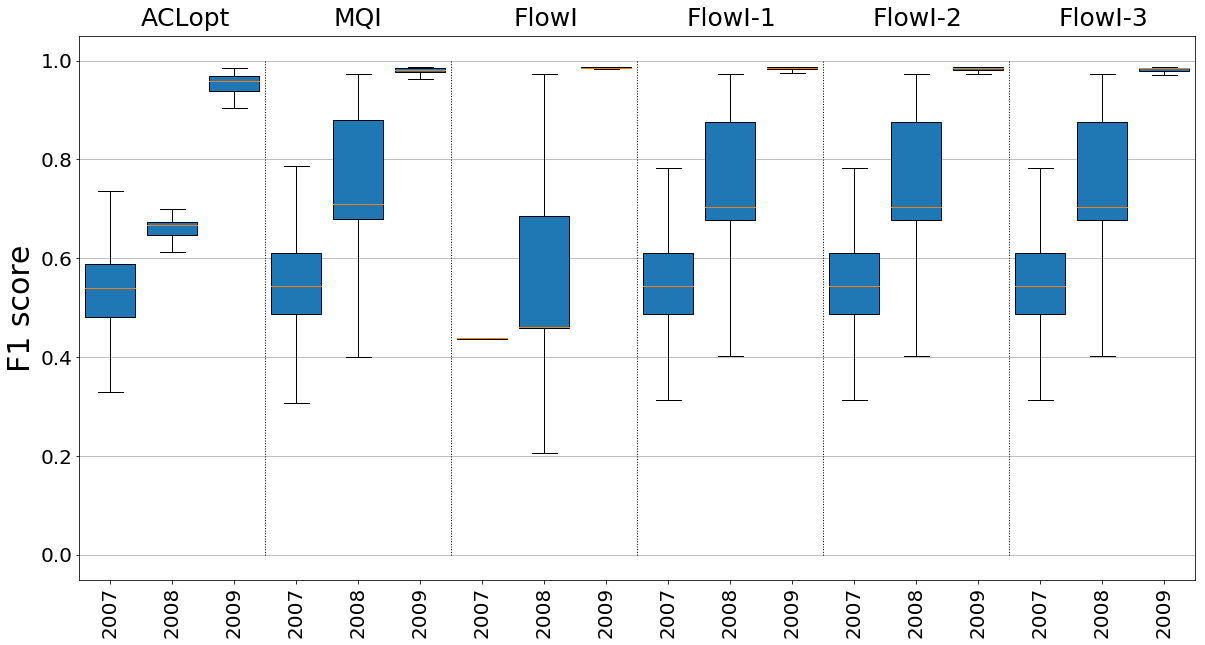

In [25]:
all_data = []
xlabels_ = []
    
for i in range(l_info_ref_nodes):
    temp_f1  = []
    
    for j in nodes[i]:
        temp_f1.append(f1score_best_pre_acl[i,j])
    all_data.append(temp_f1)

    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_f1  = []
    
    for j in nodes[i]:
        temp_f1.append(f1_mqi[i,j])
    all_data.append(temp_f1)
    
    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_f1  = []
    
    for j in nodes[i]:
        temp_f1.append(f1score_acl_flow_flowImprove[i,j])
    all_data.append(temp_f1)
    
    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_f1  = []
    
    for j in nodes[i]:
        temp_f1.append(f1_acl_flow_localflowImprove_parameter1[i,j])
    all_data.append(temp_f1)
    
    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_f1  = []
    
    for j in nodes[i]:
        temp_f1.append(f1_acl_flow_localflowImprove_parameter2[i,j])
    all_data.append(temp_f1)
    
    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_f1  = []
    
    for j in nodes[i]:
        temp_f1.append(f1_acl_flow_localflowImprove_parameter3[i,j])
    all_data.append(temp_f1)
    
    xlabels_.append(int(info_ref_nodes[i,1]))

fig = plt.figure(figsize=(20, 10))
axes = plt.gca()

# notch shape box plot
bplot2 = axes.boxplot(all_data,
                         notch=False,  # notch shape
                         vert=True,   # vertical box aligmnent
                         patch_artist=True,   # fill with color
                         showfliers=False,widths=0.8)

# adding horizontal grid lines
axes.yaxis.grid(True)
axes.set_xticks([y+1 for y in range(len(all_data))])
axes.set_ylabel('F1 score',fontsize=30)
#axes.set_xlabel('Year')

# add x-tick labels
#plt.setp(axes, xticks=[y+1 for y in range(len(all_data))],
#         xticklabels=[info_ref_nodes[0][1], info_ref_nodes[0][1], info_ref_nodes[0][1], info_ref_nodes[0][1]], info_ref_nodes[0][1], info_ref_nodes[0][1])

plt.setp(axes, xticks=[y+1 for y in range(len(all_data))],xticklabels=xlabels_)
axes.set_xticklabels(axes.xaxis.get_majorticklabels(), rotation=90)

axes.tick_params(labelsize=20)

plt.text(1.5, 1.07, 'ACLopt', fontsize=25)
plt.text(4.6, 1.07, 'MQI', fontsize=25)
plt.text(7.5, 1.07, 'FlowI', fontsize=25)
plt.text(10.3, 1.07, 'FlowI-1', fontsize=25)
plt.text(13.3, 1.07, 'FlowI-2', fontsize=25)
plt.text(16.3, 1.07, 'FlowI-3', fontsize=25)

#plt.text(0.75, 0.18, 'Prec.', fontsize=10, rotation=90)
#plt.text(1.8, 0.18, 'Rec.', fontsize=10, rotation=90)

plt.plot([3.5, 3.5], [0, 1], 'k:', linewidth=1)
plt.plot([6.5, 6.5], [0, 1], 'k:', linewidth=1)
plt.plot([9.5, 9.5], [0, 1], 'k:', linewidth=1)
plt.plot([12.5, 12.5], [0, 1], 'k:', linewidth=1)
plt.plot([15.5, 15.5], [0, 1], 'k:', linewidth=1)

plt.savefig('figures/boxplot_Bucknell39_f1_Optimal.png')

plt.show()

## Generate scatter plot for precision

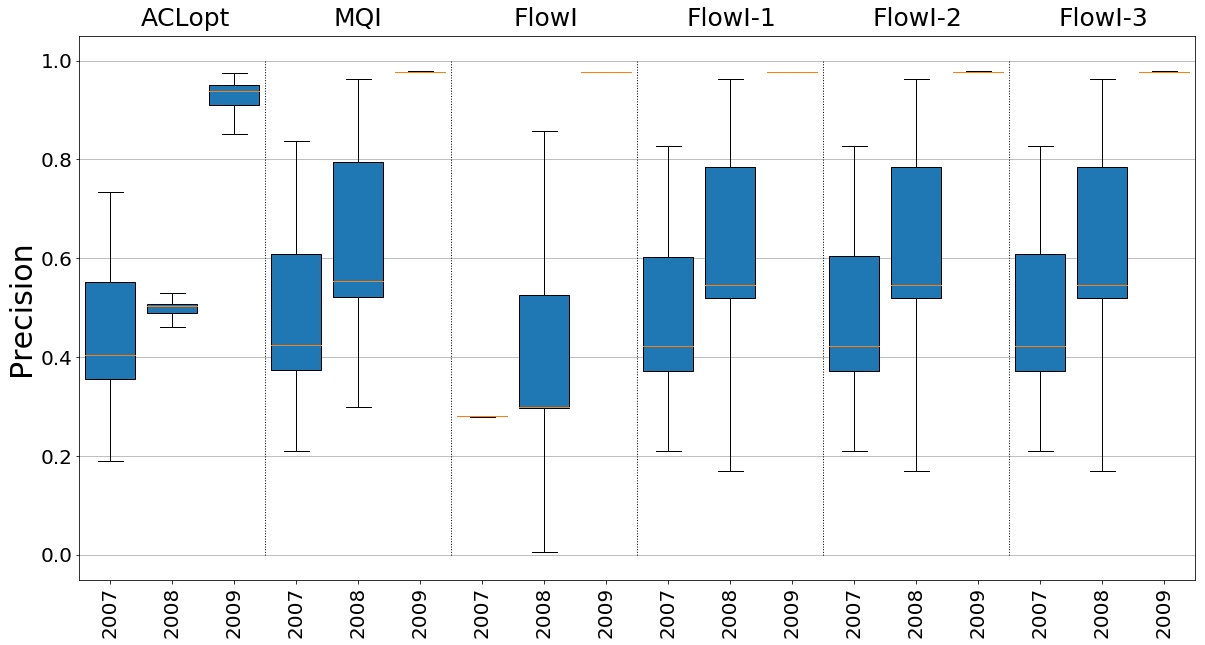

In [26]:
all_data = []
xlabels_ = []
    
for i in range(l_info_ref_nodes):
    temp_pre = []
    
    for j in nodes[i]:
        temp_pre.append(precision_best_pre_acl[i,j])
    all_data.append(temp_pre)

    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_pre = []
    
    for j in nodes[i]:
        temp_pre.append(precision_mqi[i,j])
    all_data.append(temp_pre)
    
    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_pre = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove[i,j])
    all_data.append(temp_pre)
    
    xlabels_.append(int(info_ref_nodes[i,1])) 
    
for i in range(l_info_ref_nodes):
    temp_pre = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove_parameter1[i,j])
    all_data.append(temp_pre)
    
    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_pre = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove_parameter2[i,j])
    all_data.append(temp_pre)
    
    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_pre = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove_parameter3[i,j])
    all_data.append(temp_pre)
    
    xlabels_.append(int(info_ref_nodes[i,1]))

fig = plt.figure(figsize=(20, 10))
axes = plt.gca()

# notch shape box plot
bplot2 = axes.boxplot(all_data,
                         notch=False,  # notch shape
                         vert=True,   # vertical box aligmnent
                         patch_artist=True,   # fill with color
                         showfliers=False,widths=0.8)

# adding horizontal grid lines
axes.yaxis.grid(True)
axes.set_xticks([y+1 for y in range(len(all_data))])
axes.set_ylabel('Precision',fontsize=30)
#axes.set_xlabel('Year')

# add x-tick labels
#plt.setp(axes, xticks=[y+1 for y in range(len(all_data))],
#         xticklabels=[info_ref_nodes[0][1], info_ref_nodes[0][1], info_ref_nodes[0][1], info_ref_nodes[0][1]], info_ref_nodes[0][1], info_ref_nodes[0][1])

plt.setp(axes, xticks=[y+1 for y in range(len(all_data))],xticklabels=xlabels_)
axes.set_xticklabels(axes.xaxis.get_majorticklabels(), rotation=90)

axes.tick_params(labelsize=20)

plt.text(1.5, 1.07, 'ACLopt', fontsize=25)
plt.text(4.6, 1.07, 'MQI', fontsize=25)
plt.text(7.5, 1.07, 'FlowI', fontsize=25)
plt.text(10.3, 1.07, 'FlowI-1', fontsize=25)
plt.text(13.3, 1.07, 'FlowI-2', fontsize=25)
plt.text(16.3, 1.07, 'FlowI-3', fontsize=25)

#plt.text(0.75, 0.18, 'Prec.', fontsize=10, rotation=90)
#plt.text(1.8, 0.18, 'Rec.', fontsize=10, rotation=90)

plt.plot([3.5, 3.5], [0, 1], 'k:', linewidth=1)
plt.plot([6.5, 6.5], [0, 1], 'k:', linewidth=1)
plt.plot([9.5, 9.5], [0, 1], 'k:', linewidth=1)
plt.plot([12.5, 12.5], [0, 1], 'k:', linewidth=1)
plt.plot([15.5, 15.5], [0, 1], 'k:', linewidth=1)

plt.savefig('figures/boxplot_Bucknell39_precision_Optimal.png')

plt.show()

## Generate scatter plot for recall

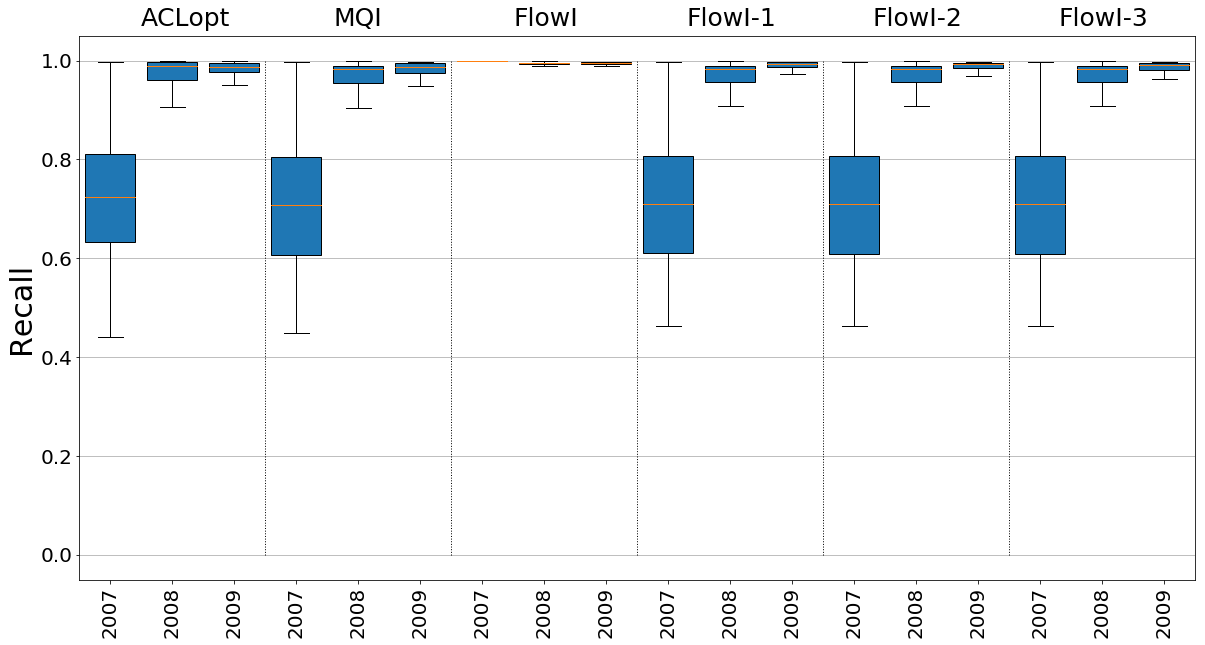

In [27]:
all_data = []
xlabels_ = []
    
for i in range(l_info_ref_nodes):
    temp_rec = []
    
    for j in nodes[i]:
        temp_rec.append(recall_best_pre_acl[i,j])
    all_data.append(temp_rec)

    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_rec = []
    
    for j in nodes[i]:
        temp_rec.append(recall_mqi[i,j])
    all_data.append(temp_rec)

    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_rec = []
    
    for j in nodes[i]:
        temp_rec.append(recall_acl_flow_localflowImprove[i,j])
    all_data.append(temp_rec)

    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_rec = []
    
    for j in nodes[i]:
        temp_rec.append(recall_acl_flow_localflowImprove_parameter1[i,j])
    all_data.append(temp_rec)

    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_rec = []
    
    for j in nodes[i]:
        temp_rec.append(recall_acl_flow_localflowImprove_parameter2[i,j])
    all_data.append(temp_rec)

    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_rec = []
    
    for j in nodes[i]:
        temp_rec.append(recall_acl_flow_localflowImprove_parameter3[i,j])
    all_data.append(temp_rec)

    xlabels_.append(int(info_ref_nodes[i,1]))

fig = plt.figure(figsize=(20, 10))
axes = plt.gca()

# notch shape box plot
bplot2 = axes.boxplot(all_data,
                         notch=False,  # notch shape
                         vert=True,   # vertical box aligmnent
                         patch_artist=True,   # fill with color
                         showfliers=False,widths=0.8)

# adding horizontal grid lines
axes.yaxis.grid(True)
axes.set_xticks([y+1 for y in range(len(all_data))])
axes.set_ylabel('Recall',fontsize=30)
#axes.set_xlabel('Year')

# add x-tick labels
#plt.setp(axes, xticks=[y+1 for y in range(len(all_data))],
#         xticklabels=[info_ref_nodes[0][1], info_ref_nodes[0][1], info_ref_nodes[0][1], info_ref_nodes[0][1]], info_ref_nodes[0][1], info_ref_nodes[0][1])

plt.setp(axes, xticks=[y+1 for y in range(len(all_data))],xticklabels=xlabels_)
axes.set_xticklabels(axes.xaxis.get_majorticklabels(), rotation=90)

axes.tick_params(labelsize=20)

plt.text(1.5, 1.07, 'ACLopt', fontsize=25)
plt.text(4.6, 1.07, 'MQI', fontsize=25)
plt.text(7.5, 1.07, 'FlowI', fontsize=25)
plt.text(10.3, 1.07, 'FlowI-1', fontsize=25)
plt.text(13.3, 1.07, 'FlowI-2', fontsize=25)
plt.text(16.3, 1.07, 'FlowI-3', fontsize=25)

#plt.text(0.75, 0.18, 'Prec.', fontsize=10, rotation=90)
#plt.text(1.8, 0.18, 'Rec.', fontsize=10, rotation=90)

plt.plot([3.5, 3.5], [0, 1], 'k:', linewidth=1)
plt.plot([6.5, 6.5], [0, 1], 'k:', linewidth=1)
plt.plot([9.5, 9.5], [0, 1], 'k:', linewidth=1)
plt.plot([12.5, 12.5], [0, 1], 'k:', linewidth=1)
plt.plot([15.5, 15.5], [0, 1], 'k:', linewidth=1)

plt.savefig('figures/boxplot_Bucknell39_recall_Optimal.png')

plt.show()

## Generate precision/recall and F1 scores

In [28]:
all_data = []
xlabels_ = []

print('Results for ACLopt')
for i in range(l_info_ref_nodes):
    temp_pre = []
    temp_rec = []
    temp_f1 = []
    
    for j in nodes[i]:
        temp_pre.append(precision_best_pre_acl[i,j])
        temp_rec.append(recall_best_pre_acl[i,j])
        temp_f1.append(f1score_best_pre_acl[i,j])

    print('Feature:', info_ref_nodes[i,1],'Precision', stat_.median(temp_pre), 'Recall', stat_.median(temp_rec), 'F1', stat_.median(temp_f1))
    
print('Results for MQI')
for i in range(l_info_ref_nodes):
    temp_pre = []
    temp_rec = []
    temp_f1 = []
    
    for j in nodes[i]:
        temp_pre.append(precision_mqi[i,j])
        temp_rec.append(recall_mqi[i,j])
        temp_f1.append(f1_mqi[i,j])
        
    print('Feature:', info_ref_nodes[i,1],'Precision', stat_.median(temp_pre), 'Recall', stat_.median(temp_rec), 'F1', stat_.median(temp_f1))
    
print('Results for FlowI')
for i in range(l_info_ref_nodes):
    temp_pre = []
    temp_rec = []
    temp_f1 = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove[i,j])
        temp_rec.append(recall_acl_flow_localflowImprove[i,j])
        temp_f1.append(f1score_acl_flow_flowImprove[i,j])
        
    print('Feature:', info_ref_nodes[i,1],'Precision', stat_.median(temp_pre), 'Recall', stat_.median(temp_rec), 'F1', stat_.median(temp_f1))
    
print('Results for FlowI-1')
for i in range(l_info_ref_nodes):
    temp_pre = []
    temp_rec = []
    temp_f1 = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove_parameter1[i,j])
        temp_rec.append(recall_acl_flow_localflowImprove_parameter1[i,j])
        temp_f1.append(f1_acl_flow_localflowImprove_parameter1[i,j])

    print('Feature:', info_ref_nodes[i,1],'Precision', stat_.median(temp_pre), 'Recall', stat_.median(temp_rec), 'F1', stat_.median(temp_f1))
    
print('Results for FlowI-2')
for i in range(l_info_ref_nodes):
    temp_pre = []
    temp_rec = []
    temp_f1 = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove_parameter2[i,j])
        temp_rec.append(recall_acl_flow_localflowImprove_parameter2[i,j])
        temp_f1.append(f1_acl_flow_localflowImprove_parameter2[i,j])
        
    print('Feature:', info_ref_nodes[i,1],'Precision', stat_.median(temp_pre), 'Recall', stat_.median(temp_rec), 'F1', stat_.median(temp_f1))
    
print('Results for FlowI-3')
for i in range(l_info_ref_nodes):
    temp_pre = []
    temp_rec = []
    temp_f1 = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove_parameter3[i,j])
        temp_rec.append(recall_acl_flow_localflowImprove_parameter3[i,j])
        temp_f1.append(f1_acl_flow_localflowImprove_parameter3[i,j])
        
    print('Feature:', info_ref_nodes[i,1],'Precision', stat_.median(temp_pre), 'Recall', stat_.median(temp_rec), 'F1', stat_.median(temp_f1))

Results for ACLopt
Feature: 2007 Precision 0.4047372932634127 Recall 0.724902682519927 F1 0.5390145971386023
Feature: 2008 Precision 0.50336255782224 Recall 0.9882019411706447 F1 0.6673105268493507
Feature: 2009 Precision 0.9392480959987528 Recall 0.9881397086290624 F1 0.959730713400031
Results for MQI
Feature: 2007 Precision 0.4237006617666292 Recall 0.7072134099515399 F1 0.5447062048141341
Feature: 2008 Precision 0.5545510394592826 Recall 0.9831323660493216 F1 0.7090044729419818
Feature: 2009 Precision 0.9769717435970462 Recall 0.9866766280662433 F1 0.9820168918995287
Results for FlowI
Feature: 2007 Precision 0.28091877392640435 Recall 0.9993379763260334 F1 0.4385513625251863
Feature: 2008 Precision 0.299149165292279 Recall 0.9959022481925325 F1 0.46005400124679696
Feature: 2009 Precision 0.9769717435970462 Recall 0.9951230647906031 F1 0.9859664634459787
Results for FlowI-1
Feature: 2007 Precision 0.42198303005122145 Recall 0.7094775309165056 F1 0.5435515159441138
Feature: 2008 Preci